In [ ]:
!pip freeze

In [ ]:
!conda env list


In [ ]:
!conda create -n tf-gpu-cuda9 tensorflow-gpu cudatoolkit=9.0

In [ ]:
!activate base

In [ ]:
!from google.colab import drive
drive.mount('/content/drive')


In [ ]:
import os

# Set your dataset path here
base_dir = '/content/drive/MyDrive/guangdong1_round1_train2_20190828'
normal_images_dir = os.path.join(base_dir, 'normal_Images')
defect_images_dir = os.path.join(base_dir, 'defect_Images')
annotations_file = os.path.join(base_dir, 'Annotations', 'anno_train.json')


In [ ]:
import json

with open(annotations_file, 'r') as f:
    annotations = json.load(f)

# Check the type of the annotations object
print(type(annotations))

# If it's a list, access elements by index
if isinstance(annotations, list):
    # Print the keys of the first element in the list (if it's a dictionary)
    if isinstance(annotations[0], dict):
        print(annotations[0].keys())
    else:
        print("The elements in the list are not dictionaries.")

In [ ]:
from PIL import Image
import torch
from torchvision import transforms

# Image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images
    transforms.ToTensor()           # Convert images to tensors
])

def load_image(image_path):
    img = Image.open(image_path).convert('RGB')
    return transform(img)

def load_annotations(image_name):
    return annotations.get(image_name, None)


In [ ]:
!pip install timm


In [ ]:
import timm
from torch import nn

# Load Swin Transformer model (pre-trained)
swin_model = timm.create_model('swin_large_patch4_window7_224', pretrained=True)

# Modify the classifier to fit the number of classes (2: defect, normal)
swin_model.head = nn.Linear(swin_model.head.in_features, 2)

# Move the model to GPU
swin_model = swin_model.cuda()


In [ ]:
!sudo apt install nvidia-driver-510

In [ ]:
import torch

if torch.cuda.is_available(): # Removed extra indent
    print("CUDA is available! GPU found.")
else:
    print("CUDA is not available. No GPU found.")

In [ ]:
import timm
from torch import nn

# Load Swin Transformer model (pre-trained)
swin_model = timm.create_model('swin_large_patch4_window7_224', pretrained=True)

# Modify the classifier to fit the number of classes (2: defect, normal)
swin_model.head = nn.Linear(swin_model.head.in_features, 2)

# Move the model to GPU
swin_model = swin_model.cuda()


In [ ]:
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# Load Faster R-CNN with ResNet-50 backbone
faster_rcnn = fasterrcnn_resnet50_fpn(pretrained=True)

# Modify the classifier
in_features = faster_rcnn.roi_heads.box_predictor.cls_score.in_features
faster_rcnn.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes=2)

# Move the model to GPU
faster_rcnn = faster_rcnn.cuda()


In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import timm
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet
import os
import json
from PIL import Image
from torchvision import transforms
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define dataset paths
base_dir = '/content/drive/MyDrive/guangdong1_round1_train2_20190828'
defect_images_dir = os.path.join(base_dir, 'defect_Images')
normal_images_dir = os.path.join(base_dir, 'normal_Images')
annotations_dir = os.path.join(base_dir, 'Annotations')

# Load the annotations from the JSON file
with open(os.path.join(annotations_dir, 'anno_train.json')) as f:
    annotations = json.load(f)

# Function to load and process images
def load_image(image_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    image = Image.open(image_path).convert('RGB')
    image = preprocess(image)
    return image

# Function to load annotations
def load_annotations(img_name):
    if img_name in annotations:
        anno = annotations[img_name]
        boxes = [anno['bbox']]
        labels = [anno['category']]
    else:
        boxes = []
        labels = []

    return {'boxes': torch.tensor(boxes, dtype=torch.float32), 'labels': torch.tensor(labels, dtype=torch.int64)}

# Initialize models
def initialize_models():
    models = {}

    # Swin Transformer (Classification)
    swin_model = timm.create_model('swin_large_patch4_window7_224', pretrained=True)
    swin_model.head = torch.nn.Linear(swin_model.head.in_features, 2)
    models['swin'] = swin_model.cuda()

    # Faster R-CNN (Object Detection)
    faster_rcnn_model = fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = faster_rcnn_model.roi_heads.box_predictor.cls_score.in_features
    faster_rcnn_model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes=2)
    models['faster_rcnn'] = faster_rcnn_model.cuda()

    # EfficientDet (Object Detection)
    config = get_efficientdet_config('tf_efficientdet_d0')
    efficientdet_model = EfficientDet(config, pretrained_backbone=True)
    efficientdet_model.class_net = HeadNet(config, num_outputs=2)
    models['efficientdet'] = DetBenchTrain(efficientdet_model, config).cuda()

    return models

# Initialize optimizers
def initialize_optimizers(models):
    optimizers = {}
    optimizers['swin'] = optim.Adam(models['swin'].parameters(), lr=1e-4)
    optimizers['faster_rcnn'] = optim.Adam(models['faster_rcnn'].parameters(), lr=1e-4)
    optimizers['efficientdet'] = optim.Adam(models['efficientdet'].parameters(), lr=1e-4)
    return optimizers

# Function to load data
def load_data():
    img_paths = []
    img_labels = []

    for img_name in os.listdir(defect_images_dir):
        img_paths.append(os.path.join(defect_images_dir, img_name))
        img_labels.append(1)

    for img_name in os.listdir(normal_images_dir):
        img_paths.append(os.path.join(normal_images_dir, img_name))
        img_labels.append(0)

    return img_paths, img_labels

# Function to compute and plot metrics
def compute_metrics(predictions, true_labels):
    # Convert predictions to binary labels based on presence of defects
    predictions = [1 if pred else 0 for pred in predictions]

    acc = accuracy_score(true_labels, predictions)

    # Use 'macro' averaging for multiclass recall
    rec = recall_score(true_labels, predictions, average='macro')
    conf_matrix = confusion_matrix(true_labels, predictions)

    print(f'Accuracy: {acc:.4f}')
    print(f'Recall: {rec:.4f}')

    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Defect'], yticklabels=['Normal', 'Defect'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Training and evaluation loop
def train_and_evaluate_models(models, optimizers, num_epochs=10):
    img_paths, img_labels = load_data()
    global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))  # For Swin Transformer

    for epoch in range(num_epochs):
        for model_name, model in models.items():
            print(f"Training {model_name} for epoch {epoch+1}")

            model.train()
            running_loss = 0.0
            predictions = []
            true_labels = []

            for img_path, label in zip(img_paths, img_labels):
                img = load_image(img_path).unsqueeze(0).cuda()
                target = torch.tensor([label]).cuda()

                if model_name == 'swin':
                    optimizers[model_name].zero_grad()
                    outputs = model(img)
                    if outputs.dim() > 2:
                        outputs = global_avg_pool(outputs)
                        outputs = outputs.view(outputs.size(0), -1)
                    loss = F.cross_entropy(outputs, target)
                    pred_label = outputs.argmax(dim=1).item()

                elif model_name == 'faster_rcnn':
                    annotation = load_annotations(os.path.basename(img_path))
                    if len(annotation['boxes']) > 0:
                        target = {'boxes': annotation['boxes'].cuda(), 'labels': annotation['labels'].cuda()}
                        optimizers[model_name].zero_grad()
                        loss_dict = model([img], [target])
                        loss = sum(loss for loss in loss_dict.values())
                        pred_label = model([img])[0]['labels'].tolist()

                elif model_name == 'efficientdet':
                    annotation = load_annotations(os.path.basename(img_path))
                    if len(annotation['boxes']) > 0:
                        target = {'bbox': annotation['boxes'].cuda(), 'cls': annotation['labels'].cuda()}
                        optimizers[model_name].zero_grad()
                        loss = model(img.unsqueeze(0), target)
                        pred_label = model(img.unsqueeze(0)).argmax(dim=1).item()

                # Backward pass and optimization
                loss.backward()
                optimizers[model_name].step()
                running_loss += loss.item()

                # Collect predictions and true labels
                predictions.append(pred_label)
                true_labels.append(label)

            print(f"{model_name} Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss / len(img_paths):.4f}")

            # Compute metrics
            compute_metrics(predictions, true_labels)

# Initialize models and optimizers
models = initialize_models()
optimizers = initialize_optimizers(models)

# Train and evaluate all models
train_and_evaluate_models(models, optimizers)


In [ ]:
!pip install effdet # install the effdet library

In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import timm
import os
import json
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
import seaborn as sns

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define dataset paths
base_dir = '/content/drive/MyDrive/guangdong1_round1_train2_20190828'
defect_images_dir = os.path.join(base_dir, 'defect_Images')
normal_images_dir = os.path.join(base_dir, 'normal_Images')

# Function to load and process images
def load_image(image_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image)
    return image

# Function to load data
def load_data():
    img_paths = []
    img_labels = []

    for img_name in os.listdir(defect_images_dir):
        img_paths.append(os.path.join(defect_images_dir, img_name))
        img_labels.append(1)  # Defect label

    for img_name in os.listdir(normal_images_dir):
        img_paths.append(os.path.join(normal_images_dir, img_name))
        img_labels.append(0)  # Normal label

    return img_paths, img_labels

# Function to compute and plot metrics
def compute_metrics(predictions, true_labels):
    acc = accuracy_score(true_labels, predictions)
    rec = recall_score(true_labels, predictions, average='macro')
    conf_matrix = confusion_matrix(true_labels, predictions)

    print(f'Accuracy: {acc:.4f}')
    print(f'Recall: {rec:.4f}')

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Defect'], yticklabels=['Normal', 'Defect'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Training and evaluation loop for Swin Transformer
def train_and_evaluate_swin(model, optimizer, num_epochs=5, batch_size=32):
    img_paths, img_labels = load_data()
    global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))

    # Create dataset and dataloader
    dataset = list(zip(img_paths, img_labels))
    num_samples = len(dataset)

    # Shuffle the dataset
    from random import shuffle
    shuffle(dataset)

    for epoch in range(num_epochs):
        print(f"Training Swin Transformer for epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        predictions = []
        true_labels = []

        for batch_idx in range(0, num_samples, batch_size):
            batch_data = dataset[batch_idx:batch_idx+batch_size]
            batch_imgs = []
            batch_labels = []

            for img_path, label in batch_data:
                img = load_image(img_path)
                batch_imgs.append(img)
                batch_labels.append(label)

            batch_imgs = torch.stack(batch_imgs)
            batch_labels = torch.tensor(batch_labels)

            optimizer.zero_grad()
            outputs = model(batch_imgs)
            if outputs.dim() > 2:
                outputs = global_avg_pool(outputs)
                outputs = outputs.view(outputs.size(0), -1)
            loss = F.cross_entropy(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * batch_imgs.size(0)

            # Collect predictions and true labels
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.tolist())
            true_labels.extend(batch_labels.tolist())

        epoch_loss = running_loss / num_samples
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

        # Compute metrics
        compute_metrics(predictions, true_labels)

# Initialize Swin Transformer model
def initialize_swin_model():
    # Use a smaller Swin Transformer model for faster training
    swin_model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)
    swin_model.head = torch.nn.Linear(swin_model.head.in_features, 2)
    return swin_model

# Main execution
if __name__ == "__main__":
    # Initialize model and optimizer
    model = initialize_swin_model()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Train and evaluate the Swin Transformer model
    train_and_evaluate_swin(model, optimizer)


In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import timm
import os
import json
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
import seaborn as sns

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define dataset paths
base_dir = '/content/drive/MyDrive/guangdong1_round1_train2_20190828'
defect_images_dir = os.path.join(base_dir, 'defect_Images')
normal_images_dir = os.path.join(base_dir, 'normal_Images')

# Function to load and process images
def load_image(image_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image)
    return image

# Function to load 50% of data
def load_data():
    img_paths = []
    img_labels = []

    # Load 50% of the defect and normal images
    defect_images = os.listdir(defect_images_dir)[:len(os.listdir(defect_images_dir)) // 2]
    normal_images = os.listdir(normal_images_dir)[:len(os.listdir(normal_images_dir)) // 2]

    for img_name in defect_images:
        img_paths.append(os.path.join(defect_images_dir, img_name))
        img_labels.append(1)  # Defect label

    for img_name in normal_images:
        img_paths.append(os.path.join(normal_images_dir, img_name))
        img_labels.append(0)  # Normal label

    return img_paths, img_labels

# Function to compute and plot metrics
def compute_metrics(predictions, true_labels):
    acc = accuracy_score(true_labels, predictions)
    rec = recall_score(true_labels, predictions, average='macro')
    conf_matrix = confusion_matrix(true_labels, predictions)

    print(f'Accuracy: {acc:.4f}')
    print(f'Recall: {rec:.4f}')

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Defect'], yticklabels=['Normal', 'Defect'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Training and evaluation loop for Swin Transformer
def train_and_evaluate_swin(model, optimizer, num_epochs=5, batch_size=12):
    img_paths, img_labels = load_data()
    global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))

    # Create dataset and dataloader
    dataset = list(zip(img_paths, img_labels))
    num_samples = len(dataset)

    # Shuffle the dataset
    from random import shuffle
    shuffle(dataset)

    for epoch in range(num_epochs):
        print(f"Training Swin Transformer for epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        predictions = []
        true_labels = []

        for batch_idx in range(0, num_samples, batch_size):
            batch_data = dataset[batch_idx:batch_idx+batch_size]
            batch_imgs = []
            batch_labels = []

            for img_path, label in batch_data:
                img = load_image(img_path)
                batch_imgs.append(img)
                batch_labels.append(label)

            batch_imgs = torch.stack(batch_imgs)
            batch_labels = torch.tensor(batch_labels)

            optimizer.zero_grad()
            outputs = model(batch_imgs)
            if outputs.dim() > 2:
                outputs = global_avg_pool(outputs)
                outputs = outputs.view(outputs.size(0), -1)
            loss = F.cross_entropy(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * batch_imgs.size(0)

            # Collect predictions and true labels
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.tolist())
            true_labels.extend(batch_labels.tolist())

        epoch_loss = running_loss / num_samples
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

        # Compute metrics
        compute_metrics(predictions, true_labels)

# Initialize Swin Transformer model
def initialize_swin_model():
    # Use a smaller Swin Transformer model for faster training
    swin_model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)
    swin_model.head = torch.nn.Linear(swin_model.head.in_features, 2)
    return swin_model

# Main execution
if __name__ == "__main__":
    # Initialize model and optimizer
    model = initialize_swin_model()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Train and evaluate the Swin Transformer model
    train_and_evaluate_swin(model, optimizer)


In [ ]:
# code for 10 epochs

In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import timm
import os
import json
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
import seaborn as sns

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define dataset paths
base_dir = '/content/drive/MyDrive/guangdong1_round1_train2_20190828'
defect_images_dir = os.path.join(base_dir, 'defect_Images')
normal_images_dir = os.path.join(base_dir, 'normal_Images')

# Function to load and process images
def load_image(image_path):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    image = Image.open(image_path).convert('RGB')
    image = preprocess(image)
    return image

# Function to load 50% of data
def load_data():
    img_paths = []
    img_labels = []

    # Load 50% of the defect and normal images
    defect_images = os.listdir(defect_images_dir)[:len(os.listdir(defect_images_dir)) // 2]
    normal_images = os.listdir(normal_images_dir)[:len(os.listdir(normal_images_dir)) // 2]

    for img_name in defect_images:
        img_paths.append(os.path.join(defect_images_dir, img_name))
        img_labels.append(1)  # Defect label

    for img_name in normal_images:
        img_paths.append(os.path.join(normal_images_dir, img_name))
        img_labels.append(0)  # Normal label

    return img_paths, img_labels

# Function to compute and plot metrics
def compute_metrics(predictions, true_labels):
    acc = accuracy_score(true_labels, predictions)
    rec = recall_score(true_labels, predictions, average='macro')
    conf_matrix = confusion_matrix(true_labels, predictions)

    print(f'Accuracy: {acc:.4f}')
    print(f'Recall: {rec:.4f}')

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Defect'], yticklabels=['Normal', 'Defect'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Training and evaluation loop for Swin Transformer
def train_and_evaluate_swin(model, optimizer, num_epochs=10, batch_size=12):
    img_paths, img_labels = load_data()
    global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))

    # Create dataset and dataloader
    dataset = list(zip(img_paths, img_labels))
    num_samples = len(dataset)

    # Shuffle the dataset
    from random import shuffle
    shuffle(dataset)

    for epoch in range(num_epochs):
        print(f"Training Swin Transformer for epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        predictions = []
        true_labels = []

        for batch_idx in range(0, num_samples, batch_size):
            batch_data = dataset[batch_idx:batch_idx+batch_size]
            batch_imgs = []
            batch_labels = []

            for img_path, label in batch_data:
                img = load_image(img_path)
                batch_imgs.append(img)
                batch_labels.append(label)

            batch_imgs = torch.stack(batch_imgs)
            batch_labels = torch.tensor(batch_labels)

            optimizer.zero_grad()
            outputs = model(batch_imgs)
            if outputs.dim() > 2:
                outputs = global_avg_pool(outputs)
                outputs = outputs.view(outputs.size(0), -1)
            loss = F.cross_entropy(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * batch_imgs.size(0)

            # Collect predictions and true labels
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.tolist())
            true_labels.extend(batch_labels.tolist())

        epoch_loss = running_loss / num_samples
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

        # Compute metrics
        compute_metrics(predictions, true_labels)

# Initialize Swin Transformer model
def initialize_swin_model():
    # Use a smaller Swin Transformer model for faster training
    swin_model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)
    swin_model.head = torch.nn.Linear(swin_model.head.in_features, 2)
    return swin_model

# Main execution
if __name__ == "__main__":
    # Initialize model and optimizer
    model = initialize_swin_model()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Train and evaluate the Swin Transformer model
    train_and_evaluate_swin(model, optimizer)



In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import timm
import os
import json
from PIL import Image, ImageDraw
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
import seaborn as sns

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define dataset paths
base_dir = '/content/drive/MyDrive/guangdong1_round1_train2_20190828'
defect_images_dir = os.path.join(base_dir, 'defect_Images')
normal_images_dir = os.path.join(base_dir, 'normal_Images')
anno_file_path = os.path.join(base_dir, 'Annotations', 'anno_train.json') # Added 'Annotations' to the path

# Load the annotations from the JSON file
def load_annotations():
    if not os.path.exists(anno_file_path): # Check if the file exists
        raise FileNotFoundError(f"Annotation file not found: {anno_file_path}")
    with open(anno_file_path, 'r') as f:
        annotations = json.load(f)
    return annotations

# Function to load and process images, also includes bounding box visualization for defects
def load_image(image_path, bbox=None):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    image = Image.open(image_path).convert('RGB')

    # If bounding box is provided, we can visualize or use it (optional)
    if bbox is not None and isinstance(bbox, list) and len(bbox) > 0:
        draw = ImageDraw.Draw(image)
        # Check if the bbox is a list of lists (for multiple bboxes) or just a single list
        if isinstance(bbox[0], list):
            for box in bbox:
                # Convert bbox values to integers
                box = [(int(box[0]), int(box[1])), (int(box[0] + box[2]), int(box[1] + box[3]))]
                draw.rectangle(box, outline="red", width=2)
        else:
            # Convert bbox values to integers (single bounding box)
            bbox = [(int(bbox[0]), int(bbox[1])), (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))]
            draw.rectangle(bbox, outline="red", width=2)

    image = preprocess(image)
    return image


# Function to load data with bounding boxes
def load_data(annotations):
    img_paths = []
    img_labels = []
    img_bboxes = {}

    # Load defect images and use annotations
    for img_name in os.listdir(defect_images_dir):
        img_paths.append(os.path.join(defect_images_dir, img_name))

        # Find all the annotations for this image
        img_annotations = [a for a in annotations if a['name'] == img_name]

        if img_annotations:
            img_labels.append(1)  # Defect label
            # Store bounding boxes for this image (could be multiple)
            img_bboxes[img_name] = [anno['bbox'] for anno in img_annotations]
        else:
            img_labels.append(0)  # Normal label

    # Load normal images
    for img_name in os.listdir(normal_images_dir):
        img_paths.append(os.path.join(normal_images_dir, img_name))
        img_labels.append(0)  # Normal label

    return img_paths, img_labels, img_bboxes

# Function to compute and plot metrics
def compute_metrics(predictions, true_labels):
    acc = accuracy_score(true_labels, predictions)
    rec = recall_score(true_labels, predictions, average='macro')
    conf_matrix = confusion_matrix(true_labels, predictions)

    print(f'Accuracy: {acc:.4f}')
    print(f'Recall: {rec:.4f}')

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Defect'], yticklabels=['Normal', 'Defect'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Training and evaluation loop for Swin Transformer
def train_and_evaluate_swin(model, optimizer, num_epochs=10, batch_size=16):
    annotations = load_annotations()  # Load annotations
    img_paths, img_labels, img_bboxes = load_data(annotations)  # Load images, labels, and bounding boxes
    global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))

    # Create dataset and dataloader
    dataset = list(zip(img_paths, img_labels))
    num_samples = len(dataset)

    # Shuffle the dataset
    from random import shuffle
    shuffle(dataset)

    for epoch in range(num_epochs):
        print(f"Training Swin Transformer for epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        predictions = []
        true_labels = []

        for batch_idx in range(0, num_samples, batch_size):
            batch_data = dataset[batch_idx:batch_idx+batch_size]
            batch_imgs = []
            batch_labels = []

            for img_path, label in batch_data:
                img_name = os.path.basename(img_path)
                # If defect image, pass its bounding box for visualization (optional)
                bbox = img_bboxes.get(img_name, None)
                img = load_image(img_path, bbox)
                batch_imgs.append(img)
                batch_labels.append(label)

            batch_imgs = torch.stack(batch_imgs)
            batch_labels = torch.tensor(batch_labels)

            optimizer.zero_grad()
            outputs = model(batch_imgs)
            if outputs.dim() > 2:
                outputs = global_avg_pool(outputs)
                outputs = outputs.view(outputs.size(0), -1)
            loss = F.cross_entropy(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * batch_imgs.size(0)

            # Collect predictions and true labels
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.tolist())
            true_labels.extend(batch_labels.tolist())

        epoch_loss = running_loss / num_samples
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

        # Compute metrics
        compute_metrics(predictions, true_labels)

# Initialize Swin Transformer model
def initialize_swin_model():
    # Use a smaller Swin Transformer model for faster training
    swin_model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)
    swin_model.head = torch.nn.Linear(swin_model.head.in_features, 2)  # Binary classification: Normal vs Defect
    return swin_model

# Main execution
if __name__ == "__main__":
    # Initialize model and optimizer
    model = initialize_swin_model()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Train and evaluate the Swin Transformer model
    train_and_evaluate_swin(model, optimizer)


In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import timm
import os
import json
from PIL import Image, ImageDraw
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
import seaborn as sns

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define dataset paths
base_dir = '/content/drive/MyDrive/guangdong1_round1_train2_20190828'
defect_images_dir = os.path.join(base_dir, 'defect_Images')
normal_images_dir = os.path.join(base_dir, 'normal_Images')
anno_file_path = os.path.join(base_dir, 'Annotations', 'anno_train.json') # Added 'Annotations' to the path

# Load the annotations from the JSON file
def load_annotations():
    if not os.path.exists(anno_file_path): # Check if the file exists
        raise FileNotFoundError(f"Annotation file not found: {anno_file_path}")
    with open(anno_file_path, 'r') as f:
        annotations = json.load(f)
    return annotations

# Function to load and process images in grayscale, includes bounding box visualization for defects
def load_image(image_path, bbox=None):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(),  # Convert to grayscale
        transforms.ToTensor()
    ])

    image = Image.open(image_path).convert('L')  # Directly load the image in grayscale mode ('L')

    # If bounding box is provided, we can visualize or use it (optional)
    if bbox is not None and isinstance(bbox, list) and len(bbox) > 0:
        draw = ImageDraw.Draw(image)
        # Check if the bbox is a list of lists (for multiple bboxes) or just a single list
        if isinstance(bbox[0], list):
            for box in bbox:
                # Convert bbox values to integers
                box = [(int(box[0]), int(box[1])), (int(box[0] + box[2]), int(box[1] + box[3]))]
                draw.rectangle(box, outline="red", width=2)
        else:
            # Convert bbox values to integers (single bounding box)
            bbox = [(int(bbox[0]), int(bbox[1])), (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))]
            draw.rectangle(bbox, outline="red", width=2)

    image = preprocess(image)
    return image


# Function to load data with bounding boxes
def load_data(annotations):
    img_paths = []
    img_labels = []
    img_bboxes = {}

    # Load defect images and use annotations
    for img_name in os.listdir(defect_images_dir):
        img_paths.append(os.path.join(defect_images_dir, img_name))

        # Find all the annotations for this image
        img_annotations = [a for a in annotations if a['name'] == img_name]

        if img_annotations:
            img_labels.append(1)  # Defect label
            # Store bounding boxes for this image (could be multiple)
            img_bboxes[img_name] = [anno['bbox'] for anno in img_annotations]
        else:
            img_labels.append(0)  # Normal label

    # Load normal images
    for img_name in os.listdir(normal_images_dir):
        img_paths.append(os.path.join(normal_images_dir, img_name))
        img_labels.append(0)  # Normal label

    return img_paths, img_labels, img_bboxes

# Function to compute and plot metrics
def compute_metrics(predictions, true_labels):
    acc = accuracy_score(true_labels, predictions)
    rec = recall_score(true_labels, predictions, average='macro')

    # Generate confusion matrix with fixed class labels: Normal (0) and Defect (1)
    conf_matrix = confusion_matrix(true_labels, predictions, labels=[0, 1])

    print(f'Accuracy: {acc:.4f}')
    print(f'Recall: {rec:.4f}')

    plt.figure(figsize=(6, 5))

    # Plot confusion matrix with fixed labels ['Normal', 'Defect']
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Defect'], yticklabels=['Normal', 'Defect'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Training and evaluation loop for Swin Transformer
def train_and_evaluate_swin(model, optimizer, num_epochs=10, batch_size=16):
    annotations = load_annotations()  # Load annotations
    img_paths, img_labels, img_bboxes = load_data(annotations)  # Load images, labels, and bounding boxes
    global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))

    # Create dataset and dataloader
    dataset = list(zip(img_paths, img_labels))
    num_samples = len(dataset)

    # Shuffle the dataset
    from random import shuffle
    shuffle(dataset)

    for epoch in range(num_epochs):
        print(f"Training Swin Transformer for epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        predictions = []
        true_labels = []

        for batch_idx in range(0, num_samples, batch_size):
            batch_data = dataset[batch_idx:batch_idx+batch_size]
            batch_imgs = []
            batch_labels = []

            for img_path, label in batch_data:
                img_name = os.path.basename(img_path)
                # If defect image, pass its bounding box for visualization (optional)
                bbox = img_bboxes.get(img_name, None)
                img = load_image(img_path, bbox)
                batch_imgs.append(img)
                batch_labels.append(label)

            batch_imgs = torch.stack(batch_imgs)
            batch_labels = torch.tensor(batch_labels)

            optimizer.zero_grad()
            outputs = model(batch_imgs)
            if outputs.dim() > 2:
                outputs = global_avg_pool(outputs)
                outputs = outputs.view(outputs.size(0), -1)
            loss = F.cross_entropy(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * batch_imgs.size(0)

            # Collect predictions and true labels
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.tolist())
            true_labels.extend(batch_labels.tolist())

        epoch_loss = running_loss / num_samples
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

        # Compute metrics
        compute_metrics(predictions, true_labels)

# Initialize Swin Transformer model with input channel modification
def initialize_swin_model():
    # Use a smaller Swin Transformer model for faster training
    swin_model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)

    # Modify the first convolution layer to accept grayscale (1-channel) input
    swin_model.patch_embed.proj = torch.nn.Conv2d(1, swin_model.patch_embed.proj.out_channels,
                                                  kernel_size=swin_model.patch_embed.proj.kernel_size,
                                                  stride=swin_model.patch_embed.proj.stride,
                                                  padding=swin_model.patch_embed.proj.padding)

    # Update the classifier head to output 2 classes (defect vs. normal)
    swin_model.head = torch.nn.Linear(swin_model.head.in_features, 2)
    return swin_model


# Main execution
if __name__ == "__main__":
    # Initialize model and optimizer
    model = initialize_swin_model()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Train and evaluate the Swin Transformer model
    train_and_evaluate_swin(model, optimizer)


In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import timm
import os
import json
from PIL import Image, ImageDraw
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
import seaborn as sns

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define dataset paths
base_dir = '/content/drive/MyDrive/guangdong1_round1_train2_20190828'
defect_images_dir = os.path.join(base_dir, 'defect_Images')
normal_images_dir = os.path.join(base_dir, 'normal_Images')
anno_file_path = os.path.join(base_dir, 'Annotations', 'anno_train.json')

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Load the annotations from the JSON file
def load_annotations():
    if not os.path.exists(anno_file_path):
        raise FileNotFoundError(f"Annotation file not found: {anno_file_path}")
    with open(anno_file_path, 'r') as f:
        annotations = json.load(f)
    return annotations

# Function to load and process images in grayscale, includes bounding box visualization for defects
def load_image(image_path, bbox=None):
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),  # Resized to 224x224 as expected by the model
        transforms.Grayscale(),  # Convert to grayscale
        transforms.ToTensor()
    ])

    image = Image.open(image_path).convert('L')  # Directly load the image in grayscale mode ('L')

    if bbox is not None and isinstance(bbox, list) and len(bbox) > 0:
        draw = ImageDraw.Draw(image)
        if isinstance(bbox[0], list):
            for box in bbox:
                box = [(int(box[0]), int(box[1])), (int(box[0] + box[2]), int(box[1] + box[3]))]
                draw.rectangle(box, outline="red", width=2)
        else:
            bbox = [(int(bbox[0]), int(bbox[1])), (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))]
            draw.rectangle(bbox, outline="red", width=2)

    image = preprocess(image)
    return image

# Function to load data with bounding boxes
def load_data(annotations):
    img_paths = []
    img_labels = []
    img_bboxes = {}

    for img_name in os.listdir(defect_images_dir):
        img_paths.append(os.path.join(defect_images_dir, img_name))
        img_annotations = [a for a in annotations if a['name'] == img_name]

        if img_annotations:
            img_labels.append(1)
            img_bboxes[img_name] = [anno['bbox'] for anno in img_annotations]
        else:
            img_labels.append(0)

    for img_name in os.listdir(normal_images_dir):
        img_paths.append(os.path.join(normal_images_dir, img_name))
        img_labels.append(0)

    return img_paths, img_labels, img_bboxes

# Function to compute and plot metrics
def compute_metrics(predictions, true_labels):
    acc = accuracy_score(true_labels, predictions)
    rec = recall_score(true_labels, predictions, average='macro')

    conf_matrix = confusion_matrix(true_labels, predictions, labels=[0, 1])
    print(f'Accuracy: {acc:.4f}')
    print(f'Recall: {rec:.4f}')

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Defect'], yticklabels=['Normal', 'Defect'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Training and evaluation loop for Swin Transformer with optional mixed precision
from torch.cuda.amp import autocast, GradScaler

def train_and_evaluate_swin(model, optimizer, num_epochs=10, batch_size=8, use_mixed_precision=True):
    annotations = load_annotations()
    img_paths, img_labels, img_bboxes = load_data(annotations)
    global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))

    dataset = list(zip(img_paths, img_labels))
    num_samples = len(dataset)
    from random import shuffle
    shuffle(dataset)

    scaler = GradScaler() if use_mixed_precision and device.type == 'cuda' else None

    for epoch in range(num_epochs):
        print(f"Training Swin Transformer for epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        predictions = []
        true_labels = []

        for batch_idx in range(0, num_samples, batch_size):
            batch_data = dataset[batch_idx:batch_idx+batch_size]
            batch_imgs = []
            batch_labels = []

            for img_path, label in batch_data:
                img_name = os.path.basename(img_path)
                bbox = img_bboxes.get(img_name, None)
                img = load_image(img_path, bbox)
                batch_imgs.append(img)
                batch_labels.append(label)

            batch_imgs = torch.stack(batch_imgs).to(device)
            batch_labels = torch.tensor(batch_labels).to(device)

            optimizer.zero_grad()

            if use_mixed_precision and scaler is not None:
                with autocast(device_type='cuda'):
                    outputs = model(batch_imgs)
                    if outputs.dim() > 2:
                        outputs = global_avg_pool(outputs)
                        outputs = outputs.view(outputs.size(0), -1)
                    loss = F.cross_entropy(outputs, batch_labels)

                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(batch_imgs)
                if outputs.dim() > 2:
                    outputs = global_avg_pool(outputs)
                    outputs = outputs.view(outputs.size(0), -1)
                loss = F.cross_entropy(outputs, batch_labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * batch_imgs.size(0)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.tolist())
            true_labels.extend(batch_labels.tolist())

        epoch_loss = running_loss / num_samples
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

        compute_metrics(predictions, true_labels)

# Initialize Swin Transformer model with input channel modification
def initialize_swin_model():
    swin_model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)

    swin_model.patch_embed.proj = torch.nn.Conv2d(1, swin_model.patch_embed.proj.out_channels,
                                                  kernel_size=swin_model.patch_embed.proj.kernel_size,
                                                  stride=swin_model.patch_embed.proj.stride,
                                                  padding=swin_model.patch_embed.proj.padding)

    for param in swin_model.parameters():
        param.requires_grad = False

    swin_model.head = torch.nn.Linear(swin_model.head.in_features, 2)
    swin_model.head.requires_grad = True

    return swin_model

# Main execution
if __name__ == "__main__":
    model = initialize_swin_model().to(device)
    optimizer = optim.Adam(model.head.parameters(), lr=1e-4)

    # Disable mixed precision if CUDA is not available
    train_and_evaluate_swin(model, optimizer, use_mixed_precision=(device.type == 'cuda'))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training Swin Transformer for epoch 1/20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5eeeece5f50b>:123: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_mixed_precision else None
<ipython-input-3-5eeeece5f50b>:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [1/20], Loss: 0.9835
Accuracy: 0.5340
Recall: 0.1528
Precision: 0.1586
F1 Score: 0.1522


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


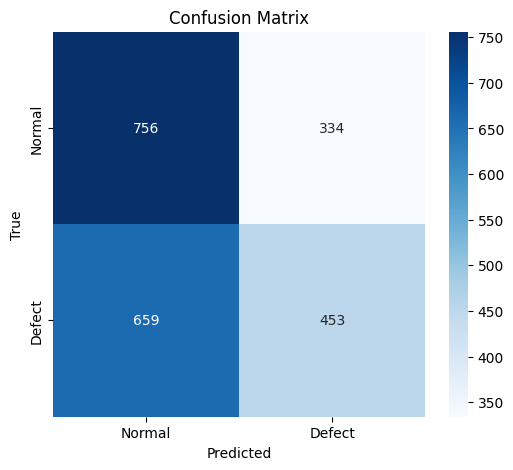

Training Swin Transformer for epoch 2/20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5eeeece5f50b>:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [2/20], Loss: 0.7221
Accuracy: 0.5685
Recall: 0.2275
Precision: 0.2286
F1 Score: 0.2278


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


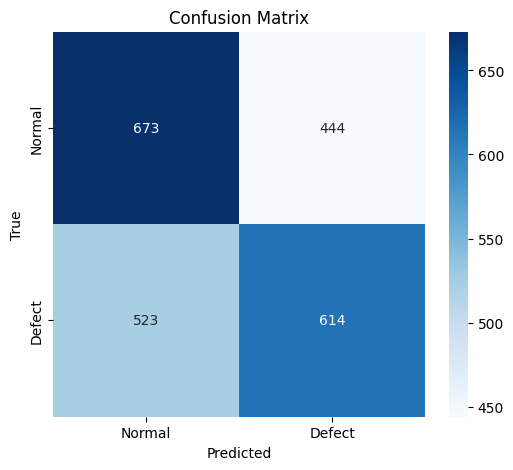

Training Swin Transformer for epoch 3/20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5eeeece5f50b>:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [3/20], Loss: 0.7261
Accuracy: 0.5751
Recall: 0.2300
Precision: 0.2307
F1 Score: 0.2303


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


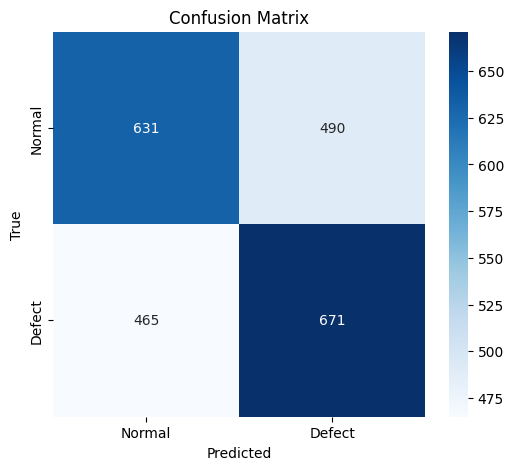

Training Swin Transformer for epoch 4/20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5eeeece5f50b>:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [4/20], Loss: 0.6741
Accuracy: 0.5822
Recall: 0.5821
Precision: 0.5821
F1 Score: 0.5821


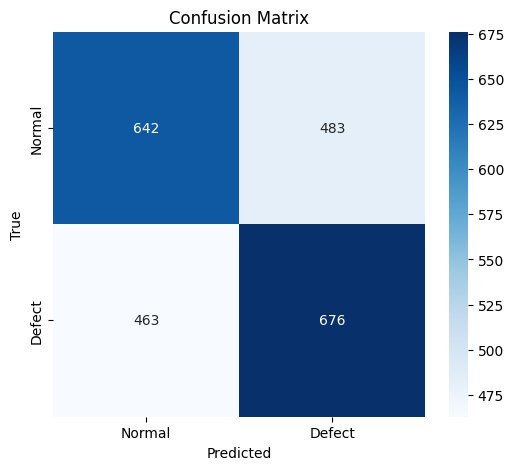

Training Swin Transformer for epoch 5/20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5eeeece5f50b>:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [5/20], Loss: 0.6630
Accuracy: 0.6025
Recall: 0.6024
Precision: 0.6025
F1 Score: 0.6024


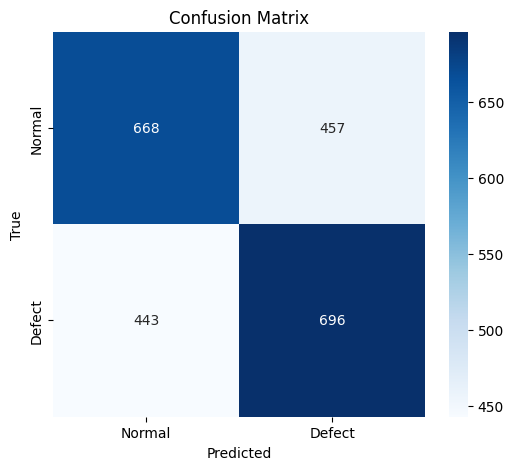

Training Swin Transformer for epoch 6/20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5eeeece5f50b>:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [6/20], Loss: 0.6478
Accuracy: 0.6073
Recall: 0.6072
Precision: 0.6075
F1 Score: 0.6070


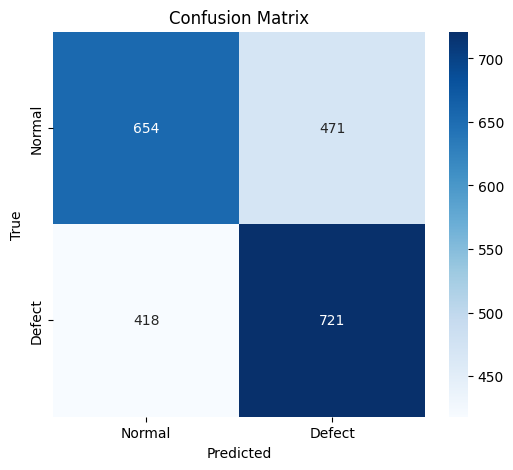

Training Swin Transformer for epoch 7/20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5eeeece5f50b>:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [7/20], Loss: 0.6303
Accuracy: 0.6290
Recall: 0.6288
Precision: 0.6294
F1 Score: 0.6284


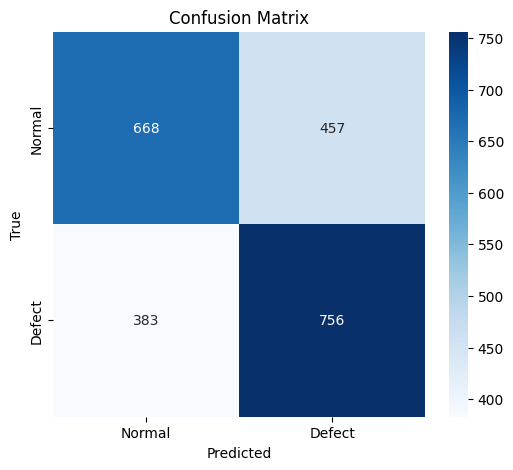

Training Swin Transformer for epoch 8/20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5eeeece5f50b>:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [8/20], Loss: 0.6203
Accuracy: 0.6462
Recall: 0.3230
Precision: 0.3235
F1 Score: 0.3231


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


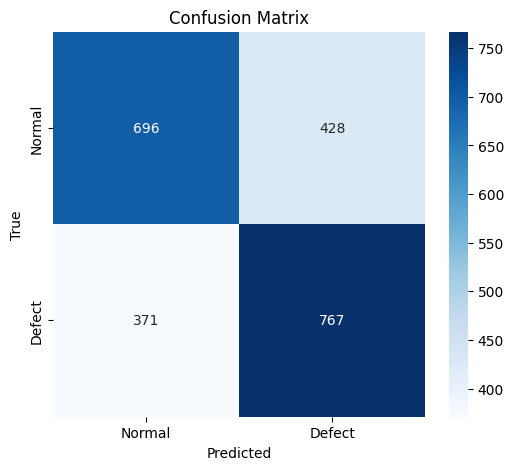

Training Swin Transformer for epoch 9/20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5eeeece5f50b>:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [9/20], Loss: 0.6125
Accuracy: 0.6564
Recall: 0.4374
Precision: 0.4383
F1 Score: 0.4372


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


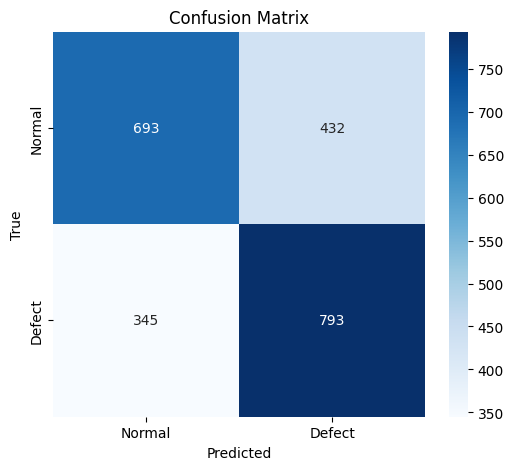

Training Swin Transformer for epoch 10/20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5eeeece5f50b>:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [10/20], Loss: 0.6108
Accuracy: 0.6440
Recall: 0.4292
Precision: 0.4297
F1 Score: 0.4292


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


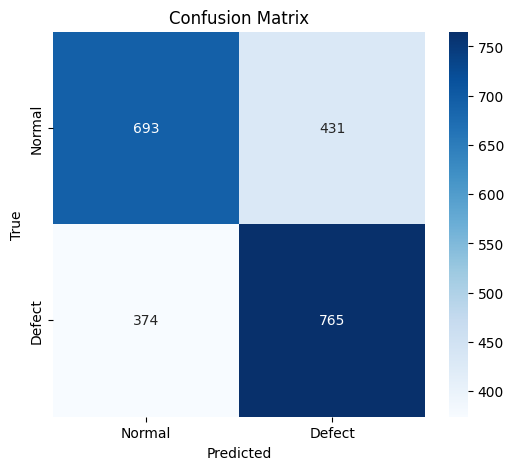

Training Swin Transformer for epoch 11/20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5eeeece5f50b>:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [11/20], Loss: 0.5784
Accuracy: 0.6754
Recall: 0.6754
Precision: 0.6756
F1 Score: 0.6753


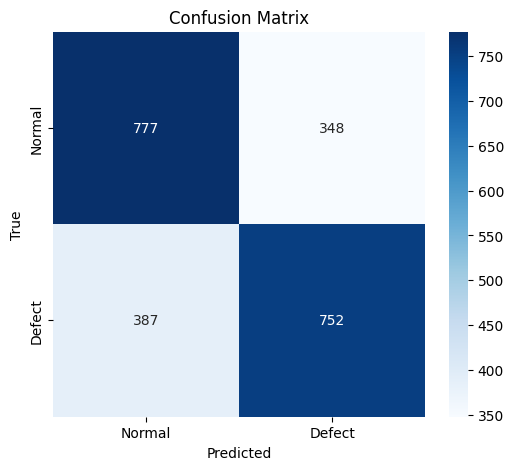

Training Swin Transformer for epoch 12/20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5eeeece5f50b>:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [12/20], Loss: 0.5702
Accuracy: 0.6705
Recall: 0.6703
Precision: 0.6710
F1 Score: 0.6701


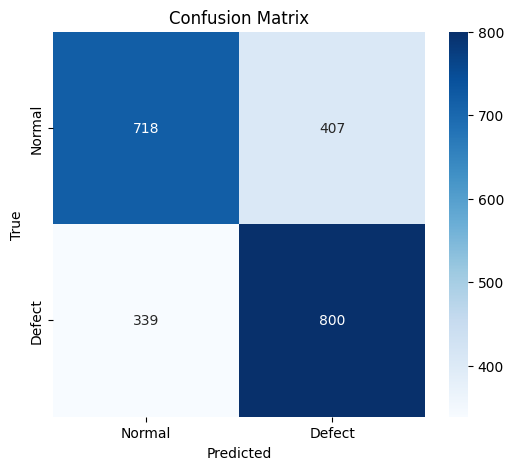

Training Swin Transformer for epoch 13/20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5eeeece5f50b>:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [13/20], Loss: 0.5489
Accuracy: 0.6895
Recall: 0.6894
Precision: 0.6896
F1 Score: 0.6894


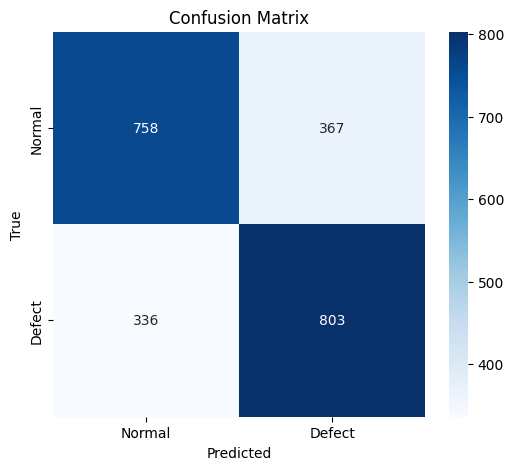

Training Swin Transformer for epoch 14/20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5eeeece5f50b>:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [14/20], Loss: 0.5371
Accuracy: 0.7169
Recall: 0.7168
Precision: 0.7169
F1 Score: 0.7168


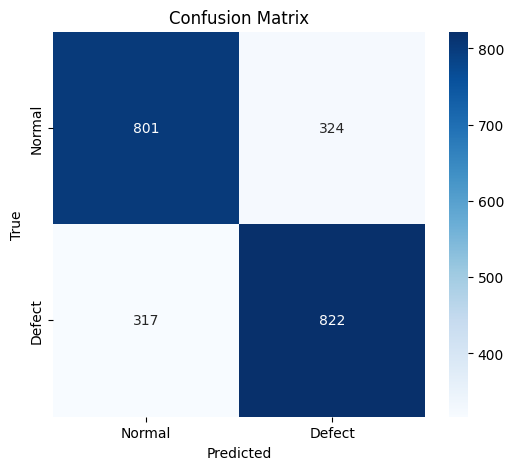

Training Swin Transformer for epoch 15/20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5eeeece5f50b>:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [15/20], Loss: 0.5224
Accuracy: 0.7213
Recall: 0.7213
Precision: 0.7213
F1 Score: 0.7213


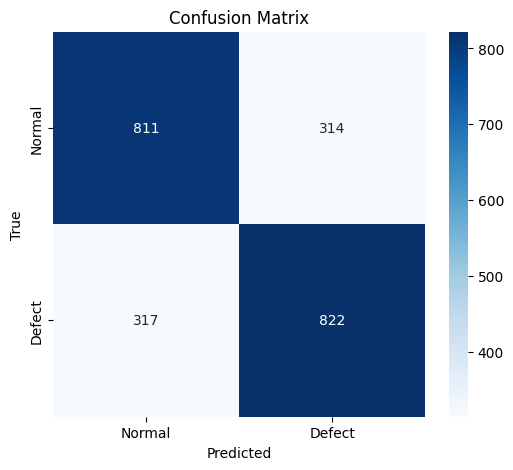

Training Swin Transformer for epoch 16/20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5eeeece5f50b>:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [16/20], Loss: 0.4945
Accuracy: 0.7443
Recall: 0.3721
Precision: 0.3725
F1 Score: 0.3723


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


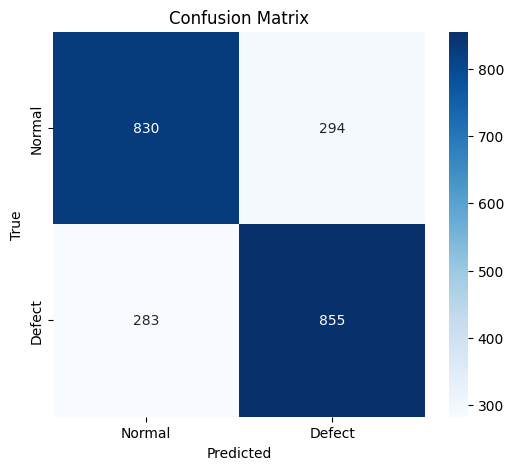

Training Swin Transformer for epoch 17/20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5eeeece5f50b>:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [17/20], Loss: 0.4729
Accuracy: 0.7606
Recall: 0.5070
Precision: 0.5073
F1 Score: 0.5072


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


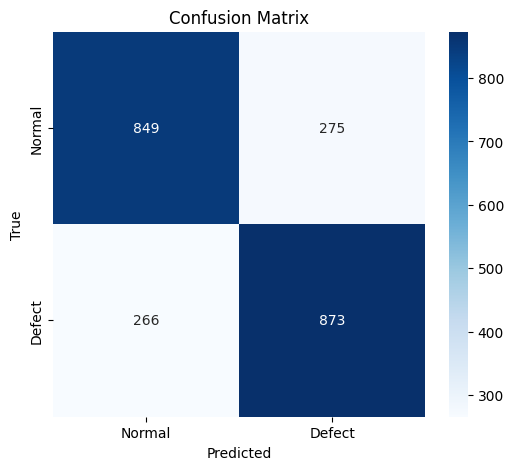

Training Swin Transformer for epoch 18/20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5eeeece5f50b>:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [18/20], Loss: 0.4668
Accuracy: 0.7708
Recall: 0.3854
Precision: 0.3857
F1 Score: 0.3855


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


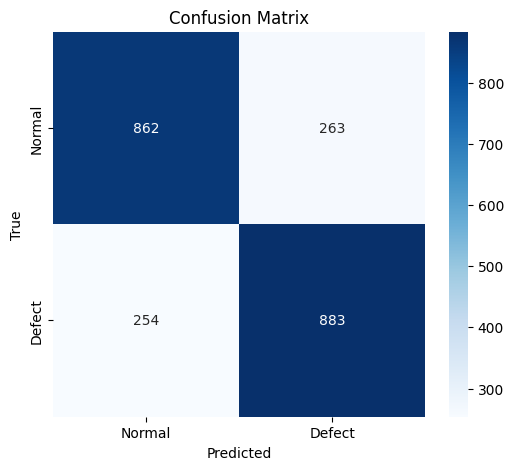

Training Swin Transformer for epoch 19/20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5eeeece5f50b>:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [19/20], Loss: 0.4551
Accuracy: 0.7659
Recall: 0.7659
Precision: 0.7659
F1 Score: 0.7659


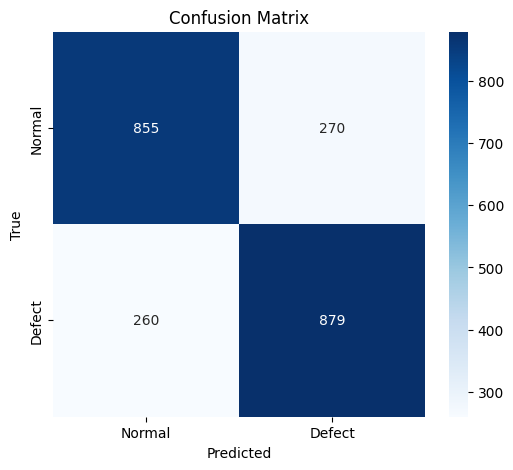

Training Swin Transformer for epoch 20/20


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-3-5eeeece5f50b>:141: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


Epoch [20/20], Loss: 0.4341
Accuracy: 0.7951
Recall: 0.7952
Precision: 0.7954
F1 Score: 0.7950


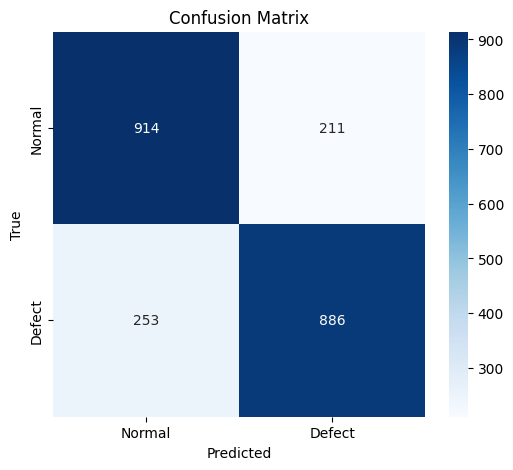

In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import timm
import os
import json
from PIL import Image, ImageDraw
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define dataset paths
base_dir = '/content/drive/MyDrive/guangdong1_round1_train2_20190828'
defect_images_dir = os.path.join(base_dir, 'defect_Images')
normal_images_dir = os.path.join(base_dir, 'normal_Images')
anno_file_path = os.path.join(base_dir, 'Annotations', 'anno_train.json')

# Load the annotations from the JSON file
def load_annotations():
    if not os.path.exists(anno_file_path):
        raise FileNotFoundError(f"Annotation file not found: {anno_file_path}")
    with open(anno_file_path, 'r') as f:
        annotations = json.load(f)
    return annotations

def load_image(image_path, bbox=None):
    image = Image.open(image_path).convert('L')  # Directly load the image in grayscale mode ('L')

    if bbox is not None and isinstance(bbox, list) and len(bbox) > 0:
        draw = ImageDraw.Draw(image)
        if isinstance(bbox[0], list):
            for box in bbox:
                box = [(int(box[0]), int(box[1])), (int(box[0] + box[2]), int(box[1] + box[3]))]
                draw.rectangle(box, outline="red", width=2)
        else:
            bbox = [(int(bbox[0]), int(bbox[1])), (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))]
            draw.rectangle(bbox, outline="red", width=2)

    return image

class FabricDataset(Dataset):
    def __init__(self, img_paths, labels, bboxes=None, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.bboxes = bboxes
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]
        bbox = self.bboxes.get(os.path.basename(img_path), None) if self.bboxes else None
        image = load_image(img_path, bbox)
        if self.transform:
            image = self.transform(image)
        return image, label

# Load data with bounding boxes
def load_data(annotations):
    img_paths = []
    img_labels = []
    img_bboxes = {}

    for img_name in os.listdir(defect_images_dir):
        img_path = os.path.join(defect_images_dir, img_name)
        img_paths.append(img_path)
        img_annotations = [a for a in annotations if a['name'] == img_name]
        if img_annotations:
            img_labels.append(1)  # Defect label
            img_bboxes[img_name] = [anno['bbox'] for anno in img_annotations]
        else:
            img_labels.append(0)  # Normal label

    for img_name in os.listdir(normal_images_dir):
        img_path = os.path.join(normal_images_dir, img_name)
        img_paths.append(img_path)
        img_labels.append(0)  # Normal label

    return img_paths, img_labels, img_bboxes

def compute_metrics(predictions, true_labels):
    acc = accuracy_score(true_labels, predictions)
    rec = recall_score(true_labels, predictions, average='macro')
    prec = precision_score(true_labels, predictions, average='macro')
    f1 = f1_score(true_labels, predictions, average='macro')
    conf_matrix = confusion_matrix(true_labels, predictions, labels=[0, 1])

    print(f'Accuracy: {acc:.4f}')
    print(f'Recall: {rec:.4f}')
    print(f'Precision: {prec:.4f}')
    print(f'F1 Score: {f1:.4f}')

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Defect'], yticklabels=['Normal', 'Defect'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def train_and_evaluate_swin(model, optimizer, num_epochs=20, batch_size=16, use_mixed_precision=False):
    annotations = load_annotations()
    img_paths, img_labels, img_bboxes = load_data(annotations)

    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(),
        transforms.ToTensor()
    ])

    dataset = FabricDataset(img_paths, img_labels, img_bboxes, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))
    scaler = torch.cuda.amp.GradScaler() if use_mixed_precision else None

    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

    for epoch in range(num_epochs):
        print(f"Training Swin Transformer for epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        predictions = []
        true_labels = []

        for batch_imgs, batch_labels in dataloader:
            batch_imgs = batch_imgs.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()

            if use_mixed_precision:
                with torch.cuda.amp.autocast():
                    outputs = model(batch_imgs)
                    outputs = global_avg_pool(outputs).view(outputs.size(0), -1)
                    loss = F.cross_entropy(outputs, batch_labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(batch_imgs)
                outputs = global_avg_pool(outputs).view(outputs.size(0), -1)
                loss = F.cross_entropy(outputs, batch_labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * batch_imgs.size(0)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.tolist())
            true_labels.extend(batch_labels.tolist())

        epoch_loss = running_loss / len(dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        compute_metrics(predictions, true_labels)

        # Step the scheduler
        scheduler.step()

def initialize_swin_model():
    swin_model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)

    # Modify the first convolution layer to accept grayscale (1-channel) input
    swin_model.patch_embed.proj = torch.nn.Conv2d(1, swin_model.patch_embed.proj.out_channels,
                                                  kernel_size=swin_model.patch_embed.proj.kernel_size,
                                                  stride=swin_model.patch_embed.proj.stride,
                                                  padding=swin_model.patch_embed.proj.padding)

    # Unfreeze all layers for fine-tuning
    for param in swin_model.parameters():
        param.requires_grad = True

    # Update the classifier head to output 2 classes (defect vs. normal)
    swin_model.head = torch.nn.Linear(swin_model.head.in_features, 2)
    return swin_model

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = initialize_swin_model().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Train and evaluate the Swin Transformer model for 20 epochs with mixed precision if CUDA is available
    train_and_evaluate_swin(model, optimizer, num_epochs=20, use_mixed_precision=(device.type == 'cuda'))


In [ ]:
!pip install timm # install the missing module



In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import timm
import os
import json
from PIL import Image, ImageDraw
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define dataset paths
base_dir = '/content/drive/MyDrive/guangdong1_round1_train2_20190828'
defect_images_dir = os.path.join(base_dir, 'defect_Images')
normal_images_dir = os.path.join(base_dir, 'normal_Images')
anno_file_path = os.path.join(base_dir, 'Annotations', 'anno_train.json')

# Load the annotations from the JSON file
def load_annotations():
    if not os.path.exists(anno_file_path):
        raise FileNotFoundError(f"Annotation file not found: {anno_file_path}")
    with open(anno_file_path, 'r') as f:
        annotations = json.load(f)
    return annotations

def load_image(image_path, bbox=None):
    image = Image.open(image_path).convert('L')  # Directly load the image in grayscale mode ('L')

    if bbox is not None and isinstance(bbox, list) and len(bbox) > 0:
        draw = ImageDraw.Draw(image)
        if isinstance(bbox[0], list):
            for box in bbox:
                box = [(int(box[0]), int(box[1])), (int(box[0] + box[2]), int(box[1] + box[3]))]
                draw.rectangle(box, outline="red", width=2)
        else:
            bbox = [(int(bbox[0]), int(bbox[1])), (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))]
            draw.rectangle(bbox, outline="red", width=2)

    return image

class FabricDataset(Dataset):
    def __init__(self, img_paths, labels, bboxes=None, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.bboxes = bboxes
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]
        bbox = self.bboxes.get(os.path.basename(img_path), None) if self.bboxes else None
        image = load_image(img_path, bbox)
        if self.transform:
            image = self.transform(image)
        return image, label

# Load data with bounding boxes
def load_data(annotations):
    img_paths = []
    img_labels = []
    img_bboxes = {}

    for img_name in os.listdir(defect_images_dir):
        img_path = os.path.join(defect_images_dir, img_name)
        img_paths.append(img_path)
        img_annotations = [a for a in annotations if a['name'] == img_name]
        if img_annotations:
            img_labels.append(1)  # Defect label
            img_bboxes[img_name] = [anno['bbox'] for anno in img_annotations]
        else:
            img_labels.append(0)  # Normal label

    for img_name in os.listdir(normal_images_dir):
        img_path = os.path.join(normal_images_dir, img_name)
        img_paths.append(img_path)
        img_labels.append(0)  # Normal label

    return img_paths, img_labels, img_bboxes

def compute_metrics(predictions, true_labels):
    acc = accuracy_score(true_labels, predictions)
    rec = recall_score(true_labels, predictions, average='macro')
    prec = precision_score(true_labels, predictions, average='macro')
    f1 = f1_score(true_labels, predictions, average='macro')
    conf_matrix = confusion_matrix(true_labels, predictions, labels=[0, 1])

    print(f'Accuracy: {acc:.4f}')
    print(f'Recall: {rec:.4f}')
    print(f'Precision: {prec:.4f}')
    print(f'F1 Score: {f1:.4f}')

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Defect'], yticklabels=['Normal', 'Defect'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def train_and_evaluate_swin(model, optimizer, num_epochs=20, batch_size=16, use_mixed_precision=False):
    annotations = load_annotations()
    img_paths, img_labels, img_bboxes = load_data(annotations)

    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(),
        transforms.ToTensor()
    ])

    dataset = FabricDataset(img_paths, img_labels, img_bboxes, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))
    scaler = torch.cuda.amp.GradScaler() if use_mixed_precision else None

    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

    for epoch in range(num_epochs):
        print(f"Training Swin Transformer for epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        predictions = []
        true_labels = []

        for batch_imgs, batch_labels in dataloader:
            batch_imgs = batch_imgs.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()

            if use_mixed_precision:
                with torch.cuda.amp.autocast():
                    outputs = model(batch_imgs)
                    outputs = global_avg_pool(outputs).view(outputs.size(0), -1)
                    loss = F.cross_entropy(outputs, batch_labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(batch_imgs)
                outputs = global_avg_pool(outputs).view(outputs.size(0), -1)
                loss = F.cross_entropy(outputs, batch_labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * batch_imgs.size(0)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.tolist())
            true_labels.extend(batch_labels.tolist())

        epoch_loss = running_loss / len(dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        compute_metrics(predictions, true_labels)

        # Step the scheduler
        scheduler.step()

def initialize_swin_model():
    swin_model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)

    # Modify the first convolution layer to accept grayscale (1-channel) input
    swin_model.patch_embed.proj = torch.nn.Conv2d(1, swin_model.patch_embed.proj.out_channels,
                                                  kernel_size=swin_model.patch_embed.proj.kernel_size,
                                                  stride=swin_model.patch_embed.proj.stride,
                                                  padding=swin_model.patch_embed.proj.padding)

    # Unfreeze all layers for fine-tuning
    for param in swin_model.parameters():
        param.requires_grad = True

    # Update the classifier head to output 2 classes (defect vs. normal)
    swin_model.head = torch.nn.Linear(swin_model.head.in_features, 2)
    return swin_model

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = initialize_swin_model().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Train and evaluate the Swin Transformer model for 20 epochs with mixed precision if CUDA is available
    train_and_evaluate_swin(model, optimizer, num_epochs=20, use_mixed_precision=(device.type == 'cuda'))


In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import timm
import os
import json
from PIL import Image, ImageDraw
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define dataset paths
base_dir = '/content/drive/MyDrive/guangdong1_round1_train2_20190828'
defect_images_dir = os.path.join(base_dir, 'defect_Images')
normal_images_dir = os.path.join(base_dir, 'normal_Images')
anno_file_path = os.path.join(base_dir, 'Annotations', 'anno_train.json')

# Load the annotations from the JSON file
def load_annotations():
    if not os.path.exists(anno_file_path):
        raise FileNotFoundError(f"Annotation file not found: {anno_file_path}")
    with open(anno_file_path, 'r') as f:
        annotations = json.load(f)
    return annotations

def load_image(image_path, bbox=None):
    image = Image.open(image_path).convert('L')  # Directly load the image in grayscale mode ('L')

    if bbox is not None and isinstance(bbox, list) and len(bbox) > 0:
        draw = ImageDraw.Draw(image)
        if isinstance(bbox[0], list):
            for box in bbox:
                box = [(int(box[0]), int(box[1])), (int(box[0] + box[2]), int(box[1] + box[3]))]
                draw.rectangle(box, outline="red", width=2)
        else:
            bbox = [(int(bbox[0]), int(bbox[1])), (int(bbox[0] + box[2]), int(bbox[1] + bbox[3]))]
            draw.rectangle(bbox, outline="red", width=2)

    return image

class FabricDataset(Dataset):
    def __init__(self, img_paths, labels, bboxes=None, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.bboxes = bboxes
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]
        bbox = self.bboxes.get(os.path.basename(img_path), None) if self.bboxes else None
        image = load_image(img_path, bbox)
        if self.transform:
            image = self.transform(image)
        return image, label

# Load data with bounding boxes
def load_data(annotations):
    img_paths = []
    img_labels = []
    img_bboxes = {}

    for img_name in os.listdir(defect_images_dir):
        img_path = os.path.join(defect_images_dir, img_name)
        img_paths.append(img_path)
        img_annotations = [a for a in annotations if a['name'] == img_name]
        if img_annotations:
            img_labels.append(1)  # Defect label
            img_bboxes[img_name] = [anno['bbox'] for anno in img_annotations]
        else:
            img_labels.append(0)  # Normal label

    for img_name in os.listdir(normal_images_dir):
        img_path = os.path.join(normal_images_dir, img_name)
        img_paths.append(img_path)
        img_labels.append(0)  # Normal label

    return img_paths, img_labels, img_bboxes

def compute_metrics(predictions, true_labels):
    acc = accuracy_score(true_labels, predictions)
    rec = recall_score(true_labels, predictions, average='macro')
    prec = precision_score(true_labels, predictions, average='macro')
    f1 = f1_score(true_labels, predictions, average='macro')
    conf_matrix = confusion_matrix(true_labels, predictions, labels=[0, 1])

    print(f'Accuracy: {acc:.4f}')
    print(f'Recall: {rec:.4f}')
    print(f'Precision: {prec:.4f}')
    print(f'F1 Score: {f1:.4f}')

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Defect'], yticklabels=['Normal', 'Defect'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def train_and_evaluate_swin(model, optimizer, num_epochs=20, batch_size=16, use_mixed_precision=False):
    annotations = load_annotations()
    img_paths, img_labels, img_bboxes = load_data(annotations)

    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(),
        transforms.ToTensor()
    ])

    dataset = FabricDataset(img_paths, img_labels, img_bboxes, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))
    scaler = torch.cuda.amp.GradScaler() if use_mixed_precision else None

    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

    for epoch in range(num_epochs):
        print(f"Training Swin Transformer for epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        predictions = []
        true_labels = []

        for batch_imgs, batch_labels in dataloader:
            batch_imgs = batch_imgs.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()

            if use_mixed_precision:
                with torch.cuda.amp.autocast():
                    outputs = model(batch_imgs)
                    outputs = global_avg_pool(outputs).view(outputs.size(0), -1)
                    loss = F.cross_entropy(outputs, batch_labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(batch_imgs)
                outputs = global_avg_pool(outputs).view(outputs.size(0), -1)
                loss = F.cross_entropy(outputs, batch_labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * batch_imgs.size(0)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.tolist())
            true_labels.extend(batch_labels.tolist())

        epoch_loss = running_loss / len(dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        compute_metrics(predictions, true_labels)

        # Step the scheduler
        scheduler.step()

def initialize_swin_model():
    swin_model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)

    # Modify the first convolution layer to accept grayscale (1-channel) input
    swin_model.patch_embed.proj = torch.nn.Conv2d(1, swin_model.patch_embed.proj.out_channels,
                                                  kernel_size=swin_model.patch_embed.proj.kernel_size,
                                                  stride=swin_model.patch_embed.proj.stride,
                                                  padding=swin_model.patch_embed.proj.padding)

    # Unfreeze all layers for fine-tuning
    for param in swin_model.parameters():
        param.requires_grad = True

    # Update the classifier head to output 2 classes (defect vs. normal)
    swin_model.head = torch.nn.Linear(swin_model.head.in_features, 2)
    return swin_model

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = initialize_swin_model().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Train and evaluate the Swin Transformer model for 20 epochs with mixed precision if CUDA is available
    train_and_evaluate_swin(model, optimizer, num_epochs=20, use_mixed_precision=(device.type == 'cuda'))

    # Save the trained model
    torch.save(model.state_dict(), '/content/drive/MyDrive/swin_model_state_dict.pth')
    print("Model saved successfully.")


In [ ]:
import torch
import timm
import torch.nn.functional as F
import os
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sns

# Define the test dataset path
test_images_dir = '/content/drive/MyDrive/guangdong1_round1_testA_20190818'

# Load the annotations for test images if available, or manually label (0: normal, 1: defect)
# Since test data usually doesn't have labels, assume that labels are manually set if known
def load_test_data(test_dir):
    test_img_paths = []
    # Add all image files from the test directory
    for img_name in os.listdir(test_dir):
        img_path = os.path.join(test_dir, img_name)
        if os.path.isfile(img_path):  # Check if the path is a file
            test_img_paths.append(img_path)
        else:
            print(f"Skipping directory or invalid path: {img_path}")

    return test_img_paths

# Load the model's saved state dict
def load_saved_model(model_path):
    model = initialize_swin_model()  # Initialize the model structure
    model.load_state_dict(torch.load(model_path))  # Load weights
    model.eval()  # Set to evaluation mode
    return model

# Load and preprocess an image for inference
def load_image(img_path, transform):
    image = Image.open(img_path).convert('L')  # Open image in grayscale mode
    image = transform(image).unsqueeze(0)  # Preprocess and add batch dimension
    return image

# Perform inference on a single image
def infer_image(model, img_path, transform, device):
    image = load_image(img_path, transform).to(device)

    with torch.no_grad():  # Disable gradient computation
        output = model(image)
        output = torch.nn.AdaptiveAvgPool2d((1, 1))(output).view(output.size(0), -1)
        _, predicted = torch.max(output, 1)

    label = 'Defect' if predicted.item() == 1 else 'Normal'
    print(f'Prediction for image {os.path.basename(img_path)}: {label}')
    return predicted.item()

# Evaluate the model on a test dataset
def evaluate_on_test_set(model, test_img_paths, transform, device):
    model.eval()  # Set the model to evaluation mode
    predictions = []
    # Assuming ground truth labels are not available in the test set, manually set them if known
    true_labels = [0 for _ in range(len(test_img_paths))]  # Placeholder, change if ground truth is known

    for img_path in test_img_paths:
        pred_label = infer_image(model, img_path, transform, device)
        predictions.append(pred_label)

    # Placeholder for comparison metrics (since no ground truth labels provided)
    # If you have true labels, you can compute metrics like accuracy, precision, etc.
    compute_metrics(predictions, true_labels)

# Metrics computation
def compute_metrics(predictions, true_labels):
    acc = accuracy_score(true_labels, predictions)
    rec = recall_score(true_labels, predictions, average='macro', zero_division=0)
    prec = precision_score(true_labels, predictions, average='macro', zero_division=0)
    f1 = f1_score(true_labels, predictions, average='macro', zero_division=0)
    conf_matrix = confusion_matrix(true_labels, predictions, labels=[0, 1])

    print(f'Accuracy: {acc:.4f}')
    print(f'Recall: {rec:.4f}')
    print(f'Precision: {prec:.4f}')
    print(f'F1 Score: {f1:.4f}')

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Defect'], yticklabels=['Normal', 'Defect'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Initialize and modify Swin model for grayscale input
def initialize_swin_model():
    swin_model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)

    # Modify the first convolution layer to accept grayscale (1-channel) input
    swin_model.patch_embed.proj = torch.nn.Conv2d(1, swin_model.patch_embed.proj.out_channels,
                                                  kernel_size=swin_model.patch_embed.proj.kernel_size,
                                                  stride=swin_model.patch_embed.proj.stride,
                                                  padding=swin_model.patch_embed.proj.padding)

    # Unfreeze all layers for fine-tuning
    for param in swin_model.parameters():
        param.requires_grad = True

    # Update the classifier head to output 2 classes (defect vs. normal)
    swin_model.head = torch.nn.Linear(swin_model.head.in_features, 2)
    return swin_model

# Main function to run inference and evaluation
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Load the saved model
    model_path = '/content/drive/MyDrive/swin_model_state_dict.pth'
    model = load_saved_model(model_path).to(device)

    # Define the image preprocessing steps
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(),
        transforms.ToTensor()
    ])

    # Load test data
    test_img_paths = load_test_data(test_images_dir)

    # Evaluate the model on the test dataset
    evaluate_on_test_set(model, test_img_paths, transform, device)


In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import timm
import os
import json
from PIL import Image, ImageDraw
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define dataset paths
base_dir = '/content/drive/MyDrive/guangdong1_round1_train2_20190828'
defect_images_dir = os.path.join(base_dir, 'defect_Images')
normal_images_dir = os.path.join(base_dir, 'normal_Images')
anno_file_path = os.path.join(base_dir, 'Annotations', 'anno_train.json')

# Load the annotations from the JSON file
def load_annotations():
    if not os.path.exists(anno_file_path):
        raise FileNotFoundError(f"Annotation file not found: {anno_file_path}")
    with open(anno_file_path, 'r') as f:
        annotations = json.load(f)
    return annotations

def load_image(image_path, bbox=None):
    image = Image.open(image_path).convert('L')  # Directly load the image in grayscale mode ('L')

    if bbox is not None and isinstance(bbox, list) and len(bbox) > 0:
        draw = ImageDraw.Draw(image)
        if isinstance(bbox[0], list):
            for box in bbox:
                box = [(int(box[0]), int(box[1])), (int(box[0] + box[2]), int(box[1] + box[3]))]
                draw.rectangle(box, outline="red", width=2)
        else:
            bbox = [(int(bbox[0]), int(bbox[1])), (int(bbox[0] + box[2]), int(bbox[1] + bbox[3]))]
            draw.rectangle(bbox, outline="red", width=2)

    return image

class FabricDataset(Dataset):
    def __init__(self, img_paths, labels, bboxes=None, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.bboxes = bboxes
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]
        bbox = self.bboxes.get(os.path.basename(img_path), None) if self.bboxes else None
        image = load_image(img_path, bbox)
        if self.transform:
            image = self.transform(image)
        return image, label

# Load data with bounding boxes
def load_data(annotations):
    img_paths = []
    img_labels = []
    img_bboxes = {}

    for img_name in os.listdir(defect_images_dir):
        img_path = os.path.join(defect_images_dir, img_name)
        img_paths.append(img_path)
        img_annotations = [a for a in annotations if a['name'] == img_name]
        if img_annotations:
            img_labels.append(1)  # Defect label
            img_bboxes[img_name] = [anno['bbox'] for anno in img_annotations]
        else:
            img_labels.append(0)  # Normal label

    for img_name in os.listdir(normal_images_dir):
        img_path = os.path.join(normal_images_dir, img_name)
        img_paths.append(img_path)
        img_labels.append(0)  # Normal label

    return img_paths, img_labels, img_bboxes

def compute_metrics(predictions, true_labels):
    acc = accuracy_score(true_labels, predictions)
    rec = recall_score(true_labels, predictions, average='macro')
    prec = precision_score(true_labels, predictions, average='macro')
    f1 = f1_score(true_labels, predictions, average='macro')
    conf_matrix = confusion_matrix(true_labels, predictions, labels=[0, 1])

    print(f'Accuracy: {acc:.4f}')
    print(f'Recall: {rec:.4f}')
    print(f'Precision: {prec:.4f}')
    print(f'F1 Score: {f1:.4f}')

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Defect'], yticklabels=['Normal', 'Defect'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def train_and_evaluate_swin(model, optimizer, num_epochs=20, batch_size=16, use_mixed_precision=False):
    annotations = load_annotations()
    img_paths, img_labels, img_bboxes = load_data(annotations)

    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(),
        transforms.ToTensor()
    ])

    dataset = FabricDataset(img_paths, img_labels, img_bboxes, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))
    scaler = torch.cuda.amp.GradScaler() if use_mixed_precision else None

    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

    for epoch in range(num_epochs):
        print(f"Training Swin Transformer for epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        predictions = []
        true_labels = []

        for batch_imgs, batch_labels in dataloader:
            batch_imgs = batch_imgs.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()

            if use_mixed_precision:
                with torch.cuda.amp.autocast():
                    outputs = model(batch_imgs)
                    outputs = global_avg_pool(outputs).view(outputs.size(0), -1)
                    loss = F.cross_entropy(outputs, batch_labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(batch_imgs)
                outputs = global_avg_pool(outputs).view(outputs.size(0), -1)
                loss = F.cross_entropy(outputs, batch_labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * batch_imgs.size(0)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.tolist())
            true_labels.extend(batch_labels.tolist())

        epoch_loss = running_loss / len(dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        compute_metrics(predictions, true_labels)

        # Step the scheduler
        scheduler.step()

def initialize_swin_model():
    swin_model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)

    # Modify the first convolution layer to accept grayscale (1-channel) input
    swin_model.patch_embed.proj = torch.nn.Conv2d(1, swin_model.patch_embed.proj.out_channels,
                                                  kernel_size=swin_model.patch_embed.proj.kernel_size,
                                                  stride=swin_model.patch_embed.proj.stride,
                                                  padding=swin_model.patch_embed.proj.padding)

    # Unfreeze all layers for fine-tuning
    for param in swin_model.parameters():
        param.requires_grad = True

    # Update the classifier head to output 2 classes (defect vs. normal)
    swin_model.head = torch.nn.Linear(swin_model.head.in_features, 2)
    return swin_model

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = initialize_swin_model().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Train and evaluate the Swin Transformer model for 20 epochs with mixed precision if CUDA is available
    train_and_evaluate_swin(model, optimizer, num_epochs=20, use_mixed_precision=(device.type == 'cuda'))

    # Save the trained model
    torch.save(model.state_dict(), '/content/drive/MyDrive/swin_model_state_dict.pth')
    print("Model saved successfully.")


In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import json
import timm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sns

# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Define dataset paths
base_dir = '/content/drive/MyDrive/guangdong1_round1_train2_20190828'
defect_images_dir = os.path.join(base_dir, 'defect_Images')
normal_images_dir = os.path.join(base_dir, 'normal_Images')
anno_file_path = os.path.join(base_dir, 'Annotations', 'anno_train.json')

# Load the annotations from the JSON file
def load_annotations():
    if not os.path.exists(anno_file_path):
        raise FileNotFoundError(f"Annotation file not found: {anno_file_path}")
    with open(anno_file_path, 'r') as f:
        annotations = json.load(f)
    return annotations

# Load and preprocess an image
def load_image(image_path, bbox=None):
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    return image

# Define custom dataset class
class FabricDataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]
        image = load_image(img_path)
        if self.transform:
            image = self.transform(image)
        return image, label

# Load data and labels
def load_data(annotations):
    img_paths = []
    img_labels = []

    for img_name in os.listdir(defect_images_dir):
        img_path = os.path.join(defect_images_dir, img_name)
        img_paths.append(img_path)
        img_labels.append(1)  # Defect label

    for img_name in os.listdir(normal_images_dir):
        img_path = os.path.join(normal_images_dir, img_name)
        img_paths.append(img_path)
        img_labels.append(0)  # Normal label

    return img_paths, img_labels

# Metrics computation
def compute_metrics(predictions, true_labels):
    acc = accuracy_score(true_labels, predictions)
    rec = recall_score(true_labels, predictions, average='macro', zero_division=0)
    prec = precision_score(true_labels, predictions, average='macro', zero_division=0)
    f1 = f1_score(true_labels, predictions, average='macro', zero_division=0)
    conf_matrix = confusion_matrix(true_labels, predictions, labels=[0, 1])

    print(f'Accuracy: {acc:.4f}')
    print(f'Recall: {rec:.4f}')
    print(f'Precision: {prec:.4f}')
    print(f'F1 Score: {f1:.4f}')

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Defect'], yticklabels=['Normal', 'Defect'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Initialize and modify Swin model for grayscale input
def initialize_swin_base_model(num_classes=2):
    swin_model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)

    # Modify the first convolution layer to accept grayscale (1-channel) input
    swin_model.patch_embed.proj = torch.nn.Conv2d(1, swin_model.patch_embed.proj.out_channels,
                                                  kernel_size=swin_model.patch_embed.proj.kernel_size,
                                                  stride=swin_model.patch_embed.proj.stride,
                                                  padding=swin_model.patch_embed.proj.padding)

    # Update the classifier head to output the desired number of classes
    swin_model.head = torch.nn.Linear(swin_model.head.in_features, num_classes)

    return swin_model

# Training and evaluation function
def train_and_evaluate_swin(model, optimizer, num_epochs=20, batch_size=16, use_mixed_precision=False):
    annotations = load_annotations()
    img_paths, img_labels = load_data(annotations)

    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    dataset = FabricDataset(img_paths, img_labels, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))
    scaler = torch.cuda.amp.GradScaler() if use_mixed_precision else None

    for epoch in range(num_epochs):
        print(f"Training Swin Transformer for epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        predictions = []
        true_labels = []

        for batch_imgs, batch_labels in dataloader:
            batch_imgs = batch_imgs.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()

            if use_mixed_precision:
                with torch.cuda.amp.autocast():
                    outputs = model(batch_imgs)
                    outputs = global_avg_pool(outputs).view(outputs.size(0), -1)
                    loss = F.cross_entropy(outputs, batch_labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(batch_imgs)
                outputs = global_avg_pool(outputs).view(outputs.size(0), -1)
                loss = F.cross_entropy(outputs, batch_labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * batch_imgs.size(0)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.tolist())
            true_labels.extend(batch_labels.tolist())

        epoch_loss = running_loss / len(dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        compute_metrics(predictions, true_labels)

# Main function
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = initialize_swin_base_model(num_classes=2).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Train and evaluate the Swin Transformer model for 20 epochs
    train_and_evaluate_swin(model, optimizer, num_epochs=20, use_mixed_precision=(device.type == 'cuda'))

    # Save the trained model
    torch.save(model.state_dict(), '/content/drive/MyDrive/swin.pth')
    print("Model saved successfully.")


In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from PIL import Image
import os
import json
import timm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sns

# Mount Google Drive (if using Google Colab)
from google.colab import drive
drive.mount('/content/drive')

# Define dataset paths
base_dir = '/content/drive/MyDrive/guangdong1_round1_train2_20190828'
defect_images_dir = os.path.join(base_dir, 'defect_Images')
normal_images_dir = os.path.join(base_dir, 'normal_Images')
anno_file_path = os.path.join(base_dir, 'Annotations', 'anno_train.json')

# Load the annotations from the JSON file
def load_annotations():
    if not os.path.exists(anno_file_path):
        raise FileNotFoundError(f"Annotation file not found: {anno_file_path}")
    with open(anno_file_path, 'r') as f:
        annotations = json.load(f)
    return annotations

# Load and preprocess an image
def load_image(image_path, bbox=None):
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    return image

# Define custom dataset class
class FabricDataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]
        image = load_image(img_path)
        if self.transform:
            image = self.transform(image)
        return image, label

# Load data and labels
def load_data(annotations):
    img_paths = []
    img_labels = []

    for img_name in os.listdir(defect_images_dir):
        img_path = os.path.join(defect_images_dir, img_name)
        img_paths.append(img_path)
        img_labels.append(1)  # Defect label

    for img_name in os.listdir(normal_images_dir):
        img_path = os.path.join(normal_images_dir, img_name)
        img_paths.append(img_path)
        img_labels.append(0)  # Normal label

    return img_paths, img_labels

# Metrics computation
def compute_metrics(predictions, true_labels):
    acc = accuracy_score(true_labels, predictions)
    rec = recall_score(true_labels, predictions, average='macro', zero_division=0)
    prec = precision_score(true_labels, predictions, average='macro', zero_division=0)
    f1 = f1_score(true_labels, predictions, average='macro', zero_division=0)
    conf_matrix = confusion_matrix(true_labels, predictions, labels=[0, 1])

    print(f'Accuracy: {acc:.4f}')
    print(f'Recall: {rec:.4f}')
    print(f'Precision: {prec:.4f}')
    print(f'F1 Score: {f1:.4f}')

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Defect'], yticklabels=['Normal', 'Defect'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Initialize and modify Swin model for grayscale input
def initialize_swin_base_model(num_classes=2):
    swin_model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)

    # Modify the first convolution layer to accept grayscale (1-channel) input
    swin_model.patch_embed.proj = torch.nn.Conv2d(1, swin_model.patch_embed.proj.out_channels,
                                                  kernel_size=swin_model.patch_embed.proj.kernel_size,
                                                  stride=swin_model.patch_embed.proj.stride,
                                                  padding=swin_model.patch_embed.proj.padding)

    # Update the classifier head to output the desired number of classes
    swin_model.head = torch.nn.Linear(swin_model.head.in_features, num_classes)

    return swin_model

# Training and evaluation function
def train_and_evaluate_swin(model, optimizer, num_epochs=40, batch_size=16, use_mixed_precision=False):
    annotations = load_annotations()
    img_paths, img_labels = load_data(annotations)

    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    dataset = FabricDataset(img_paths, img_labels, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))
    scaler = torch.cuda.amp.GradScaler() if use_mixed_precision else None

    for epoch in range(num_epochs):
        print(f"Training Swin Transformer for epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        predictions = []
        true_labels = []

        for batch_imgs, batch_labels in dataloader:
            batch_imgs = batch_imgs.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()

            try:
                if use_mixed_precision:
                    with torch.cuda.amp.autocast():
                        outputs = model(batch_imgs)
                        outputs = global_avg_pool(outputs).view(outputs.size(0), -1)
                        loss = F.cross_entropy(outputs, batch_labels)
                    if torch.isnan(loss):
                        print(f"Skipping update due to NaN loss")
                        continue
                    scaler.scale(loss).backward()
                    scaler.step(optimizer)
                    scaler.update()
                else:
                    outputs = model(batch_imgs)
                    outputs = global_avg_pool(outputs).view(outputs.size(0), -1)
                    loss = F.cross_entropy(outputs, batch_labels)
                    if torch.isnan(loss):
                        print(f"Skipping update due to NaN loss")
                        continue
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item() * batch_imgs.size(0)
                _, preds = torch.max(outputs, 1)
                predictions.extend(preds.tolist())
                true_labels.extend(batch_labels.tolist())

                # Clip gradients
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            except Exception as e:
                print(f"Exception during training: {e}")
                continue

        epoch_loss = running_loss / len(dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        compute_metrics(predictions, true_labels)

# Main function
if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = initialize_swin_base_model(num_classes=2).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)  # Reduced learning rate

    # Train and evaluate the Swin Transformer model for 40 epochs
    train_and_evaluate_swin(model, optimizer, num_epochs=40, use_mixed_precision=(device.type == 'cuda'))

    # Save the trained model
    torch.save(model.state_dict(), '/content/drive/MyDrive/swin40.pth')
    print("Model saved successfully.")


In [ ]:

!pip install timm

In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import timm
import os
import json
from PIL import Image, ImageDraw
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define dataset paths
base_dir = '/content/drive/MyDrive/guangdong1_round1_train2_20190828'
defect_images_dir = os.path.join(base_dir, 'defect_Images')
normal_images_dir = os.path.join(base_dir, 'normal_Images')
anno_file_path = os.path.join(base_dir, 'Annotations', 'anno_train.json')

# Load the annotations from the JSON file
def load_annotations():
    if not os.path.exists(anno_file_path):
        raise FileNotFoundError(f"Annotation file not found: {anno_file_path}")
    with open(anno_file_path, 'r') as f:
        annotations = json.load(f)
    return annotations

def load_image(image_path, bbox=None):
    image = Image.open(image_path).convert('L')  # Directly load the image in grayscale mode ('L')

    if bbox is not None and isinstance(bbox, list) and len(bbox) > 0:
        draw = ImageDraw.Draw(image)
        if isinstance(bbox[0], list):
            for box in bbox:
                box = [(int(box[0]), int(box[1])), (int(box[0] + box[2]), int(box[1] + box[3]))]
                draw.rectangle(box, outline="red", width=2)
        else:
            bbox = [(int(bbox[0]), int(bbox[1])), (int(bbox[0] + box[2]), int(bbox[1] + bbox[3]))]
            draw.rectangle(bbox, outline="red", width=2)

    return image

class FabricDataset(Dataset):
    def __init__(self, img_paths, labels, bboxes=None, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.bboxes = bboxes
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]
        bbox = self.bboxes.get(os.path.basename(img_path), None) if self.bboxes else None
        image = load_image(img_path, bbox)
        if self.transform:
            image = self.transform(image)
        return image, label

# Load data with bounding boxes
def load_data(annotations):
    img_paths = []
    img_labels = []
    img_bboxes = {}

    for img_name in os.listdir(defect_images_dir):
        img_path = os.path.join(defect_images_dir, img_name)
        img_paths.append(img_path)
        img_annotations = [a for a in annotations if a['name'] == img_name]
        if img_annotations:
            img_labels.append(1)  # Defect label
            img_bboxes[img_name] = [anno['bbox'] for anno in img_annotations]
        else:
            img_labels.append(0)  # Normal label

    for img_name in os.listdir(normal_images_dir):
        img_path = os.path.join(normal_images_dir, img_name)
        img_paths.append(img_path)
        img_labels.append(0)  # Normal label

    return img_paths, img_labels, img_bboxes

def compute_metrics(predictions, true_labels):
    acc = accuracy_score(true_labels, predictions)
    rec = recall_score(true_labels, predictions, average='macro')
    prec = precision_score(true_labels, predictions, average='macro')
    f1 = f1_score(true_labels, predictions, average='macro')
    conf_matrix = confusion_matrix(true_labels, predictions, labels=[0, 1])

    print(f'Accuracy: {acc:.4f}')
    print(f'Recall: {rec:.4f}')
    print(f'Precision: {prec:.4f}')
    print(f'F1 Score: {f1:.4f}')

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Defect'], yticklabels=['Normal', 'Defect'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def train_and_evaluate_swin(model, optimizer, num_epochs=60, batch_size=8, use_mixed_precision=False):
    annotations = load_annotations()
    img_paths, img_labels, img_bboxes = load_data(annotations)

    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(),
        transforms.ToTensor()
    ])

    dataset = FabricDataset(img_paths, img_labels, img_bboxes, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))
    scaler = torch.cuda.amp.GradScaler() if use_mixed_precision else None

    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

    for epoch in range(num_epochs):
        print(f"Training Swin Transformer for epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        predictions = []
        true_labels = []

        for batch_imgs, batch_labels in dataloader:
            batch_imgs = batch_imgs.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()

            if use_mixed_precision:
                with torch.cuda.amp.autocast():
                    outputs = model(batch_imgs)
                    outputs = global_avg_pool(outputs).view(outputs.size(0), -1)
                    loss = F.cross_entropy(outputs, batch_labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(batch_imgs)
                outputs = global_avg_pool(outputs).view(outputs.size(0), -1)
                loss = F.cross_entropy(outputs, batch_labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * batch_imgs.size(0)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.tolist())
            true_labels.extend(batch_labels.tolist())

        epoch_loss = running_loss / len(dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        compute_metrics(predictions, true_labels)

        # Step the scheduler
        scheduler.step()

def initialize_swin_model():
    swin_model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)

    # Modify the first convolution layer to accept grayscale (1-channel) input
    swin_model.patch_embed.proj = torch.nn.Conv2d(1, swin_model.patch_embed.proj.out_channels,
                                                  kernel_size=swin_model.patch_embed.proj.kernel_size,
                                                  stride=swin_model.patch_embed.proj.stride,
                                                  padding=swin_model.patch_embed.proj.padding)

    # Unfreeze all layers for fine-tuning
    for param in swin_model.parameters():
        param.requires_grad = True

    # Update the classifier head to output 2 classes (defect vs. normal)
    swin_model.head = torch.nn.Linear(swin_model.head.in_features, 2)
    return swin_model

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = initialize_swin_model().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Train and evaluate the Swin Transformer model for 20 epochs with mixed precision if CUDA is available
    train_and_evaluate_swin(model, optimizer, num_epochs=60, use_mixed_precision=(device.type == 'cuda'))

    # Save the trained model
    torch.save(model.state_dict(), '/content/drive/MyDrive/swin_model.pth')
    print("Model saved successfully.")


Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Training Swin Transformer for epoch 1/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:128: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_mixed_precision else None
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/60], Loss: 0.8339
Accuracy: 0.5035
Recall: 0.1439
Precision: 0.1460
F1 Score: 0.1447


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


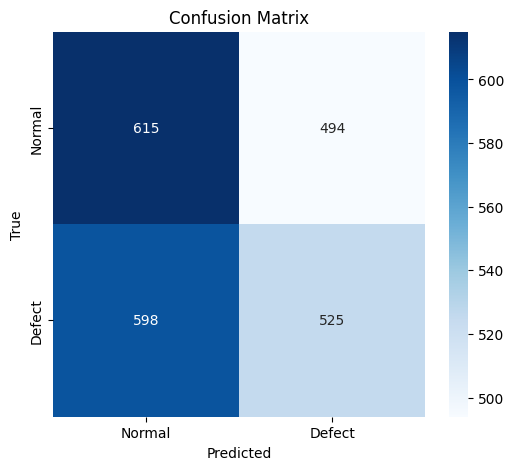

Training Swin Transformer for epoch 2/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [2/60], Loss: 0.7133
Accuracy: 0.5256
Recall: 0.2101
Precision: 0.2107
F1 Score: 0.2095


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


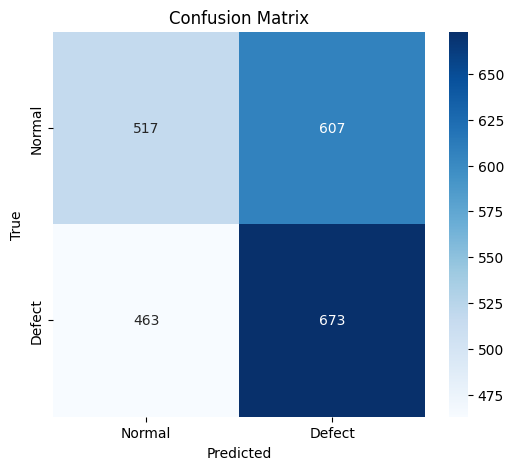

Training Swin Transformer for epoch 3/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [3/60], Loss: 0.7107
Accuracy: 0.5199
Recall: 0.3462
Precision: 0.3470
F1 Score: 0.3433


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


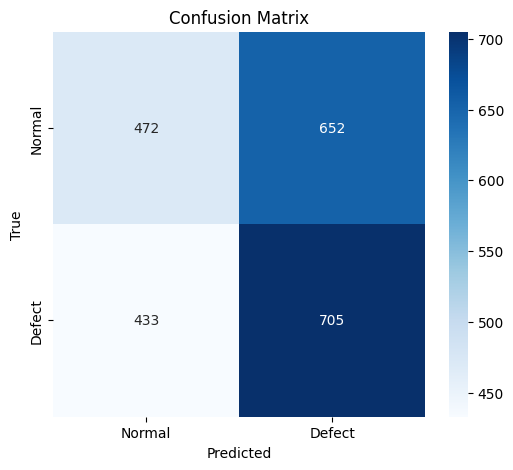

Training Swin Transformer for epoch 4/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [4/60], Loss: 0.7004
Accuracy: 0.5468
Recall: 0.2733
Precision: 0.2737
F1 Score: 0.2734


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


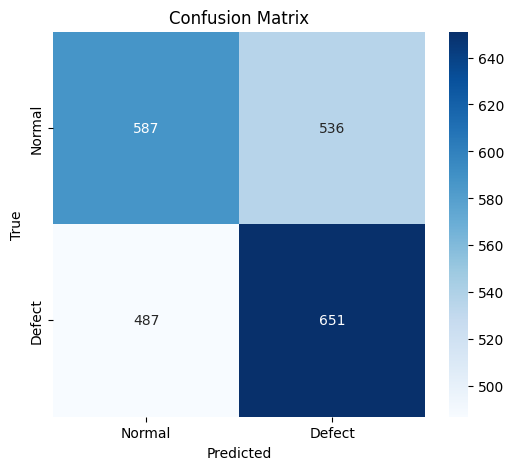

Training Swin Transformer for epoch 5/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [5/60], Loss: 0.6901
Accuracy: 0.5530
Recall: 0.3681
Precision: 0.3713
F1 Score: 0.3623


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


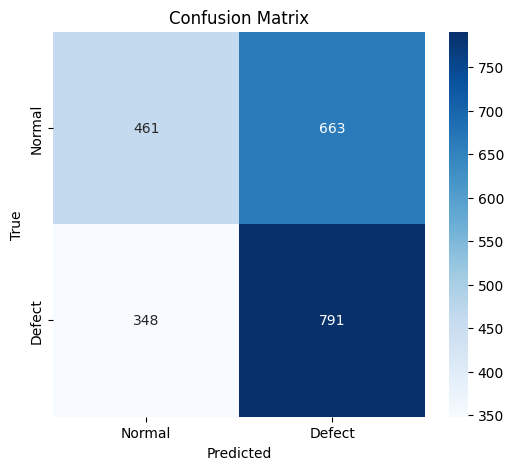

Training Swin Transformer for epoch 6/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [6/60], Loss: 0.6811
Accuracy: 0.5526
Recall: 0.5516
Precision: 0.5569
F1 Score: 0.5415


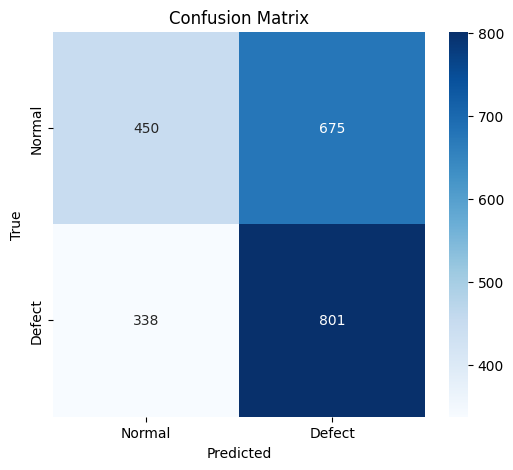

Training Swin Transformer for epoch 7/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [7/60], Loss: 0.6815
Accuracy: 0.5649
Recall: 0.2821
Precision: 0.2840
F1 Score: 0.2800


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


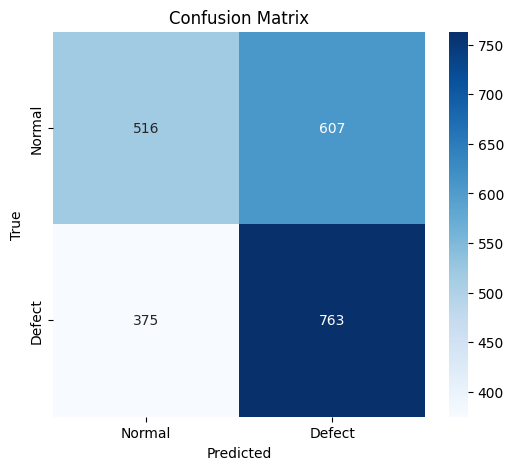

Training Swin Transformer for epoch 8/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [8/60], Loss: 0.6742
Accuracy: 0.5804
Recall: 0.5796
Precision: 0.5851
F1 Score: 0.5732


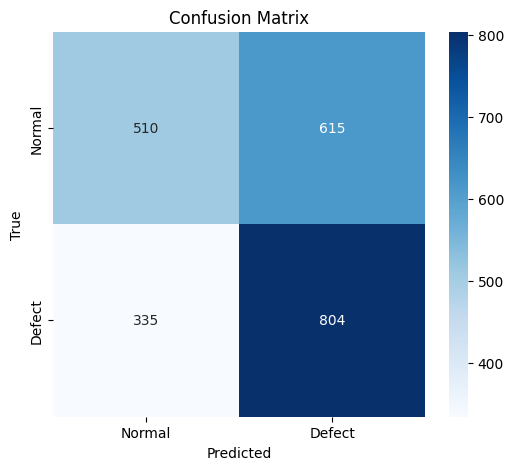

Training Swin Transformer for epoch 9/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [9/60], Loss: 0.6713
Accuracy: 0.5764
Recall: 0.5752
Precision: 0.5889
F1 Score: 0.5589


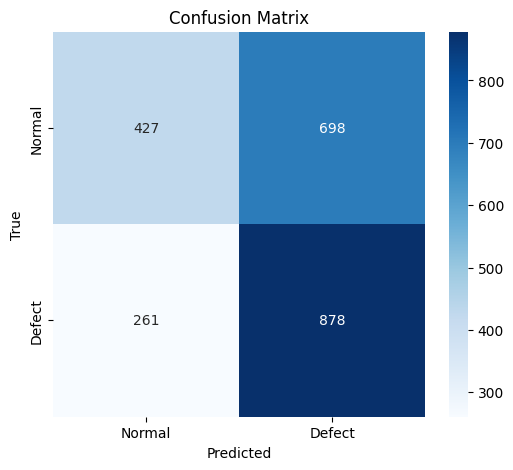

Training Swin Transformer for epoch 10/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [10/60], Loss: 0.6701
Accuracy: 0.5813
Recall: 0.5799
Precision: 0.5994
F1 Score: 0.5591


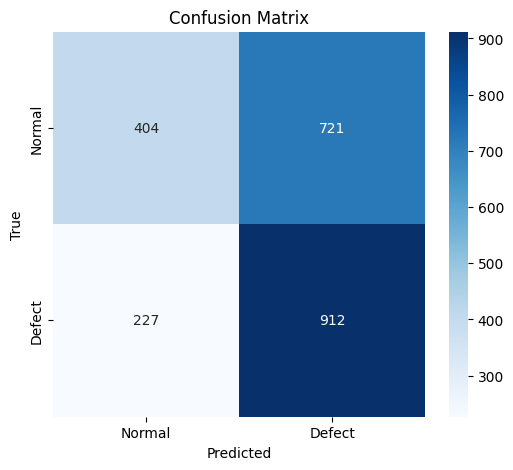

Training Swin Transformer for epoch 11/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [11/60], Loss: 0.6579
Accuracy: 0.5994
Recall: 0.3988
Precision: 0.4108
F1 Score: 0.3888


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


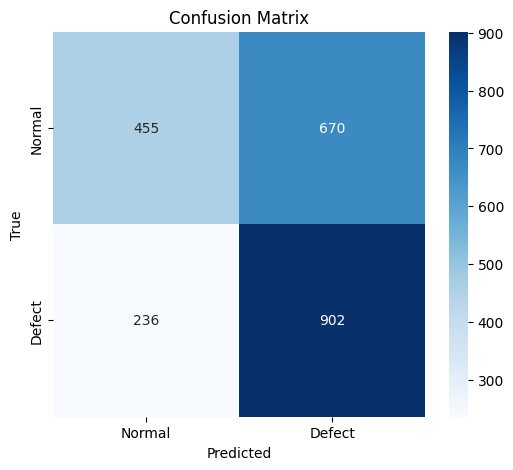

Training Swin Transformer for epoch 12/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [12/60], Loss: 0.6607
Accuracy: 0.5879
Recall: 0.5869
Precision: 0.5965
F1 Score: 0.5770


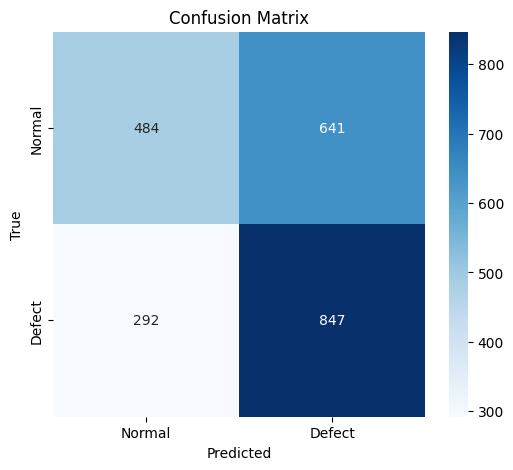

Training Swin Transformer for epoch 13/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [13/60], Loss: 0.6557
Accuracy: 0.5950
Recall: 0.3960
Precision: 0.4040
F1 Score: 0.3886


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


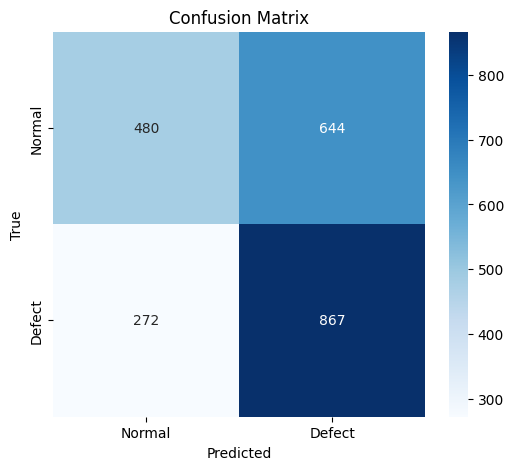

Training Swin Transformer for epoch 14/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [14/60], Loss: 0.6462
Accuracy: 0.6042
Recall: 0.4021
Precision: 0.4111
F1 Score: 0.3950


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


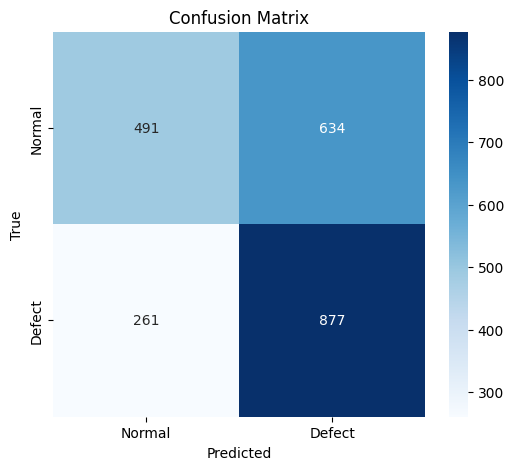

Training Swin Transformer for epoch 15/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [15/60], Loss: 0.6424
Accuracy: 0.6073
Recall: 0.6062
Precision: 0.6237
F1 Score: 0.5924


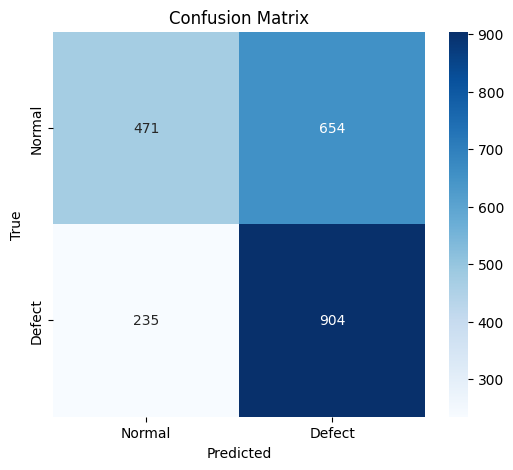

Training Swin Transformer for epoch 16/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [16/60], Loss: 0.6337
Accuracy: 0.6201
Recall: 0.6191
Precision: 0.6338
F1 Score: 0.6090


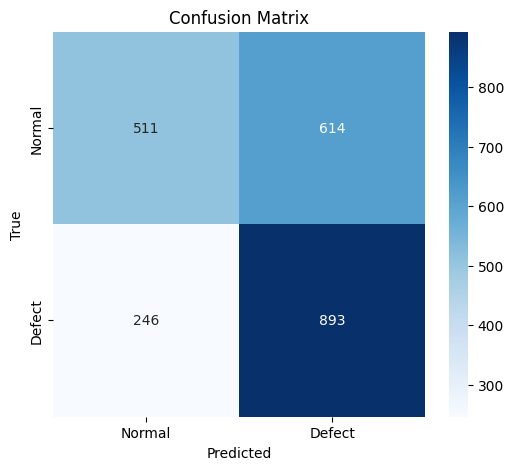

Training Swin Transformer for epoch 17/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [17/60], Loss: 0.6264
Accuracy: 0.6250
Recall: 0.6238
Precision: 0.6452
F1 Score: 0.6102


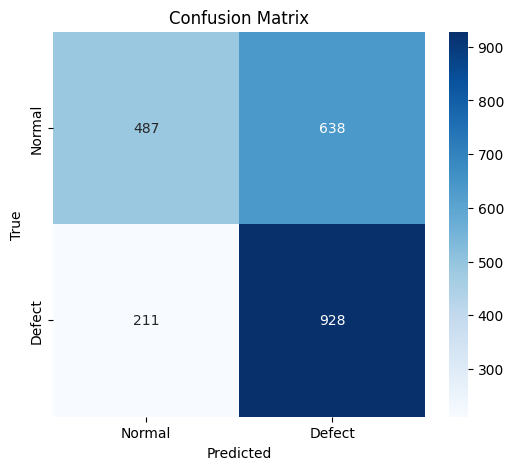

Training Swin Transformer for epoch 18/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [18/60], Loss: 0.6321
Accuracy: 0.6135
Recall: 0.6123
Precision: 0.6334
F1 Score: 0.5971


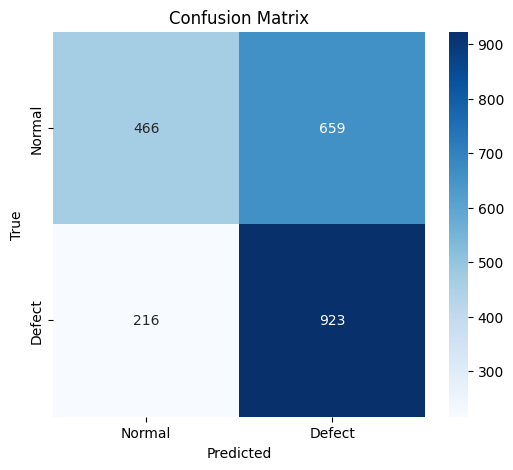

Training Swin Transformer for epoch 19/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [19/60], Loss: 0.6254
Accuracy: 0.6201
Recall: 0.6190
Precision: 0.6387
F1 Score: 0.6057


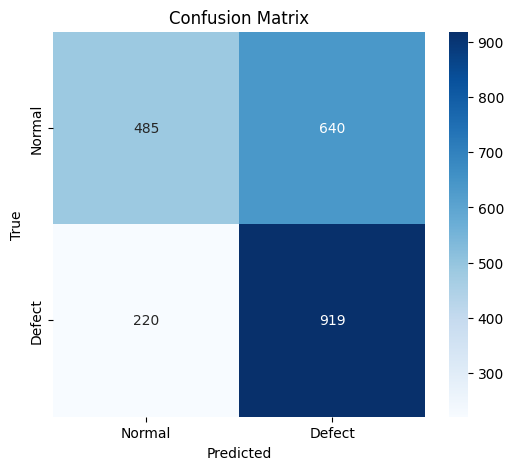

Training Swin Transformer for epoch 20/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [20/60], Loss: 0.6203
Accuracy: 0.6250
Recall: 0.6236
Precision: 0.6536
F1 Score: 0.6052


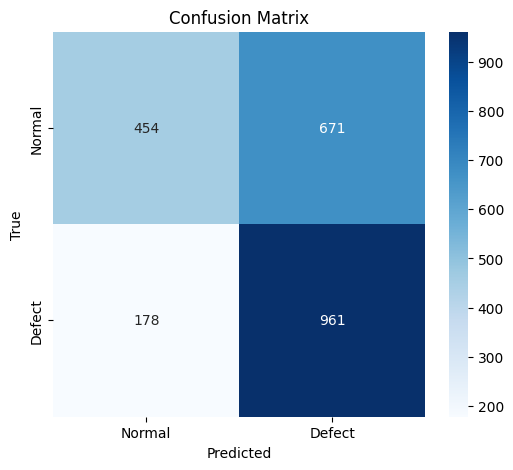

Training Swin Transformer for epoch 21/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [21/60], Loss: 0.6167
Accuracy: 0.6294
Recall: 0.6281
Precision: 0.6582
F1 Score: 0.6103


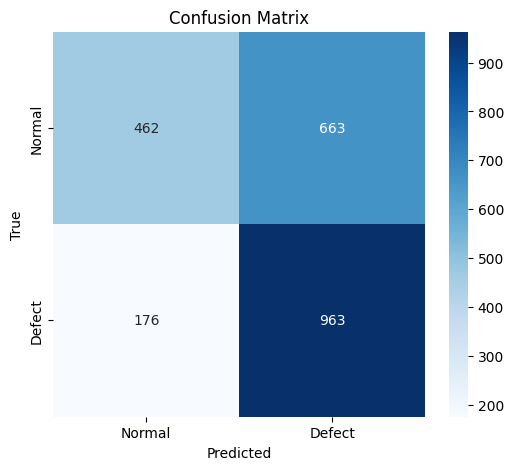

Training Swin Transformer for epoch 22/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [22/60], Loss: 0.6154
Accuracy: 0.6241
Recall: 0.4152
Precision: 0.4360
F1 Score: 0.4026


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


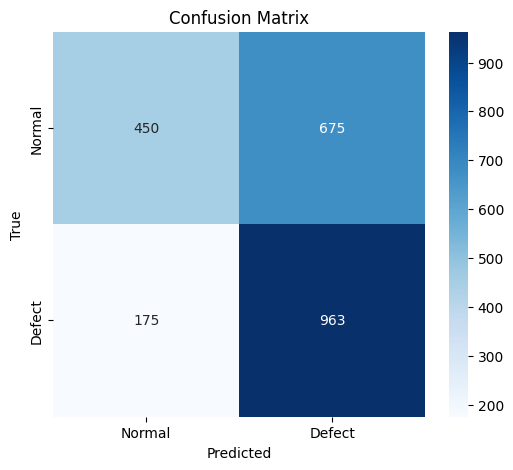

Training Swin Transformer for epoch 23/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [23/60], Loss: 0.6060
Accuracy: 0.6294
Recall: 0.6281
Precision: 0.6576
F1 Score: 0.6107


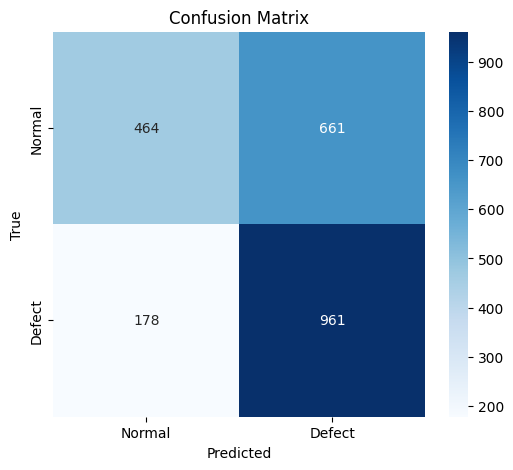

Training Swin Transformer for epoch 24/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [24/60], Loss: 0.6080
Accuracy: 0.6294
Recall: 0.6281
Precision: 0.6573
F1 Score: 0.6108


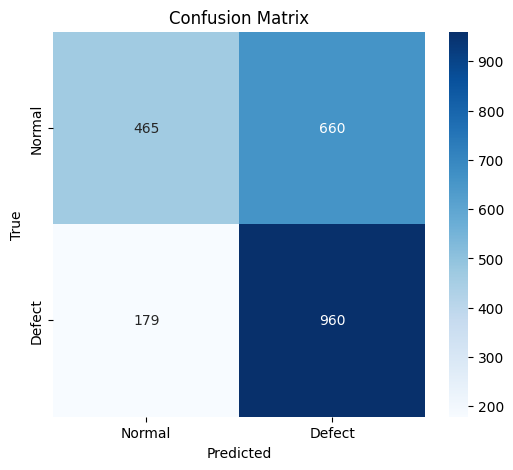

Training Swin Transformer for epoch 25/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [25/60], Loss: 0.5990
Accuracy: 0.6383
Recall: 0.6373
Precision: 0.6531
F1 Score: 0.6283


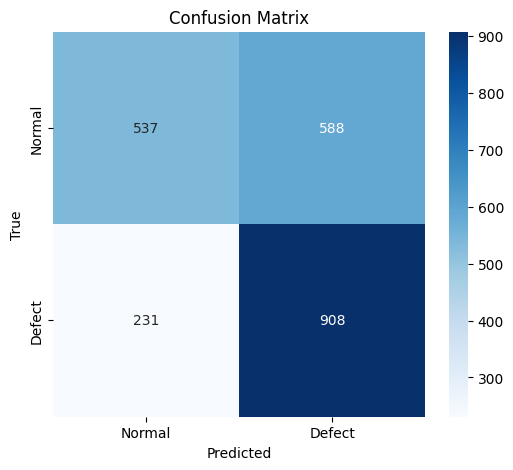

Training Swin Transformer for epoch 26/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [26/60], Loss: 0.6005
Accuracy: 0.6347
Recall: 0.6335
Precision: 0.6585
F1 Score: 0.6192


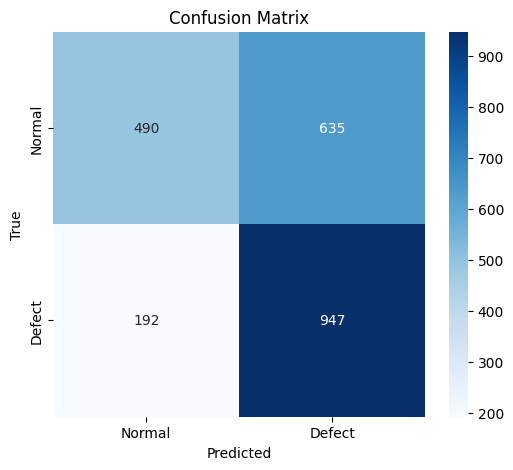

Training Swin Transformer for epoch 27/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [27/60], Loss: 0.5992
Accuracy: 0.6352
Recall: 0.4227
Precision: 0.4363
F1 Score: 0.4151


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


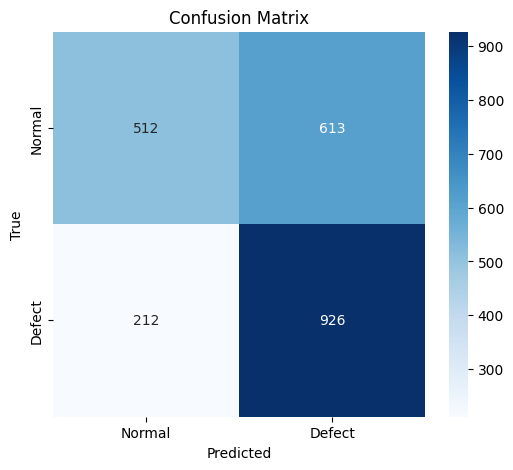

Training Swin Transformer for epoch 28/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [28/60], Loss: 0.5974
Accuracy: 0.6378
Recall: 0.6366
Precision: 0.6593
F1 Score: 0.6240


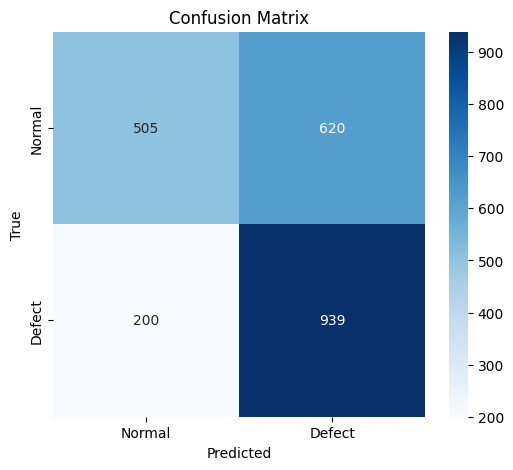

Training Swin Transformer for epoch 29/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [29/60], Loss: 0.6036
Accuracy: 0.6334
Recall: 0.6321
Precision: 0.6587
F1 Score: 0.6169


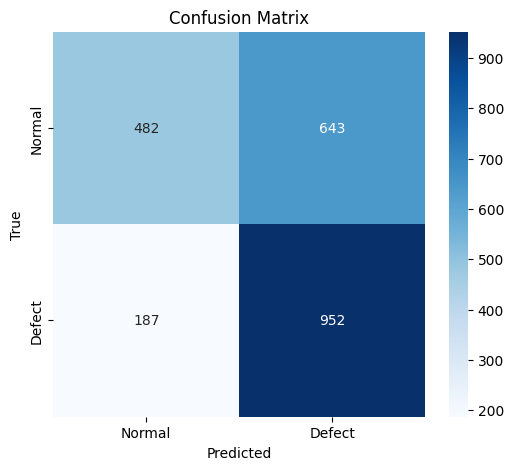

Training Swin Transformer for epoch 30/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [30/60], Loss: 0.5942
Accuracy: 0.6440
Recall: 0.6428
Precision: 0.6700
F1 Score: 0.6287


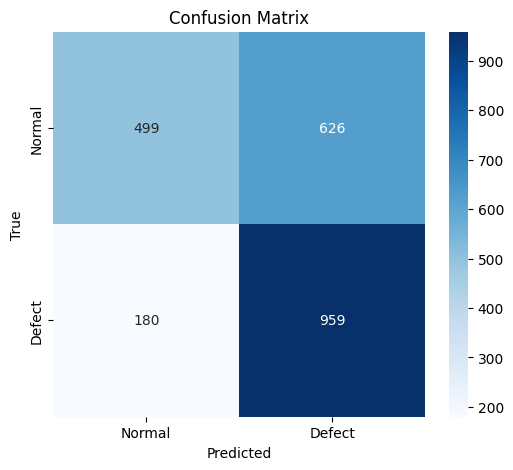

Training Swin Transformer for epoch 31/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [31/60], Loss: 0.5908
Accuracy: 0.6405
Recall: 0.6392
Precision: 0.6689
F1 Score: 0.6234


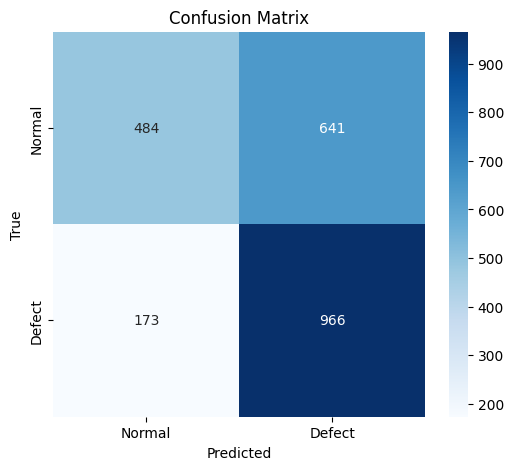

Training Swin Transformer for epoch 32/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [32/60], Loss: 0.5889
Accuracy: 0.6489
Recall: 0.6477
Precision: 0.6734
F1 Score: 0.6349


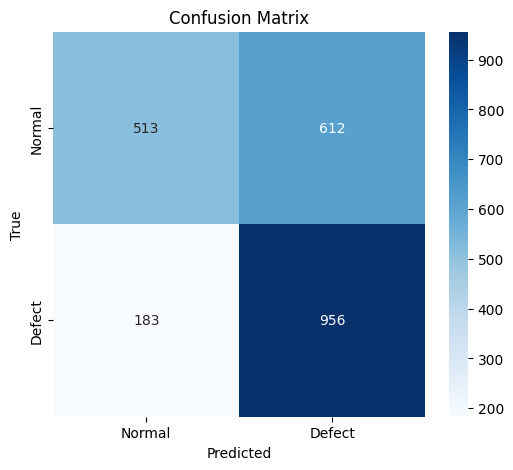

Training Swin Transformer for epoch 33/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [33/60], Loss: 0.5855
Accuracy: 0.6471
Recall: 0.6460
Precision: 0.6687
F1 Score: 0.6343


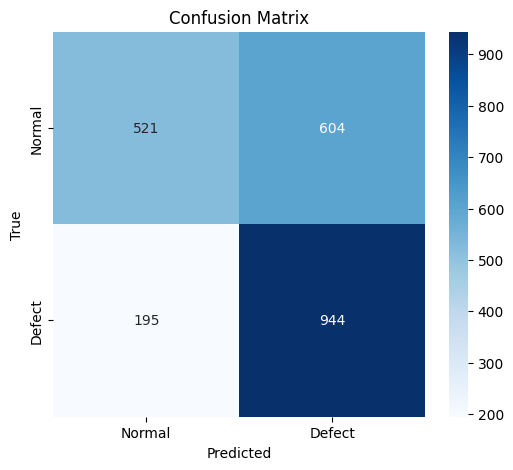

Training Swin Transformer for epoch 34/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [34/60], Loss: 0.5930
Accuracy: 0.6466
Recall: 0.6456
Precision: 0.6646
F1 Score: 0.6357


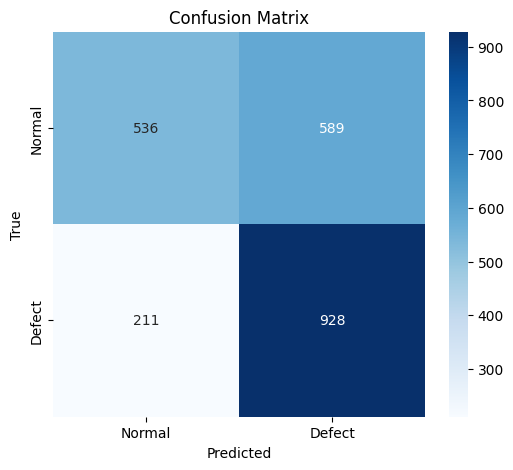

Training Swin Transformer for epoch 35/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [35/60], Loss: 0.5905
Accuracy: 0.6369
Recall: 0.4238
Precision: 0.4412
F1 Score: 0.4144


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


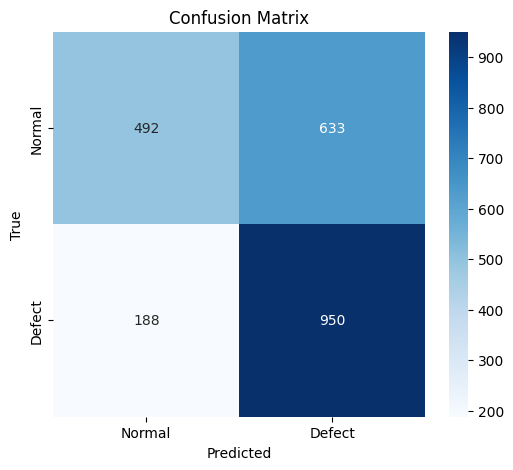

Training Swin Transformer for epoch 36/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [36/60], Loss: 0.5912
Accuracy: 0.6466
Recall: 0.6456
Precision: 0.6636
F1 Score: 0.6363


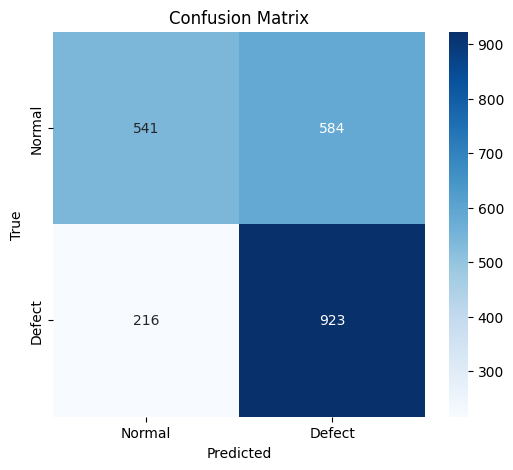

Training Swin Transformer for epoch 37/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [37/60], Loss: 0.5839
Accuracy: 0.6559
Recall: 0.6548
Precision: 0.6782
F1 Score: 0.6438


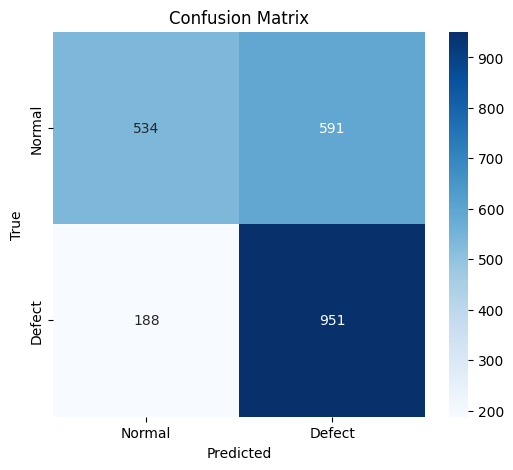

Training Swin Transformer for epoch 38/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [38/60], Loss: 0.5888
Accuracy: 0.6413
Recall: 0.6402
Precision: 0.6615
F1 Score: 0.6287


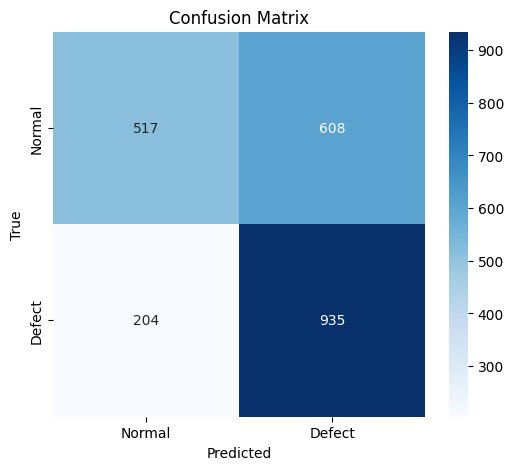

Training Swin Transformer for epoch 39/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [39/60], Loss: 0.5856
Accuracy: 0.6484
Recall: 0.6473
Precision: 0.6692
F1 Score: 0.6362


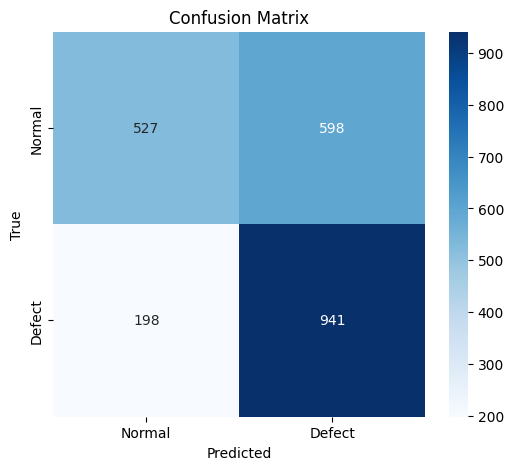

Training Swin Transformer for epoch 40/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [40/60], Loss: 0.5960
Accuracy: 0.6484
Recall: 0.6474
Precision: 0.6656
F1 Score: 0.6381


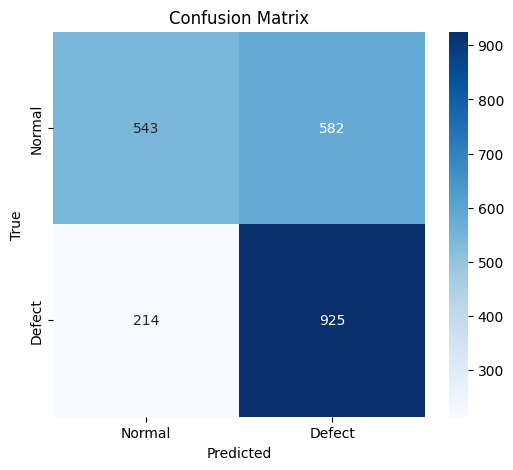

Training Swin Transformer for epoch 41/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [41/60], Loss: 0.5867
Accuracy: 0.6506
Recall: 0.6497
Precision: 0.6645
F1 Score: 0.6422


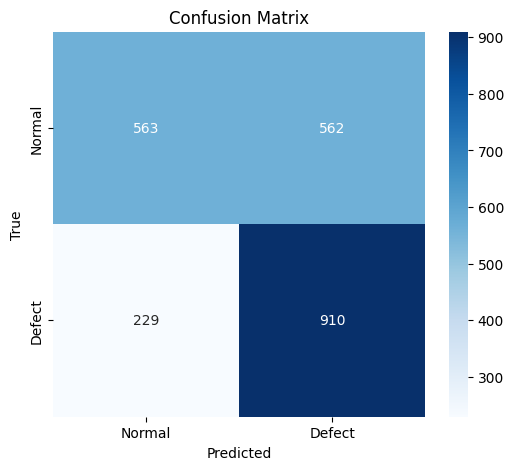

Training Swin Transformer for epoch 42/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [42/60], Loss: 0.5847
Accuracy: 0.6484
Recall: 0.6473
Precision: 0.6673
F1 Score: 0.6372


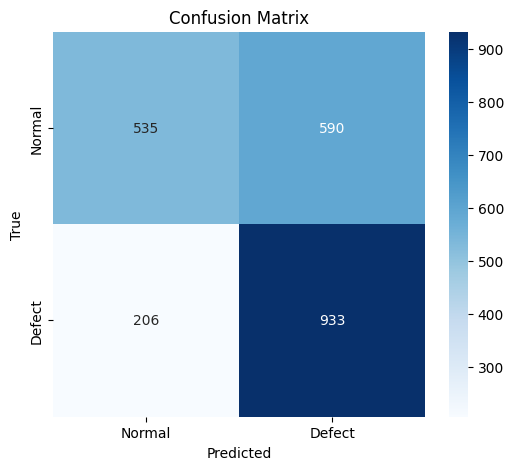

Training Swin Transformer for epoch 43/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [43/60], Loss: 0.5854
Accuracy: 0.6524
Recall: 0.6514
Precision: 0.6674
F1 Score: 0.6435


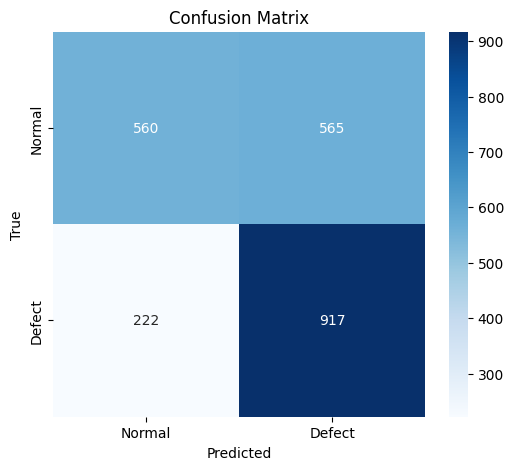

Training Swin Transformer for epoch 44/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [44/60], Loss: 0.5833
Accuracy: 0.6453
Recall: 0.4295
Precision: 0.4425
F1 Score: 0.4230


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


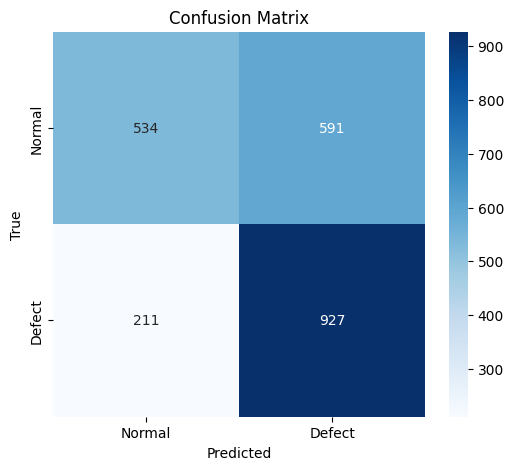

Training Swin Transformer for epoch 45/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [45/60], Loss: 0.5881
Accuracy: 0.6555
Recall: 0.6544
Precision: 0.6768
F1 Score: 0.6438


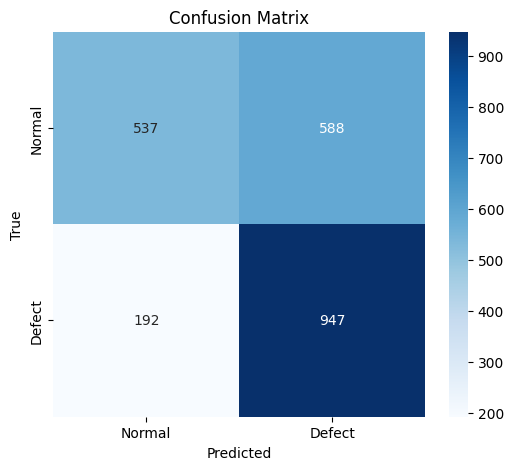

Training Swin Transformer for epoch 46/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [46/60], Loss: 0.5847
Accuracy: 0.6493
Recall: 0.6482
Precision: 0.6679
F1 Score: 0.6383


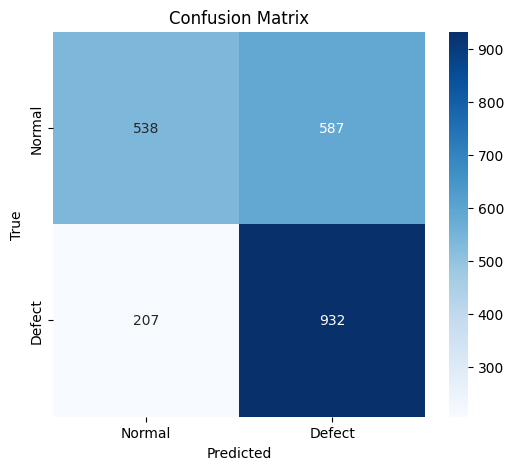

Training Swin Transformer for epoch 47/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [47/60], Loss: 0.5823
Accuracy: 0.6431
Recall: 0.6420
Precision: 0.6626
F1 Score: 0.6310


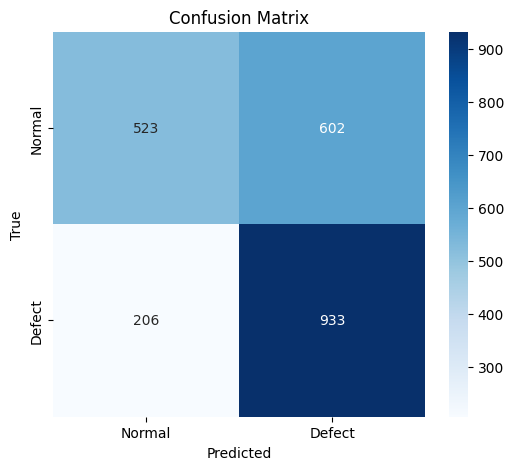

Training Swin Transformer for epoch 48/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [48/60], Loss: 0.5750
Accuracy: 0.6555
Recall: 0.6544
Precision: 0.6775
F1 Score: 0.6434


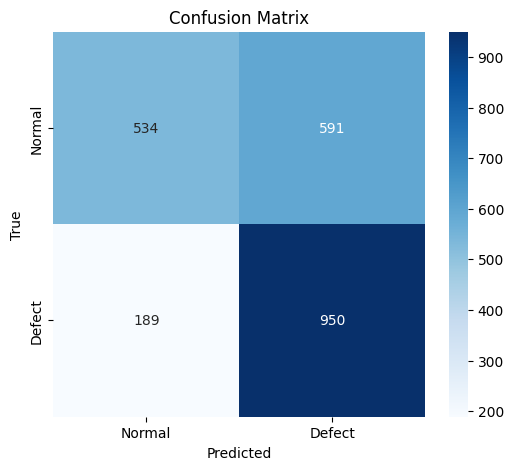

Training Swin Transformer for epoch 49/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [49/60], Loss: 0.5896
Accuracy: 0.6466
Recall: 0.6456
Precision: 0.6640
F1 Score: 0.6361


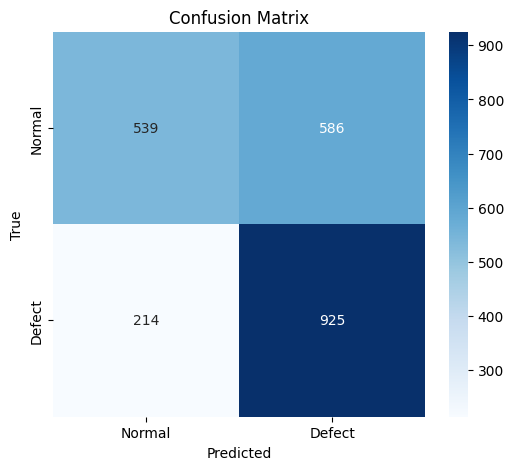

Training Swin Transformer for epoch 50/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [50/60], Loss: 0.5764
Accuracy: 0.6559
Recall: 0.6549
Precision: 0.6728
F1 Score: 0.6464


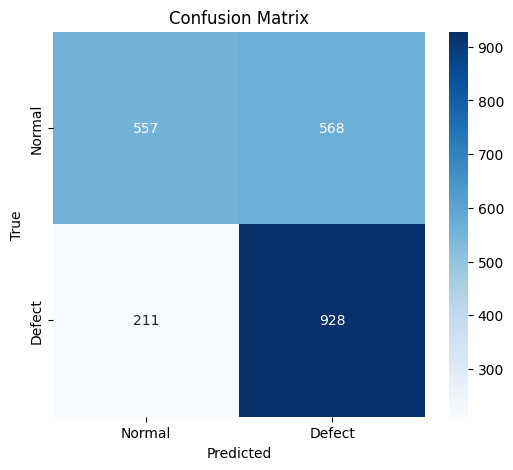

Training Swin Transformer for epoch 51/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [51/60], Loss: 0.5811
Accuracy: 0.6568
Recall: 0.6558
Precision: 0.6755
F1 Score: 0.6465


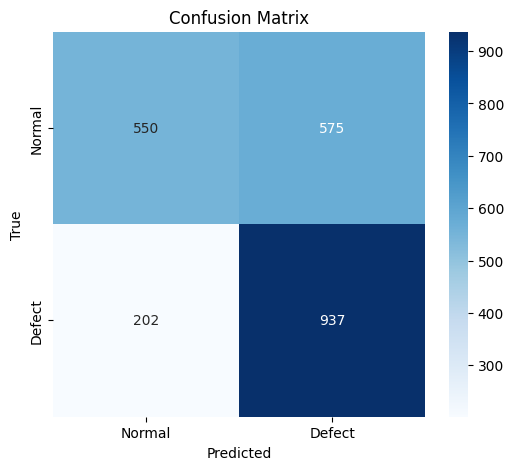

Training Swin Transformer for epoch 52/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [52/60], Loss: 0.5843
Accuracy: 0.6462
Recall: 0.6451
Precision: 0.6649
F1 Score: 0.6349


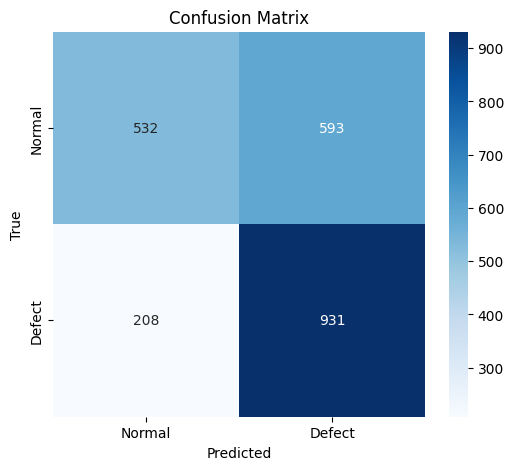

Training Swin Transformer for epoch 53/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [53/60], Loss: 0.5781
Accuracy: 0.6480
Recall: 0.6469
Precision: 0.6669
F1 Score: 0.6367


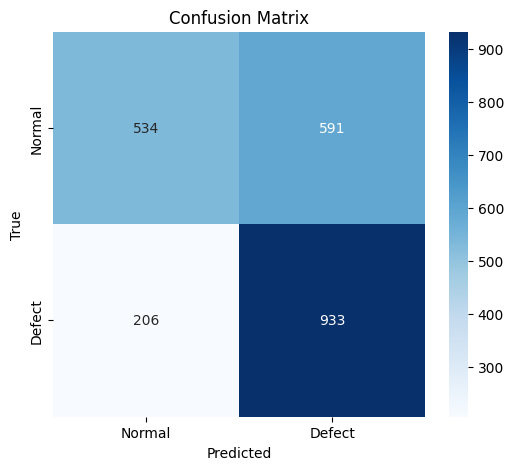

Training Swin Transformer for epoch 54/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [54/60], Loss: 0.5807
Accuracy: 0.6431
Recall: 0.6421
Precision: 0.6582
F1 Score: 0.6334


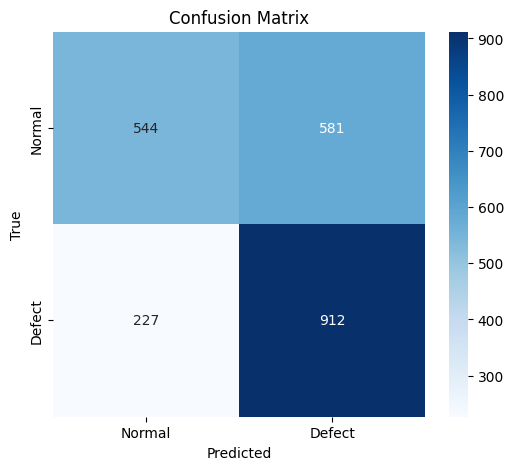

Training Swin Transformer for epoch 55/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [55/60], Loss: 0.5787
Accuracy: 0.6568
Recall: 0.6558
Precision: 0.6751
F1 Score: 0.6467


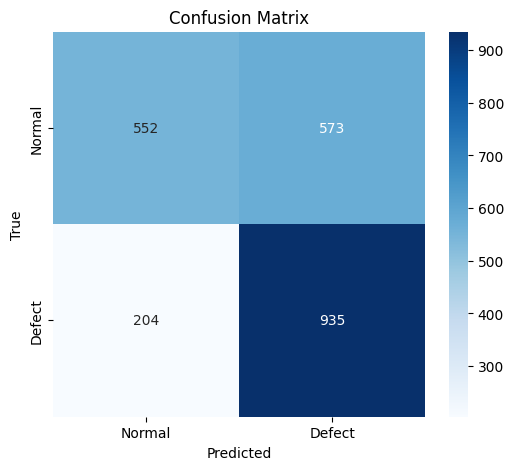

Training Swin Transformer for epoch 56/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [56/60], Loss: 0.5848
Accuracy: 0.6586
Recall: 0.6575
Precision: 0.6802
F1 Score: 0.6471


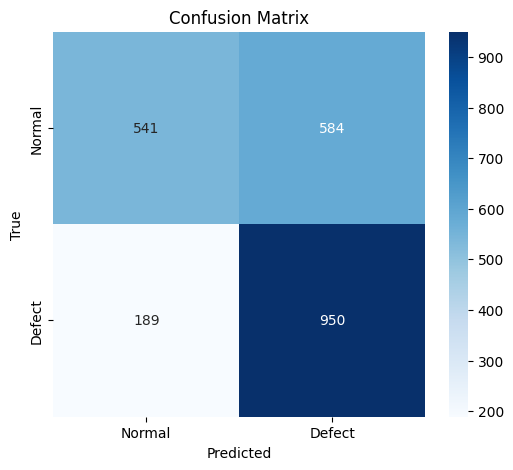

Training Swin Transformer for epoch 57/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [57/60], Loss: 0.5867
Accuracy: 0.6546
Recall: 0.6536
Precision: 0.6732
F1 Score: 0.6441


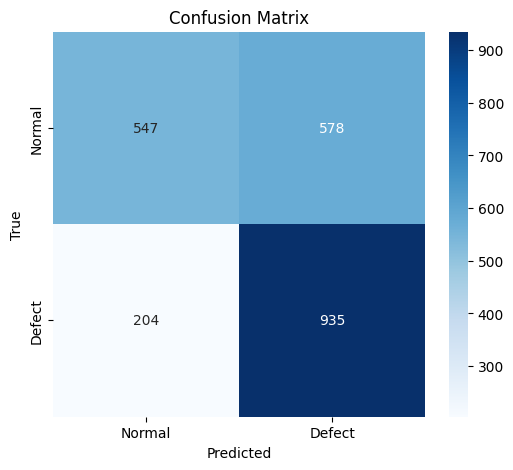

Training Swin Transformer for epoch 58/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [58/60], Loss: 0.5838
Accuracy: 0.6617
Recall: 0.6606
Precision: 0.6819
F1 Score: 0.6511


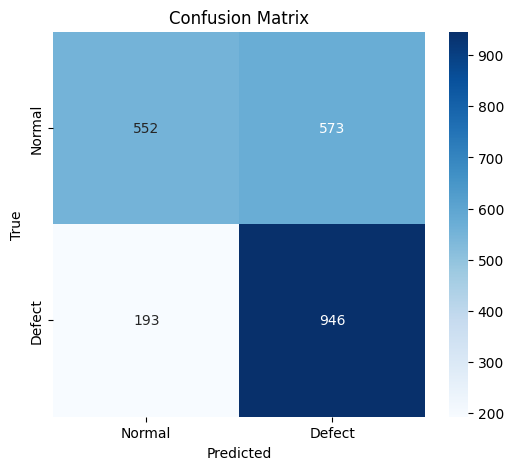

Training Swin Transformer for epoch 59/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [59/60], Loss: 0.5876
Accuracy: 0.6458
Recall: 0.6447
Precision: 0.6632
F1 Score: 0.6350


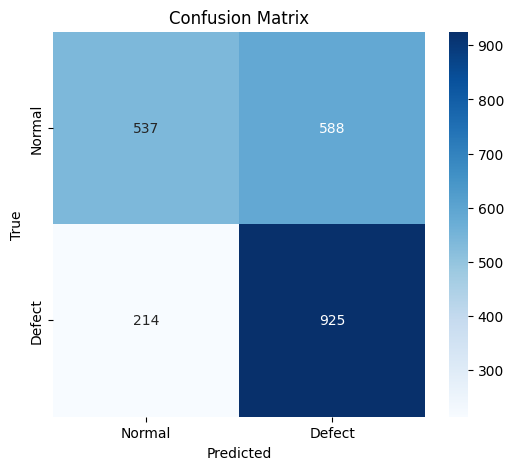

Training Swin Transformer for epoch 60/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-3-b3e70146e603>:147: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [60/60], Loss: 0.5825
Accuracy: 0.6431
Recall: 0.6421
Precision: 0.6606
F1 Score: 0.6321


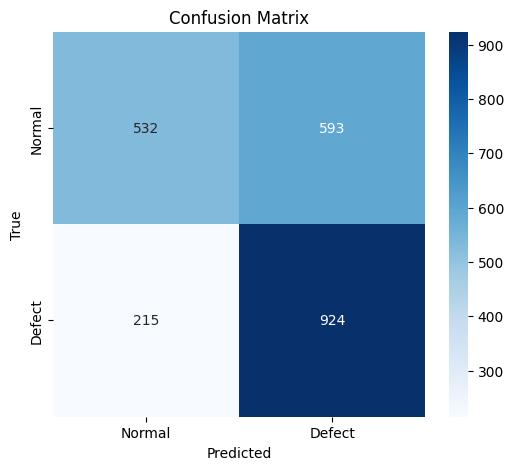

Model saved successfully.


In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import timm
import os
import json
from PIL import Image, ImageDraw
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define dataset paths
base_dir = '/content/drive/MyDrive/guangdong1_round1_train2_20190828'
defect_images_dir = os.path.join(base_dir, 'defect_Images')
normal_images_dir = os.path.join(base_dir, 'normal_Images')
anno_file_path = os.path.join(base_dir, 'Annotations', 'anno_train.json')

# Load the annotations from the JSON file
def load_annotations():
    if not os.path.exists(anno_file_path):
        raise FileNotFoundError(f"Annotation file not found: {anno_file_path}")
    with open(anno_file_path, 'r') as f:
        annotations = json.load(f)
    return annotations

def load_image(image_path, bbox=None):
    image = Image.open(image_path).convert('L')  # Directly load the image in grayscale mode ('L')

    if bbox is not None and isinstance(bbox, list) and len(bbox) > 0:
        draw = ImageDraw.Draw(image)
        if isinstance(bbox[0], list):
            for box in bbox:
                box = [(int(box[0]), int(box[1])), (int(box[0] + box[2]), int(box[1] + box[3]))]
                draw.rectangle(box, outline="red", width=2)
        else:
            bbox = [(int(bbox[0]), int(bbox[1])), (int(bbox[0] + box[2]), int(bbox[1] + bbox[3]))]
            draw.rectangle(bbox, outline="red", width=2)

    return image

class FabricDataset(Dataset):
    def __init__(self, img_paths, labels, bboxes=None, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.bboxes = bboxes
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]
        bbox = self.bboxes.get(os.path.basename(img_path), None) if self.bboxes else None
        image = load_image(img_path, bbox)
        if self.transform:
            image = self.transform(image)
        return image, label

# Load data with bounding boxes
def load_data(annotations):
    img_paths = []
    img_labels = []
    img_bboxes = {}

    for img_name in os.listdir(defect_images_dir):
        img_path = os.path.join(defect_images_dir, img_name)
        img_paths.append(img_path)
        img_annotations = [a for a in annotations if a['name'] == img_name]
        if img_annotations:
            img_labels.append(1)  # Defect label
            img_bboxes[img_name] = [anno['bbox'] for anno in img_annotations]
        else:
            img_labels.append(0)  # Normal label

    for img_name in os.listdir(normal_images_dir):
        img_path = os.path.join(normal_images_dir, img_name)
        img_paths.append(img_path)
        img_labels.append(0)  # Normal label

    return img_paths, img_labels, img_bboxes

def compute_metrics(predictions, true_labels):
    acc = accuracy_score(true_labels, predictions)
    rec = recall_score(true_labels, predictions, average='macro')
    prec = precision_score(true_labels, predictions, average='macro')
    f1 = f1_score(true_labels, predictions, average='macro')
    conf_matrix = confusion_matrix(true_labels, predictions, labels=[0, 1])

    print(f'Accuracy: {acc:.4f}')
    print(f'Recall: {rec:.4f}')
    print(f'Precision: {prec:.4f}')
    print(f'F1 Score: {f1:.4f}')

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Defect'], yticklabels=['Normal', 'Defect'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def train_and_evaluate_swin(model, optimizer, num_epochs=60, batch_size=8, use_mixed_precision=False):
    annotations = load_annotations()
    img_paths, img_labels, img_bboxes = load_data(annotations)

    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ])

    dataset = FabricDataset(img_paths, img_labels, img_bboxes, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))
    scaler = torch.cuda.amp.GradScaler() if use_mixed_precision else None

    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
    reduce_lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)

    for epoch in range(num_epochs):
        print(f"Training Swin Transformer for epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        predictions = []
        true_labels = []

        for batch_imgs, batch_labels in dataloader:
            batch_imgs = batch_imgs.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()

            if use_mixed_precision:
                with autocast():
                    outputs = model(batch_imgs)
                    outputs = global_avg_pool(outputs).view(outputs.size(0), -1)
                    loss = F.cross_entropy(outputs, batch_labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(batch_imgs)
                outputs = global_avg_pool(outputs).view(outputs.size(0), -1)
                loss = F.cross_entropy(outputs, batch_labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * batch_imgs.size(0)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.tolist())
            true_labels.extend(batch_labels.tolist())

        epoch_loss = running_loss / len(dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        compute_metrics(predictions, true_labels)

        # Step the scheduler
        scheduler.step()
        reduce_lr_scheduler.step(epoch_loss)

def initialize_swin_model():
    swin_model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)

    # Modify the first convolution layer to accept grayscale (1-channel) input
    swin_model.patch_embed.proj = torch.nn.Conv2d(1, swin_model.patch_embed.proj.out_channels,
                                                  kernel_size=swin_model.patch_embed.proj.kernel_size,
                                                  stride=swin_model.patch_embed.proj.stride,
                                                  padding=swin_model.patch_embed.proj.padding)

    # Unfreeze all layers for fine-tuning
    for param in swin_model.parameters():
        param.requires_grad = True

    # Update the classifier head to output 2 classes (defect vs. normal)
    swin_model.head = torch.nn.Linear(swin_model.head.in_features, 2)
    return swin_model

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = initialize_swin_model().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)

    # Train and evaluate the Swin Transformer model for 20 epochs with mixed precision if CUDA is available
    train_and_evaluate_swin(model, optimizer, num_epochs=60, use_mixed_precision=(device.type == 'cuda'))

    # Save the trained model
    torch.save(model.state_dict(), '/content/drive/MyDrive/swin_model.pth')
    print("Model saved successfully.")

In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import timm
import os
import json
from PIL import Image, ImageDraw
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sns
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define dataset paths
base_dir = '/content/drive/MyDrive/guangdong1_round1_train2_20190828'
defect_images_dir = os.path.join(base_dir, 'defect_Images')
normal_images_dir = os.path.join(base_dir, 'normal_Images')
anno_file_path = os.path.join(base_dir, 'Annotations', 'anno_train.json')

# Load the annotations from the JSON file
def load_annotations():
    if not os.path.exists(anno_file_path):
        raise FileNotFoundError(f"Annotation file not found: {anno_file_path}")
    with open(anno_file_path, 'r') as f:
        annotations = json.load(f)
    return annotations

def load_image(image_path, bbox=None):
    image = Image.open(image_path).convert('L')  # Directly load the image in grayscale mode ('L')

    if bbox is not None and isinstance(bbox, list) and len(bbox) > 0:
        draw = ImageDraw.Draw(image)
        if isinstance(bbox[0], list):
            for box in bbox:
                box = [(int(box[0]), int(box[1])), (int(box[0] + box[2]), int(box[1] + box[3]))]
                draw.rectangle(box, outline="red", width=2)
        else:
            bbox = [(int(bbox[0]), int(bbox[1])), (int(bbox[0] + box[2]), int(bbox[1] + bbox[3]))]
            draw.rectangle(bbox, outline="red", width=2)

    return image

class FabricDataset(Dataset):
    def __init__(self, img_paths, labels, bboxes=None, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.bboxes = bboxes
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]
        bbox = self.bboxes.get(os.path.basename(img_path), None) if self.bboxes else None
        image = load_image(img_path, bbox)
        if self.transform:
            image = self.transform(image)
        return image, label

# Load data with bounding boxes
def load_data(annotations):
    img_paths = []
    img_labels = []
    img_bboxes = {}

    for img_name in os.listdir(defect_images_dir):
        img_path = os.path.join(defect_images_dir, img_name)
        img_paths.append(img_path)
        img_annotations = [a for a in annotations if a['name'] == img_name]
        if img_annotations:
            img_labels.append(1)  # Defect label
            img_bboxes[img_name] = [anno['bbox'] for anno in img_annotations]
        else:
            img_labels.append(0)  # Normal label

    for img_name in os.listdir(normal_images_dir):
        img_path = os.path.join(normal_images_dir, img_name)
        img_paths.append(img_path)
        img_labels.append(0)  # Normal label

    return img_paths, img_labels, img_bboxes

def compute_metrics(predictions, true_labels):
    acc = accuracy_score(true_labels, predictions)
    rec = recall_score(true_labels, predictions, average='macro')
    prec = precision_score(true_labels, predictions, average='macro')
    f1 = f1_score(true_labels, predictions, average='macro')
    conf_matrix = confusion_matrix(true_labels, predictions, labels=[0, 1])

    print(f'Accuracy: {acc:.4f}')
    print(f'Recall: {rec:.4f}')
    print(f'Precision: {prec:.4f}')
    print(f'F1 Score: {f1:.4f}')


def train_and_evaluate_swin(model, optimizer, num_epochs=60, batch_size=4, use_mixed_precision=False):
    annotations = load_annotations()
    img_paths, img_labels, img_bboxes = load_data(annotations)

    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(5),  # Reduced rotation angle
        transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Reduced jitter intensity
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ])

    dataset = FabricDataset(img_paths, img_labels, img_bboxes, transform=preprocess)

    # Compute class weights and set up weighted sampling to handle class imbalance
    class_sample_count = [len([l for l in img_labels if l == t]) for t in [0, 1]]
    weights = 1. / torch.tensor(class_sample_count, dtype=torch.float)
    sample_weights = [weights[label] for label in img_labels]
    sampler = WeightedRandomSampler(sample_weights, len(sample_weights))

    dataloader = DataLoader(dataset, batch_size=batch_size, sampler=sampler, num_workers=4, pin_memory=True)
    global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))
    scaler = torch.cuda.amp.GradScaler() if use_mixed_precision else None

    # Use a cosine annealing learning rate scheduler
    scheduler = CosineAnnealingLR(optimizer, T_max=10)
    reduce_lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)

    for epoch in range(num_epochs):
        print(f"Training Swin Transformer for epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        predictions = []
        true_labels = []

        for batch_imgs, batch_labels in dataloader:
            batch_imgs = batch_imgs.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()

            if use_mixed_precision:
                with autocast():
                    outputs = model(batch_imgs)
                    outputs = global_avg_pool(outputs).view(outputs.size(0), -1)
                    loss = F.cross_entropy(outputs, batch_labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(batch_imgs)
                outputs = global_avg_pool(outputs).view(outputs.size(0), -1)
                loss = F.cross_entropy(outputs, batch_labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * batch_imgs.size(0)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.tolist())
            true_labels.extend(batch_labels.tolist())

        epoch_loss = running_loss / len(dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        compute_metrics(predictions, true_labels)

        # Step the scheduler
        scheduler.step()
        reduce_lr_scheduler.step(epoch_loss)

def initialize_swin_model():
    swin_model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)

    # Modify the first convolution layer to accept grayscale (1-channel) input
    swin_model.patch_embed.proj = torch.nn.Conv2d(1, swin_model.patch_embed.proj.out_channels,
                                                  kernel_size=swin_model.patch_embed.proj.kernel_size,
                                                  stride=swin_model.patch_embed.proj.stride,
                                                  padding=swin_model.patch_embed.proj.padding)

    # Unfreeze all layers for fine-tuning
    for param in swin_model.parameters():
        param.requires_grad = True

    # Update the classifier head to output 2 classes (defect vs. normal)
    swin_model.head = torch.nn.Linear(swin_model.head.in_features, 2)
    return swin_model

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = initialize_swin_model().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)

    # Train and evaluate the Swin Transformer model for 60 epochs with mixed precision if CUDA is available
    train_and_evaluate_swin(model, optimizer, num_epochs=60, use_mixed_precision=(device.type == 'cuda'))

    # Save the trained model
    torch.save(model.state_dict(), '/content/drive/MyDrive/swin.pth')
    print("Model saved successfully.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training Swin Transformer for epoch 1/60


<ipython-input-6-ffdc6f9ea1f5>:128: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_mixed_precision else None
<ipython-input-6-ffdc6f9ea1f5>:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/60], Loss: 1.8057
Accuracy: 0.4572
Recall: 0.1297
Precision: 0.1464
F1 Score: 0.0997
Training Swin Transformer for epoch 2/60


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-6-ffdc6f9ea1f5>:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [2/60], Loss: 1.9464
Accuracy: 0.4947
Recall: 0.1649
Precision: 0.1436
F1 Score: 0.1115
Training Swin Transformer for epoch 3/60


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-6-ffdc6f9ea1f5>:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [3/60], Loss: 1.9475
Accuracy: 0.4925
Recall: 0.1411
Precision: 0.1186
F1 Score: 0.0951
Training Swin Transformer for epoch 4/60


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-6-ffdc6f9ea1f5>:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [4/60], Loss: 1.9503
Accuracy: 0.4973
Recall: 0.1422
Precision: 0.1666
F1 Score: 0.0964
Training Swin Transformer for epoch 5/60


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-6-ffdc6f9ea1f5>:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [5/60], Loss: 1.9504
Accuracy: 0.5093
Recall: 0.2501
Precision: 0.3092
F1 Score: 0.1719
Training Swin Transformer for epoch 6/60


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-6-ffdc6f9ea1f5>:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [6/60], Loss: 1.9756
Accuracy: 0.4982
Recall: 0.1654
Precision: 0.1461
F1 Score: 0.1118
Training Swin Transformer for epoch 7/60


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-6-ffdc6f9ea1f5>:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [7/60], Loss: 1.9634
Accuracy: 0.4991
Recall: 0.1996
Precision: 0.2001
F1 Score: 0.1340
Training Swin Transformer for epoch 8/60


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-6-ffdc6f9ea1f5>:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [8/60], Loss: 1.9923
Accuracy: 0.4929
Recall: 0.1988
Precision: 0.0991
F1 Score: 0.1323
Training Swin Transformer for epoch 9/60


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-6-ffdc6f9ea1f5>:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [9/60], Loss: 1.9777
Accuracy: 0.5159
Recall: 0.1428
Precision: 0.2168
F1 Score: 0.0981
Training Swin Transformer for epoch 10/60


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-6-ffdc6f9ea1f5>:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [10/60], Loss: 1.9773
Accuracy: 0.5049
Recall: 0.1657
Precision: 0.1178
F1 Score: 0.1121
Training Swin Transformer for epoch 11/60


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-6-ffdc6f9ea1f5>:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [11/60], Loss: 1.9521
Accuracy: 0.4929
Recall: 0.3333
Precision: 0.4976
F1 Score: 0.2211
Training Swin Transformer for epoch 12/60


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-6-ffdc6f9ea1f5>:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [12/60], Loss: 2.0026
Accuracy: 0.4801
Recall: 0.1417
Precision: 0.1167
F1 Score: 0.0931
Training Swin Transformer for epoch 13/60


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-6-ffdc6f9ea1f5>:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [13/60], Loss: 1.9659
Accuracy: 0.5000
Recall: 0.1665
Precision: 0.2084
F1 Score: 0.1120
Training Swin Transformer for epoch 14/60


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-6-ffdc6f9ea1f5>:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [14/60], Loss: 1.9708
Accuracy: 0.4947
Recall: 0.1665
Precision: 0.1938
F1 Score: 0.1110
Training Swin Transformer for epoch 15/60


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-6-ffdc6f9ea1f5>:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [15/60], Loss: 2.1042
Accuracy: 0.4761
Recall: 0.1397
Precision: 0.1011
F1 Score: 0.0932
Training Swin Transformer for epoch 16/60


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-6-ffdc6f9ea1f5>:148: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import timm
import os
import json
from PIL import Image, ImageDraw
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sns
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler, random_split
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast
import numpy as np
from sklearn.utils.class_weight import compute_class_weight

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define dataset paths
base_dir = '/content/drive/MyDrive/guangdong1_round1_train2_20190828'
defect_images_dir = os.path.join(base_dir, 'defect_Images')
normal_images_dir = os.path.join(base_dir, 'normal_Images')
anno_file_path = os.path.join(base_dir, 'Annotations', 'anno_train.json')

# Load the annotations from the JSON file
def load_annotations():
    if not os.path.exists(anno_file_path):
        raise FileNotFoundError(f"Annotation file not found: {anno_file_path}")
    with open(anno_file_path, 'r') as f:
        annotations = json.load(f)
    return annotations

def load_image(image_path, bbox=None):
    image = Image.open(image_path).convert('L')  # Load image in grayscale

    if bbox is not None and isinstance(bbox, list) and len(bbox) > 0:
        draw = ImageDraw.Draw(image)
        if isinstance(bbox[0], list):
            for box in bbox:
                box_coords = [(int(box[0]), int(box[1])),
                              (int(box[0] + box[2]), int(box[1] + box[3]))]
                draw.rectangle(box_coords, outline="red", width=2)
        else:
            box_coords = [(int(bbox[0]), int(bbox[1])),
                          (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))]
            draw.rectangle(box_coords, outline="red", width=2)

    return image

class FabricDataset(Dataset):
    def __init__(self, img_paths, labels, bboxes=None, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.bboxes = bboxes
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]
        bbox = self.bboxes.get(os.path.basename(img_path), None) if self.bboxes else None
        image = load_image(img_path, bbox)
        if self.transform:
            image = self.transform(image)
        return image, label

# Load data with bounding boxes
def load_data(annotations):
    img_paths = []
    img_labels = []
    img_bboxes = {}

    # Defect images
    for img_name in os.listdir(defect_images_dir):
        img_path = os.path.join(defect_images_dir, img_name)
        img_paths.append(img_path)
        img_annotations = [a for a in annotations if a['name'] == img_name]
        if img_annotations:
            img_labels.append(1)  # Defect label
            img_bboxes[img_name] = [anno['bbox'] for anno in img_annotations]
        else:
            img_labels.append(0)  # Normal label

    # Normal images
    for img_name in os.listdir(normal_images_dir):
        img_path = os.path.join(normal_images_dir, img_name)
        img_paths.append(img_path)
        img_labels.append(0)  # Normal label

    return img_paths, img_labels, img_bboxes

def compute_metrics(predictions, true_labels):
    acc = accuracy_score(true_labels, predictions)
    rec = recall_score(true_labels, predictions, average='macro', zero_division=1)
    prec = precision_score(true_labels, predictions, average='macro', zero_division=1)
    f1 = f1_score(true_labels, predictions, average='macro', zero_division=1)
    conf_matrix = confusion_matrix(true_labels, predictions, labels=[0, 1])

    print(f'Accuracy: {acc:.4f}')
    print(f'Recall: {rec:.4f}')
    print(f'Precision: {prec:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print("Confusion Matrix:")
    print(conf_matrix)


# Define Focal Loss for class imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

# Custom Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def check(self, val_loss):
        if self.best_loss is None or (self.best_loss - val_loss) > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                return True
        return False

def train_and_evaluate_swin(model, optimizer, criterion, scheduler, num_epochs=60, batch_size=4, use_mixed_precision=False, patience=5):
    annotations = load_annotations()
    img_paths, img_labels, img_bboxes = load_data(annotations)

    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.RandomRotation(15),  # Increased rotation angle for better augmentation
        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Increased jitter intensity
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ])

    # Create the full dataset
    full_dataset = FabricDataset(img_paths, img_labels, img_bboxes, transform=preprocess)

    # Split dataset into training and validation (e.g., 80% train, 20% val)
    val_size = int(0.2 * len(full_dataset))
    train_size = len(full_dataset) - val_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    # Compute class weights based on the training set
    train_labels = [train_dataset.dataset.labels[idx] for idx in train_dataset.indices]
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
    class_weights_tensor = torch.FloatTensor(class_weights).to(device)

    # Define loss function with class weights
    #criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
    # Alternatively, use Focal Loss
    #criterion = FocalLoss(alpha=1, gamma=2).to(device)

    # Calculate weights for WeightedRandomSampler
    class_sample_count = [train_labels.count(t) for t in np.unique(train_labels)]
    weights = 1. / torch.tensor(class_sample_count, dtype=torch.float)
    sample_weights = [weights[label] for label in train_labels]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    scaler = GradScaler() if use_mixed_precision else None

    # Initialize Early Stopping
    early_stopper = EarlyStopping(patience=patience, min_delta=0.0)

    for epoch in range(num_epochs):
        print(f"\nEpoch [{epoch+1}/{num_epochs}]")
        model.train()
        running_loss = 0.0
        predictions = []
        true_labels = []

        for batch_imgs, batch_labels in train_loader:
            batch_imgs = batch_imgs.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()

            if use_mixed_precision and scaler is not None:
                with autocast(dtype=torch.float32):
                    outputs = model(batch_imgs)
                    loss = criterion(outputs, batch_labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(batch_imgs)
                loss = criterion(outputs, batch_labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * batch_imgs.size(0)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.cpu().tolist())
            true_labels.extend(batch_labels.cpu().tolist())

        epoch_loss = running_loss / train_size
        print(f"Training Loss: {epoch_loss:.4f}")
        compute_metrics(predictions, true_labels)

        # Validation Phase
        model.eval()
        val_running_loss = 0.0
        val_predictions = []
        val_true_labels = []

        with torch.no_grad():
            for batch_imgs, batch_labels in val_loader:
                batch_imgs = batch_imgs.to(device)
                batch_labels = batch_labels.to(device)

                with autocast(dtype=torch.float32):
                    outputs = model(batch_imgs)
                    loss = criterion(outputs, batch_labels)

                val_running_loss += loss.item() * batch_imgs.size(0)
                _, preds = torch.max(outputs, 1)
                val_predictions.extend(preds.cpu().tolist())
                val_true_labels.extend(batch_labels.cpu().tolist())

        val_epoch_loss = val_running_loss / val_size
        print(f"Validation Loss: {val_epoch_loss:.4f}")
        compute_metrics(val_predictions, val_true_labels)

        # Step the scheduler
        scheduler.step(val_epoch_loss)

        # Check early stopping
        if early_stopper.check(val_epoch_loss):
            print("Stopping training early.")
            break

    print("Training completed.")

def initialize_swin_model():
    swin_model = timm.create_model('swin_base_patch4_window7_224', pretrained=True)

    # Modify the first convolution layer to accept grayscale (1-channel) input
    swin_model.patch_embed.proj = torch.nn.Conv2d(
        1,
        swin_model.patch_embed.proj.out_channels,
        kernel_size=swin_model.patch_embed.proj.kernel_size,
        stride=swin_model.patch_embed.proj.stride,
        padding=swin_model.patch_embed.proj.padding
    )

    # Unfreeze all layers for fine-tuning
    for param in swin_model.parameters():
        param.requires_grad = True

    # Update the classifier head to output 2 classes (defect vs. normal)
    swin_model.head = torch.nn.Linear(swin_model.head.in_features, 2)
    return swin_model

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    model = initialize_swin_model().to(device)

    # Compute class weights for Focal Loss or CrossEntropyLoss
    annotations = load_annotations()
    img_paths, img_labels, img_bboxes = load_data(annotations)
    labels = img_labels

    # Compute class weights
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(labels), y=labels)
    class_weights_tensor = torch.FloatTensor(class_weights).to(device)

    # Define optimizer
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=0.01)

    # Define learning rate scheduler
    scheduler = CosineAnnealingLR(optimizer, T_max=10)

    # Initialize Focal Loss
    criterion = FocalLoss(alpha=1, gamma=2).to(device)

    # Train and evaluate the Swin Transformer model for 60 epochs with mixed precision if CUDA is available
    train_and_evaluate_swin(
        model,
        optimizer,
        criterion,
        scheduler,
        num_epochs=60,
        batch_size=4,
        use_mixed_precision=(device.type == 'cuda'),
        patience=10  # Increased patience for early stopping
    )

    # Save the trained model
    torch.save(model.state_dict(), '/content/drive/MyDrive/swin.pth')
    print("Model saved successfully.")


In [ ]:
# Install the necessary libraries
!pip install timm
!pip install optuna # Install the Optuna library

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import timm
import os
import json
from PIL import Image
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sns
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler, random_split
from torch.cuda.amp import GradScaler, autocast
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import optuna  # Import Optuna
from google.colab import drive
drive.mount('/content/drive')

# Define paths to your dataset
base_dir = '/content/drive/MyDrive/guangdong1_round1_train2_20190828'
defect_images_dir = os.path.join(base_dir, 'defect_Images')
normal_images_dir = os.path.join(base_dir, 'normal_Images')
anno_file_path = os.path.join(base_dir, 'Annotations', 'anno_train.json')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

# Load the annotations from the JSON file
def load_annotations():
    if not os.path.exists(anno_file_path):
        raise FileNotFoundError(f"Annotation file not found: {anno_file_path}")
    with open(anno_file_path, 'r') as f:
        annotations = json.load(f)
    return annotations

# Load image as a 3-channel RGB tensor
def load_image(image_path):
    image = Image.open(image_path).convert('L')  # Load image in grayscale mode
    # Convert grayscale to RGB by duplicating the channel
    image = Image.merge("RGB", (image, image, image))  # Merge the single channel to three channels
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to expected input size
        transforms.ToTensor(),  # Convert PIL image to tensor
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for RGB
    ])
    return transform(image)

# Custom Dataset class
class FabricDataset(Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]
        image = load_image(img_path)
        return image, label

# Load data with bounding boxes
def load_data(annotations):
    img_paths = []
    img_labels = []
    img_bboxes = {}

    # Defect images
    for img_name in os.listdir(defect_images_dir):
        img_path = os.path.join(defect_images_dir, img_name)
        img_paths.append(img_path)
        img_annotations = [a for a in annotations if a['name'] == img_name]
        if img_annotations:
            img_labels.append(1)  # Defect label
            img_bboxes[img_name] = [anno['bbox'] for anno in img_annotations]
        else:
            img_labels.append(0)  # Normal label

    # Normal images
    for img_name in os.listdir(normal_images_dir):
        img_path = os.path.join(normal_images_dir, img_name)
        img_paths.append(img_path)
        img_labels.append(0)  # Normal label

    return img_paths, img_labels, img_bboxes

def compute_metrics(predictions, true_labels):
    acc = accuracy_score(true_labels, predictions)
    rec = recall_score(true_labels, predictions, average='macro', zero_division=1)
    prec = precision_score(true_labels, predictions, average='macro', zero_division=1)
    f1 = f1_score(true_labels, predictions, average='macro', zero_division=1)
    conf_matrix = confusion_matrix(true_labels, predictions, labels=[0, 1])

    print(f'Accuracy: {acc:.4f}')
    print(f'Recall: {rec:.4f}')
    print(f'Precision: {prec:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print("Confusion Matrix:")
    print(conf_matrix)

# Define Focal Loss for class imbalance
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

# Custom Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0

    def check(self, val_loss):
        if self.best_loss is None or (self.best_loss - val_loss) > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            return False
        else:
            self.counter += 1
            if self.counter >= self.patience:
                print("Early stopping triggered")
                return True
        return False

def train_and_evaluate_swin(trial):
    # Hyperparameter tuning
    lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
    batch_size = trial.suggest_int('batch_size', 4, 16)
    num_epochs = trial.suggest_int('num_epochs', 5, 20)

    annotations = load_annotations()
    img_paths, img_labels, img_bboxes = load_data(annotations)

    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    full_dataset = FabricDataset(img_paths, img_labels, transform=preprocess)
    val_size = int(0.2 * len(full_dataset))
    train_size = len(full_dataset) - val_size
    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

    train_labels = [train_dataset.dataset.labels[idx] for idx in train_dataset.indices]
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels), y=train_labels)
    class_weights_tensor = torch.FloatTensor(class_weights).to(device)

    class_sample_count = [train_labels.count(t) for t in np.unique(train_labels)]
    weights = 1. / torch.tensor(class_sample_count, dtype=torch.float)
    sample_weights = [weights[label] for label in train_labels]
    sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=sampler, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)

    model = timm.create_model('swin_small_patch4_window7_224', pretrained=True, num_classes=2).to(device)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
    criterion = FocalLoss()

    scaler = GradScaler()
    early_stopper = EarlyStopping(patience=5)

    train_losses, val_losses = [], []
    predictions, true_labels = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_imgs, batch_labels in train_loader:
            batch_imgs = batch_imgs.to(device)
            batch_labels = batch_labels.to(device)

            with autocast():
                outputs = model(batch_imgs)
                loss = criterion(outputs, batch_labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running_loss += loss.item() * batch_imgs.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(train_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}')

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for batch_imgs, batch_labels in val_loader:
                batch_imgs = batch_imgs.to(device)
                batch_labels = batch_labels.to(device)

                with autocast():
                    outputs = model(batch_imgs)
                    loss = criterion(outputs, batch_labels)

                val_loss += loss.item() * batch_imgs.size(0)
                predictions.extend(torch.argmax(outputs, dim=1).cpu().numpy())
                true_labels.extend(batch_labels.cpu().numpy())

        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        print(f'Epoch [{epoch + 1}/{num_epochs}], Validation Loss: {val_loss:.4f}')

        if early_stopper.check(val_loss):
            break

    # Compute metrics
    compute_metrics(predictions, true_labels)

    return val_loss  # Return validation loss for Optuna

# Start Hyperparameter Tuning with Optuna
study = optuna.create_study(direction='minimize')
study.optimize(train_and_evaluate_swin, n_trials=20)

print("Best hyperparameters:")
print(study.best_params)
print("Best validation loss:")
print(study.best_value)


[I 2024-09-29 02:54:39,575] A new study created in memory with name: no-name-7a3ae0cd-3c65-4c11-bba9-ebbfe0377a28


Mounted at /content/drive
Using GPU: Tesla T4


<ipython-input-6-da5c5d0a4dbf>:155: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/200M [00:00<?, ?B/s]

<ipython-input-6-da5c5d0a4dbf>:190: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-6-da5c5d0a4dbf>:203: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/13], Train Loss: 0.1210


<ipython-input-6-da5c5d0a4dbf>:224: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/13], Validation Loss: 0.0936
Epoch [2/13], Train Loss: 0.0788
Epoch [2/13], Validation Loss: 0.0846
Epoch [3/13], Train Loss: 0.0583
Epoch [3/13], Validation Loss: 0.0739
Epoch [4/13], Train Loss: 0.0373
Epoch [4/13], Validation Loss: 0.1020
Epoch [5/13], Train Loss: 0.0328
Epoch [5/13], Validation Loss: 0.0990
Epoch [6/13], Train Loss: 0.0216
Epoch [6/13], Validation Loss: 0.0948
Epoch [7/13], Train Loss: 0.0217
Epoch [7/13], Validation Loss: 0.1080
Epoch [8/13], Train Loss: 0.0183


[I 2024-09-29 03:20:28,779] Trial 0 finished with value: 0.1499337027814516 and parameters: {'lr': 1.3425612037967678e-05, 'batch_size': 9, 'num_epochs': 13}. Best is trial 0 with value: 0.1499337027814516.


Epoch [8/13], Validation Loss: 0.1499
Early stopping triggered
Accuracy: 0.8731
Recall: 0.8733
Precision: 0.8726
F1 Score: 0.8728
Confusion Matrix:
[[1504  208]
 [ 251 1653]]


<ipython-input-6-da5c5d0a4dbf>:155: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 1e-1)
<ipython-input-6-da5c5d0a4dbf>:190: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
<ipython-input-6-da5c5d0a4dbf>:203: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/11], Train Loss: nan


<ipython-input-6-da5c5d0a4dbf>:224: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/11], Validation Loss: 3.3006
Epoch [2/11], Train Loss: nan


[W 2024-09-29 03:33:00,203] Trial 1 failed with parameters: {'lr': 0.02306794762795115, 'batch_size': 11, 'num_epochs': 11} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-6-da5c5d0a4dbf>", line 220, in train_and_evaluate_swin
    for batch_imgs, batch_labels in val_loader:
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 630, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1327, in _next_data
    idx, data = self._get_data()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1283, in _get_data
    success, data = self._try_get_data()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1131, in _try_get_data
  

KeyboardInterrupt: 

In [ ]:
import optuna
import torch
import torch.nn.functional as F
import torch.optim as optim
import timm
import os
import json
from PIL import Image, ImageDraw
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast

# Set paths
base_dir = '/content/drive/MyDrive/guangdong1_round1_train2_20190828'
defect_images_dir = os.path.join(base_dir, 'defect_Images')
normal_images_dir = os.path.join(base_dir, 'normal_Images')
anno_file_path = os.path.join(base_dir, 'Annotations', 'anno_train.json')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device.type == 'cuda':
    print(f"Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("Using CPU")

# Load annotations
def load_annotations(anno_file_path):
    with open(anno_file_path, 'r') as f:
        annotations = json.load(f)
    return annotations

# Dataset class
class FabricDataset(Dataset):
    def __init__(self, img_paths, labels, bboxes=None, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.bboxes = bboxes
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        return image, label

# Load data
def load_data(defect_images_dir, normal_images_dir, annotations):
    img_paths = []
    img_labels = []
    img_bboxes = {}

    # Load defect images
    for img_name in os.listdir(defect_images_dir):
        img_path = os.path.join(defect_images_dir, img_name)
        img_paths.append(img_path)
        img_labels.append(1)  # Defect label
        img_annotations = [a for a in annotations if a['name'] == img_name]
        if img_annotations:
            img_bboxes[img_name] = [anno['bbox'] for anno in img_annotations]

    # Load normal images
    for img_name in os.listdir(normal_images_dir):
        img_path = os.path.join(normal_images_dir, img_name)
        img_paths.append(img_path)
        img_labels.append(0)  # Normal label

    return img_paths, img_labels, img_bboxes

# Swin model initialization
def initialize_swin_model():
    swin_model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)

    # Modify the first conv layer for grayscale (1 channel)
    swin_model.patch_embed.proj = torch.nn.Conv2d(1, swin_model.patch_embed.proj.out_channels,
                                                  kernel_size=swin_model.patch_embed.proj.kernel_size,
                                                  stride=swin_model.patch_embed.proj.stride,
                                                  padding=swin_model.patch_embed.proj.padding)
    swin_model.head = torch.nn.Linear(swin_model.head.in_features, 2)  # 2 classes: defect vs normal
    return swin_model

# Global average pooling function
def global_avg_pool(x):
    return F.adaptive_avg_pool2d(x, (1, 1))

# Train and evaluate model
def train_and_evaluate_swin(model, optimizer, num_epochs, batch_size, dataloader, use_mixed_precision=False):
    scaler = torch.cuda.amp.GradScaler() if use_mixed_precision else None
    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
    reduce_lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)

    for epoch in range(num_epochs):
        print(f"Training Swin Transformer for epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        predictions = []
        true_labels = []

        for batch_imgs, batch_labels in dataloader:
            batch_imgs, batch_labels = batch_imgs.to(device), batch_labels.to(device)

            optimizer.zero_grad()

            if use_mixed_precision:
                with autocast():
                    outputs = model(batch_imgs)
                    outputs = global_avg_pool(outputs).view(outputs.size(0), -1)
                    loss = F.cross_entropy(outputs, batch_labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(batch_imgs)
                outputs = global_avg_pool(outputs).view(outputs.size(0), -1)
                loss = F.cross_entropy(outputs, batch_labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * batch_imgs.size(0)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.tolist())
            true_labels.extend(batch_labels.tolist())

        epoch_loss = running_loss / len(dataloader.dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

        # Compute accuracy
        acc = accuracy_score(true_labels, predictions)
        print(f"Epoch [{epoch+1}/{num_epochs}], Accuracy: {acc:.4f}")

        # Update schedulers
        scheduler.step()
        reduce_lr_scheduler.step(epoch_loss)

        return acc

# Optuna objective function
def objective(trial):
    # Hyperparameters
    lr = trial.suggest_float('lr', 1e-5, 1e-3, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2)
    batch_size = trial.suggest_int('batch_size', 4, 16)

    # Model and optimizer
    model = initialize_swin_model().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    # Load data
    annotations = load_annotations(anno_file_path)
    img_paths, img_labels, img_bboxes = load_data(defect_images_dir, normal_images_dir, annotations)

    # Data transformations
    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ])

    # Dataset and DataLoader
    dataset = FabricDataset(img_paths, img_labels, img_bboxes, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)

    # Train and evaluate
    acc = train_and_evaluate_swin(model, optimizer, num_epochs=5, batch_size=batch_size, dataloader=dataloader)

    return acc

# Optuna study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

# Print the best parameters
print("Best hyperparameters: ", study.best_params)


[I 2024-09-29 03:37:26,025] A new study created in memory with name: no-name-a25537c2-da1c-4f6a-bf51-3fc0a2bcd812


Using GPU: Tesla T4
Training Swin Transformer for epoch 1/5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[I 2024-09-29 03:39:07,991] Trial 0 finished with value: 0.5167844522968198 and parameters: {'lr': 3.9012462845394456e-05, 'weight_decay': 0.00405808887541731, 'batch_size': 14}. Best is trial 0 with value: 0.5167844522968198.


Epoch [1/5], Loss: 0.8063
Epoch [1/5], Accuracy: 0.5168
Training Swin Transformer for epoch 1/5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[I 2024-09-29 03:40:41,923] Trial 1 finished with value: 0.46863957597173145 and parameters: {'lr': 4.619618362050077e-05, 'weight_decay': 0.0066788770057998525, 'batch_size': 9}. Best is trial 0 with value: 0.5167844522968198.


Epoch [1/5], Loss: 0.8485
Epoch [1/5], Accuracy: 0.4686
Training Swin Transformer for epoch 1/5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[I 2024-09-29 03:42:29,525] Trial 2 finished with value: 0.517226148409894 and parameters: {'lr': 0.00016537446662246038, 'weight_decay': 0.008243124619404274, 'batch_size': 6}. Best is trial 2 with value: 0.517226148409894.


Epoch [1/5], Loss: 0.8019
Epoch [1/5], Accuracy: 0.5172
Training Swin Transformer for epoch 1/5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[I 2024-09-29 03:44:09,699] Trial 3 finished with value: 0.4377208480565371 and parameters: {'lr': 0.0005192807178015359, 'weight_decay': 0.007732135072118283, 'batch_size': 7}. Best is trial 2 with value: 0.517226148409894.


Epoch [1/5], Loss: 1.6765
Epoch [1/5], Accuracy: 0.4377
Training Swin Transformer for epoch 1/5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[I 2024-09-29 03:46:01,458] Trial 4 finished with value: 0.5123674911660777 and parameters: {'lr': 0.00014169288508639207, 'weight_decay': 0.0030017913591419967, 'batch_size': 5}. Best is trial 2 with value: 0.517226148409894.


Epoch [1/5], Loss: 0.7860
Epoch [1/5], Accuracy: 0.5124
Training Swin Transformer for epoch 1/5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[I 2024-09-29 03:47:35,606] Trial 5 finished with value: 0.49514134275618377 and parameters: {'lr': 5.026441169812143e-05, 'weight_decay': 0.00036433799432749394, 'batch_size': 10}. Best is trial 2 with value: 0.517226148409894.


Epoch [1/5], Loss: 0.8498
Epoch [1/5], Accuracy: 0.4951
Training Swin Transformer for epoch 1/5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[I 2024-09-29 03:49:26,667] Trial 6 finished with value: 0.48454063604240283 and parameters: {'lr': 0.00024416433467868456, 'weight_decay': 0.0002398670679587609, 'batch_size': 5}. Best is trial 2 with value: 0.517226148409894.


Epoch [1/5], Loss: 0.8391
Epoch [1/5], Accuracy: 0.4845
Training Swin Transformer for epoch 1/5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[I 2024-09-29 03:51:25,335] Trial 7 finished with value: 0.5309187279151943 and parameters: {'lr': 8.479992894175494e-05, 'weight_decay': 0.0018830506823364977, 'batch_size': 5}. Best is trial 7 with value: 0.5309187279151943.


Epoch [1/5], Loss: 0.8443
Epoch [1/5], Accuracy: 0.5309
Training Swin Transformer for epoch 1/5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[I 2024-09-29 03:53:19,175] Trial 8 finished with value: 0.515017667844523 and parameters: {'lr': 1.4436064636987325e-05, 'weight_decay': 0.0015230131166446943, 'batch_size': 7}. Best is trial 7 with value: 0.5309187279151943.


Epoch [1/5], Loss: 0.9182
Epoch [1/5], Accuracy: 0.5150
Training Swin Transformer for epoch 1/5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[I 2024-09-29 03:54:56,946] Trial 9 finished with value: 0.5159010600706714 and parameters: {'lr': 0.0001900439836068488, 'weight_decay': 0.00288526992968047, 'batch_size': 6}. Best is trial 7 with value: 0.5309187279151943.


Epoch [1/5], Loss: 0.8059
Epoch [1/5], Accuracy: 0.5159
Training Swin Transformer for epoch 1/5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[I 2024-09-29 03:56:37,496] Trial 10 finished with value: 0.31934628975265017 and parameters: {'lr': 0.0009750504958201719, 'weight_decay': 0.0097069124831814, 'batch_size': 14}. Best is trial 7 with value: 0.5309187279151943.


Epoch [1/5], Loss: 1.7977
Epoch [1/5], Accuracy: 0.3193
Training Swin Transformer for epoch 1/5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[I 2024-09-29 03:58:32,259] Trial 11 finished with value: 0.5181095406360424 and parameters: {'lr': 8.481596909908334e-05, 'weight_decay': 0.005932610210571364, 'batch_size': 4}. Best is trial 7 with value: 0.5309187279151943.


Epoch [1/5], Loss: 0.7957
Epoch [1/5], Accuracy: 0.5181
Training Swin Transformer for epoch 1/5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[I 2024-09-29 04:00:27,798] Trial 12 finished with value: 0.5083922261484098 and parameters: {'lr': 7.819317461519095e-05, 'weight_decay': 0.005746439055597421, 'batch_size': 4}. Best is trial 7 with value: 0.5309187279151943.


Epoch [1/5], Loss: 0.8904
Epoch [1/5], Accuracy: 0.5084
Training Swin Transformer for epoch 1/5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[I 2024-09-29 04:02:10,037] Trial 13 finished with value: 0.48674911660777387 and parameters: {'lr': 1.8714494556920086e-05, 'weight_decay': 0.005000113537027066, 'batch_size': 12}. Best is trial 7 with value: 0.5309187279151943.


Epoch [1/5], Loss: 1.0712
Epoch [1/5], Accuracy: 0.4867
Training Swin Transformer for epoch 1/5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[I 2024-09-29 04:03:44,878] Trial 14 finished with value: 0.5454946996466431 and parameters: {'lr': 8.150021236456741e-05, 'weight_decay': 0.003919457752625651, 'batch_size': 8}. Best is trial 14 with value: 0.5454946996466431.


Epoch [1/5], Loss: 0.8702
Epoch [1/5], Accuracy: 0.5455
Training Swin Transformer for epoch 1/5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[I 2024-09-29 04:05:27,039] Trial 15 finished with value: 0.4743816254416961 and parameters: {'lr': 0.00029496840991414917, 'weight_decay': 0.0024070823139221, 'batch_size': 9}. Best is trial 14 with value: 0.5454946996466431.


Epoch [1/5], Loss: 0.9936
Epoch [1/5], Accuracy: 0.4744
Training Swin Transformer for epoch 1/5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[I 2024-09-29 04:07:10,340] Trial 16 finished with value: 0.49646643109540634 and parameters: {'lr': 2.485099066526108e-05, 'weight_decay': 0.004140332839505071, 'batch_size': 9}. Best is trial 14 with value: 0.5454946996466431.


Epoch [1/5], Loss: 0.9494
Epoch [1/5], Accuracy: 0.4965
Training Swin Transformer for epoch 1/5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[I 2024-09-29 04:08:51,622] Trial 17 finished with value: 0.5326855123674912 and parameters: {'lr': 9.58841255756769e-05, 'weight_decay': 0.0013403145640559196, 'batch_size': 12}. Best is trial 14 with value: 0.5454946996466431.


Epoch [1/5], Loss: 0.7757
Epoch [1/5], Accuracy: 0.5327
Training Swin Transformer for epoch 1/5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
[I 2024-09-29 04:10:22,674] Trial 18 finished with value: 0.48895759717314485 and parameters: {'lr': 0.0004036834768787056, 'weight_decay': 0.0011096613325569152, 'batch_size': 16}. Best is trial 14 with value: 0.5454946996466431.


Epoch [1/5], Loss: 0.8244
Epoch [1/5], Accuracy: 0.4890
Training Swin Transformer for epoch 1/5


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training Swin Transformer for epoch 1/100


<ipython-input-3-0c292597cd49>:127: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if use_mixed_precision else None
<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/100], Loss: 1.0149
Accuracy: 0.5106
Recall: 0.1461
Precision: 0.1532
F1 Score: 0.1458


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


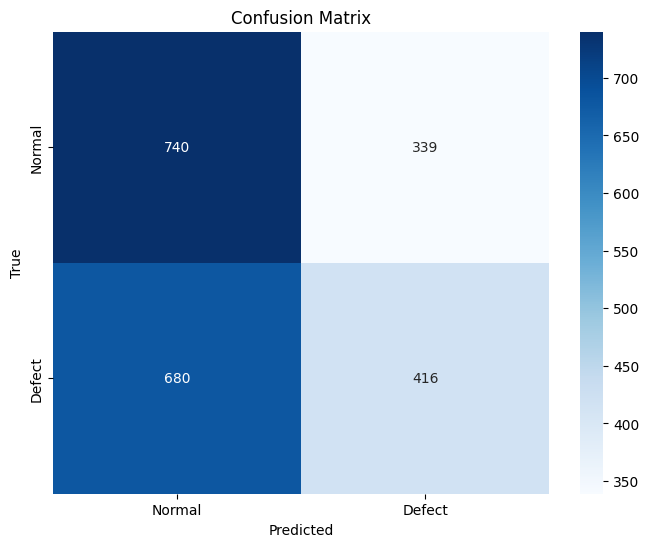

Training Swin Transformer for epoch 2/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [2/100], Loss: 0.7499
Accuracy: 0.5468
Recall: 0.3646
Precision: 0.3649
F1 Score: 0.3647


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


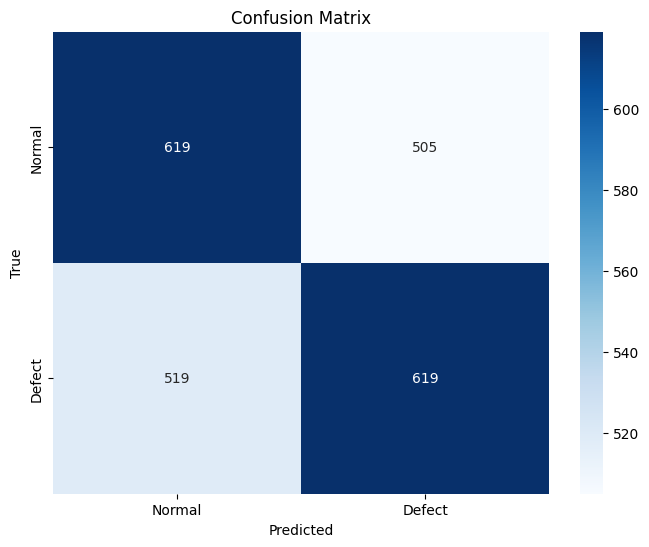

Training Swin Transformer for epoch 3/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [3/100], Loss: 0.7121
Accuracy: 0.5557
Recall: 0.2223
Precision: 0.2228
F1 Score: 0.2225


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


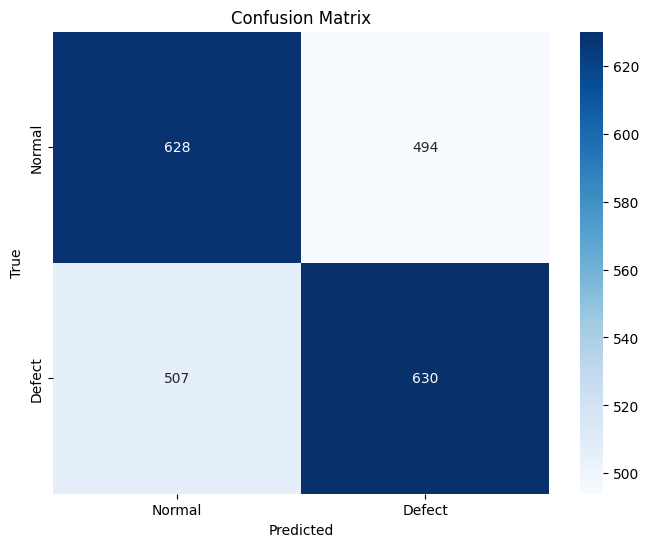

Training Swin Transformer for epoch 4/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [4/100], Loss: 0.7026
Accuracy: 0.5645
Recall: 0.2257
Precision: 0.2264
F1 Score: 0.2259


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


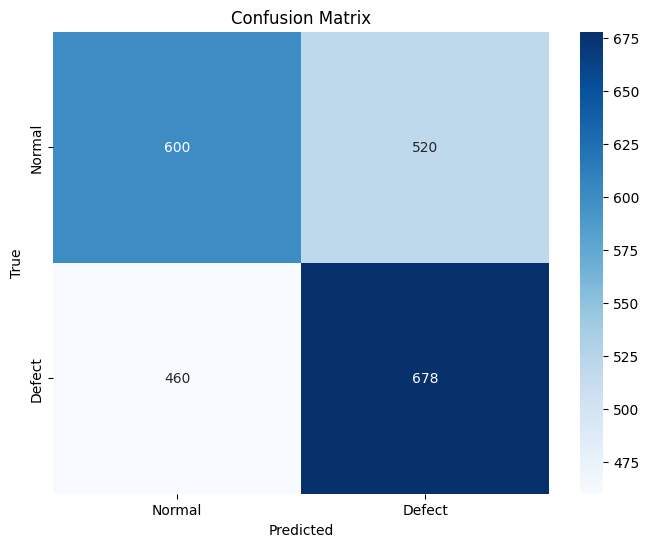

Training Swin Transformer for epoch 5/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [5/100], Loss: 0.6929
Accuracy: 0.5751
Recall: 0.3832
Precision: 0.3840
F1 Score: 0.3829


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


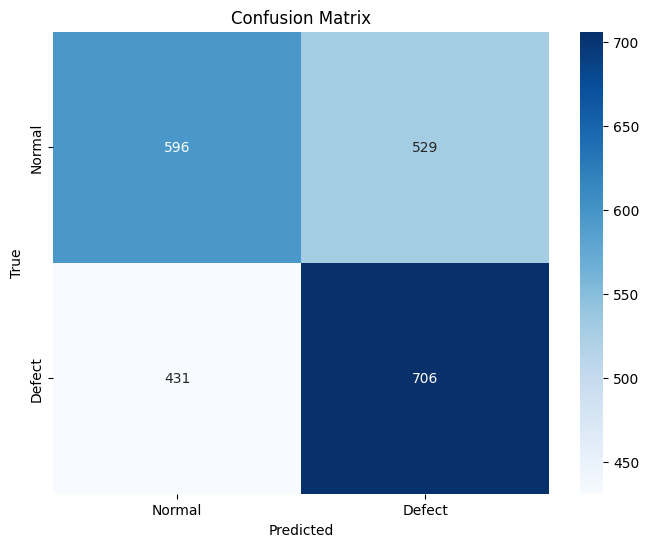

Training Swin Transformer for epoch 6/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [6/100], Loss: 0.6801
Accuracy: 0.5791
Recall: 0.3857
Precision: 0.3878
F1 Score: 0.3834


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


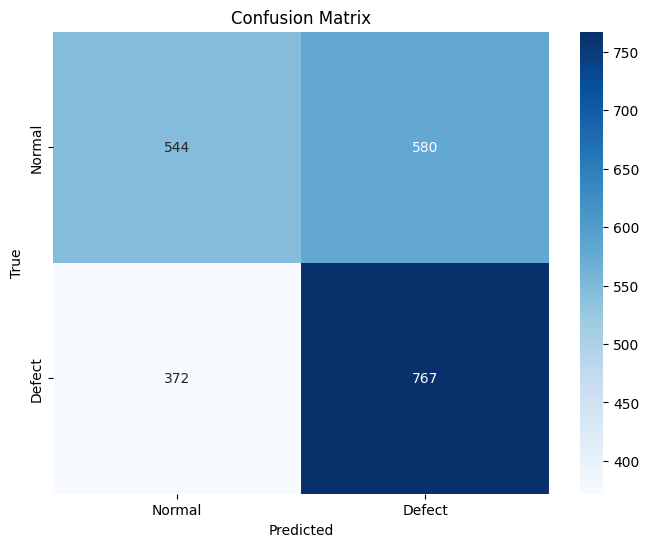

Training Swin Transformer for epoch 7/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [7/100], Loss: 0.6736
Accuracy: 0.5892
Recall: 0.3927
Precision: 0.3934
F1 Score: 0.3927


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


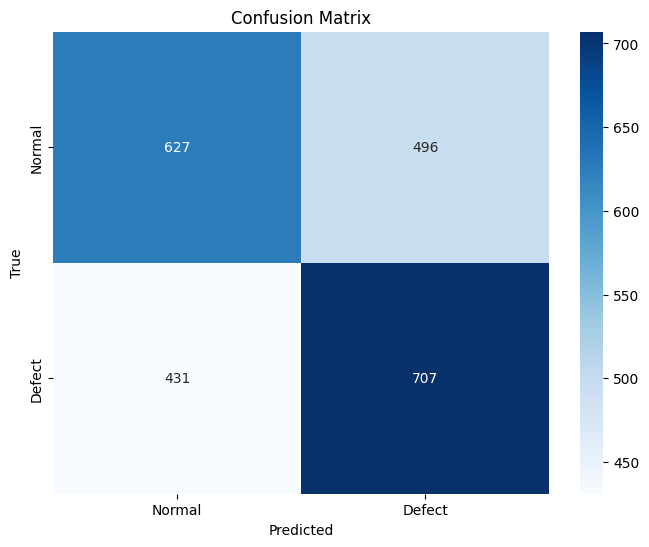

Training Swin Transformer for epoch 8/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [8/100], Loss: 0.6832
Accuracy: 0.5596
Recall: 0.2796
Precision: 0.2810
F1 Score: 0.2787


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


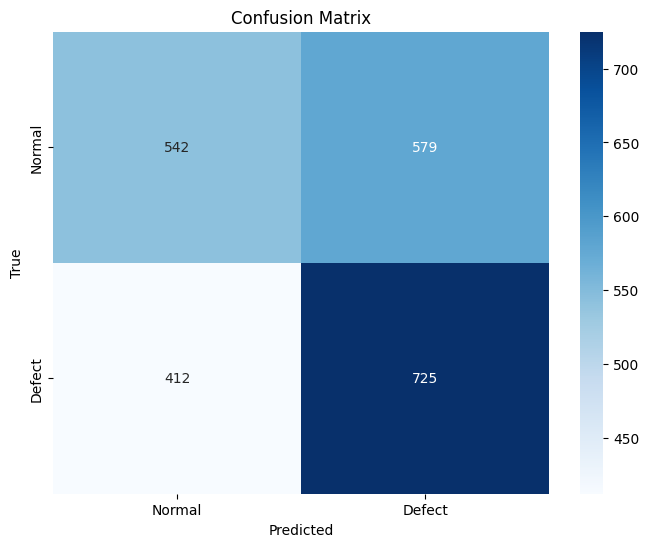

Training Swin Transformer for epoch 9/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [9/100], Loss: 0.6753
Accuracy: 0.5667
Recall: 0.2831
Precision: 0.2848
F1 Score: 0.2817


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


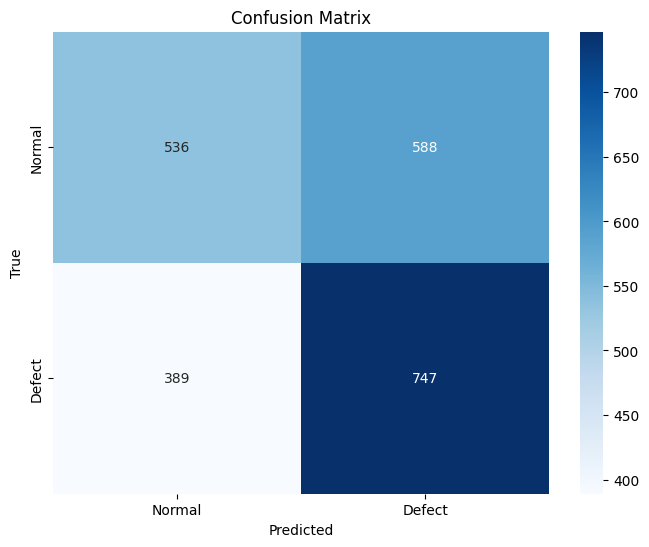

Training Swin Transformer for epoch 10/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [10/100], Loss: 0.6716
Accuracy: 0.5879
Recall: 0.2937
Precision: 0.2948
F1 Score: 0.2930


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


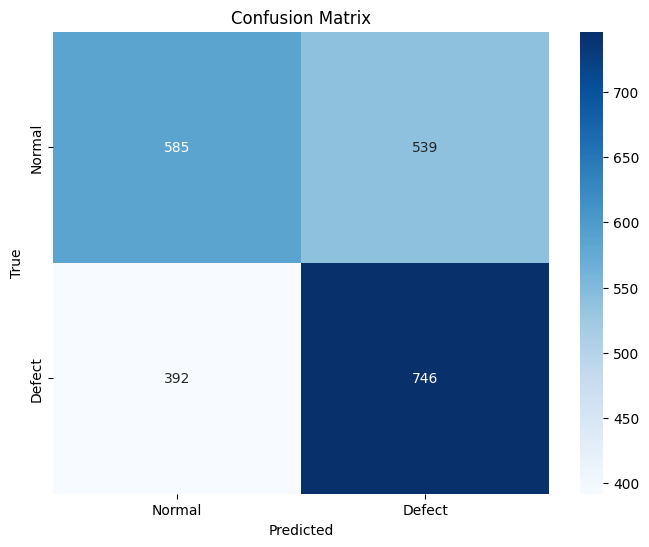

Training Swin Transformer for epoch 11/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [11/100], Loss: 0.6608
Accuracy: 0.6069
Recall: 0.3031
Precision: 0.3058
F1 Score: 0.3013


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


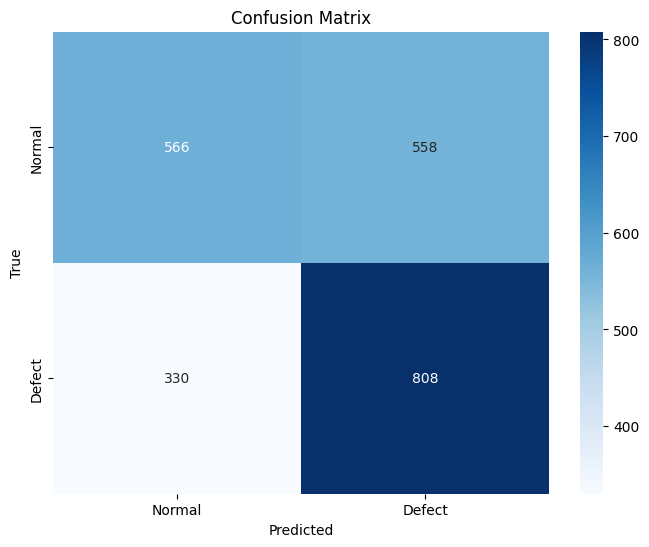

Training Swin Transformer for epoch 12/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [12/100], Loss: 0.6647
Accuracy: 0.6056
Recall: 0.4034
Precision: 0.4053
F1 Score: 0.4027


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


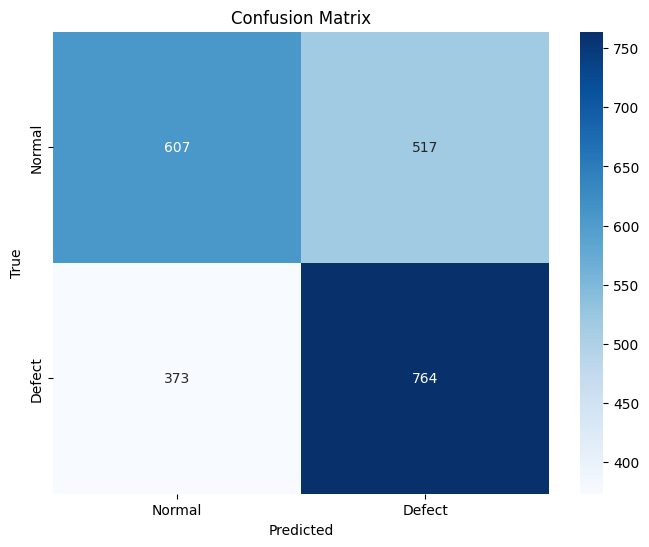

Training Swin Transformer for epoch 13/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [13/100], Loss: 0.6617
Accuracy: 0.6003
Recall: 0.2399
Precision: 0.2418
F1 Score: 0.2387


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


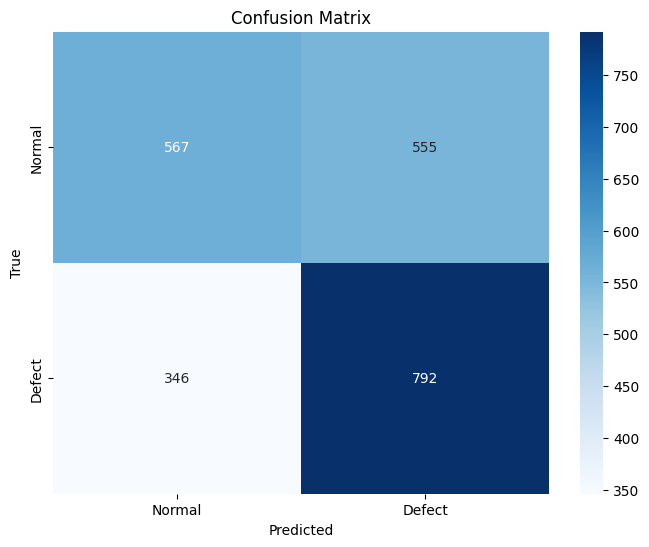

Training Swin Transformer for epoch 14/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [14/100], Loss: 0.6579
Accuracy: 0.6016
Recall: 0.4005
Precision: 0.4064
F1 Score: 0.3955


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


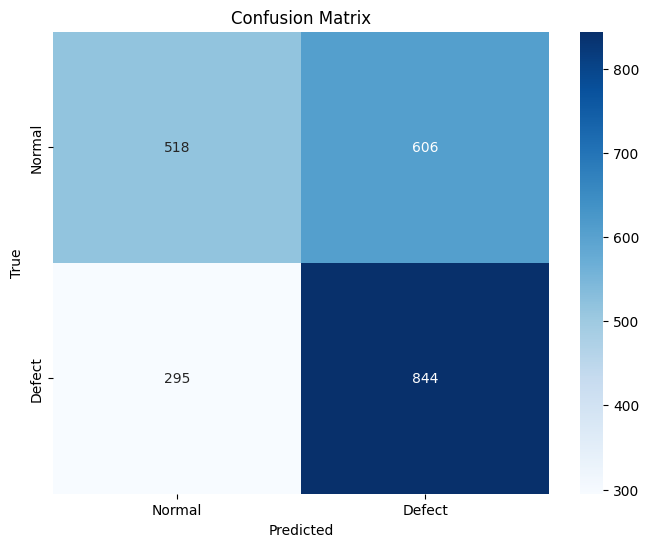

Training Swin Transformer for epoch 15/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [15/100], Loss: 0.6693
Accuracy: 0.5835
Recall: 0.2332
Precision: 0.2347
F1 Score: 0.2319


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


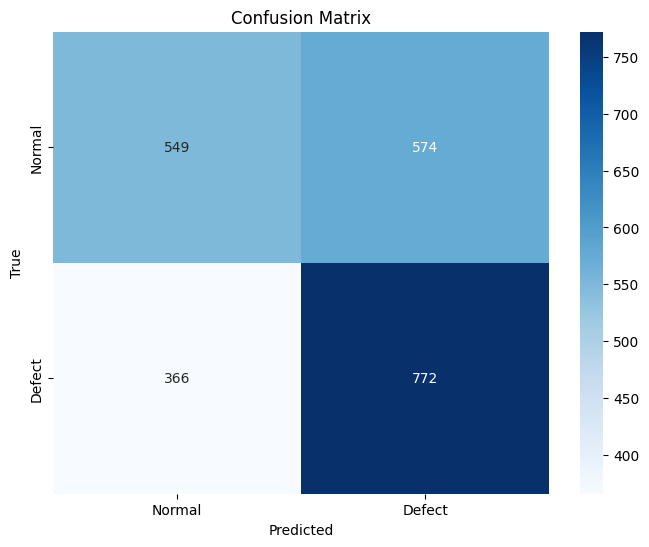

Training Swin Transformer for epoch 16/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [16/100], Loss: 0.6555
Accuracy: 0.5910
Recall: 0.3937
Precision: 0.3950
F1 Score: 0.3927


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


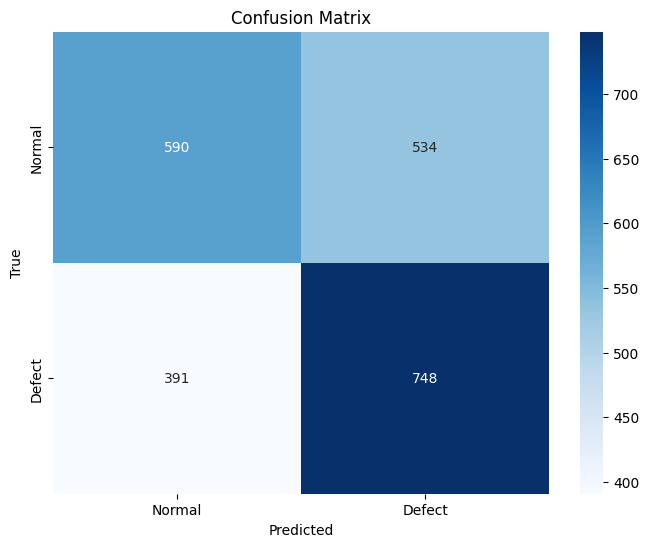

Training Swin Transformer for epoch 17/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [17/100], Loss: 0.6559
Accuracy: 0.5932
Recall: 0.3951
Precision: 0.3976
F1 Score: 0.3928


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


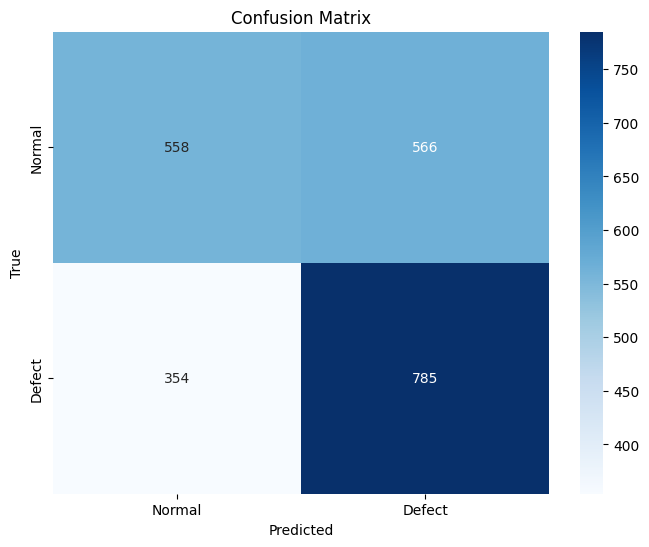

Training Swin Transformer for epoch 18/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [18/100], Loss: 0.6604
Accuracy: 0.6051
Recall: 0.3023
Precision: 0.3044
F1 Score: 0.3013


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


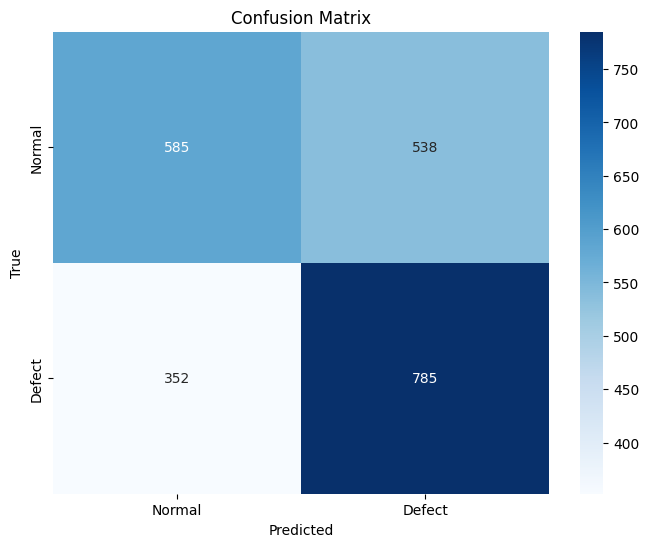

Training Swin Transformer for epoch 19/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [19/100], Loss: 0.6492
Accuracy: 0.6091
Recall: 0.6084
Precision: 0.6142
F1 Score: 0.6038


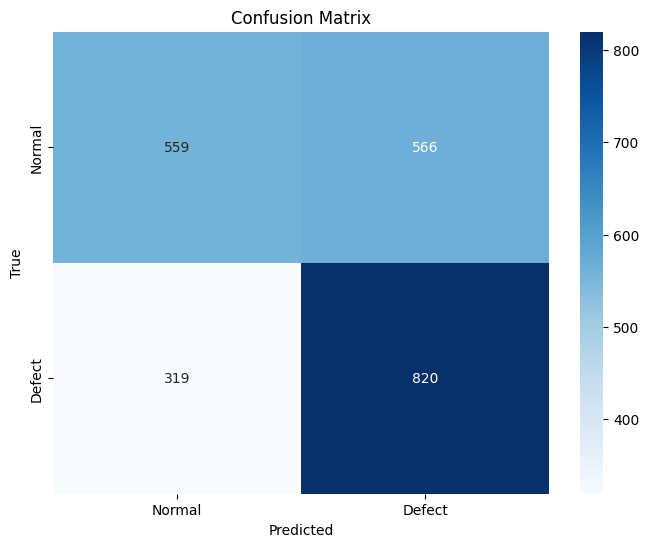

Training Swin Transformer for epoch 20/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [20/100], Loss: 0.6504
Accuracy: 0.5985
Recall: 0.3988
Precision: 0.3994
F1 Score: 0.3987


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


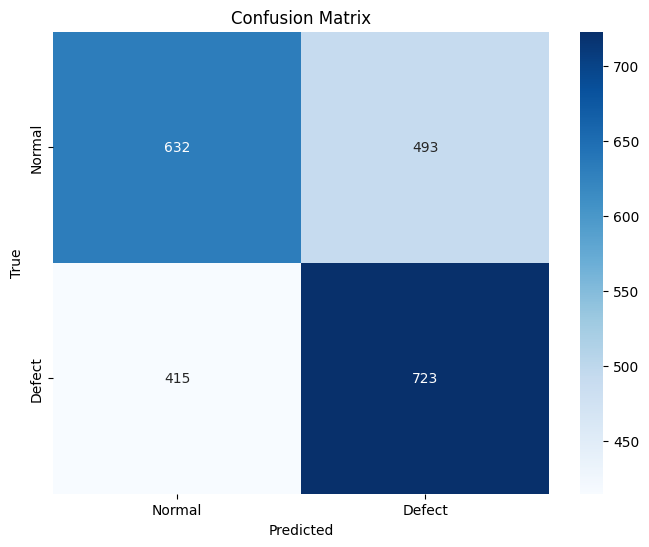

Training Swin Transformer for epoch 21/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [21/100], Loss: 0.6548
Accuracy: 0.5932
Recall: 0.3953
Precision: 0.3961
F1 Score: 0.3947


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


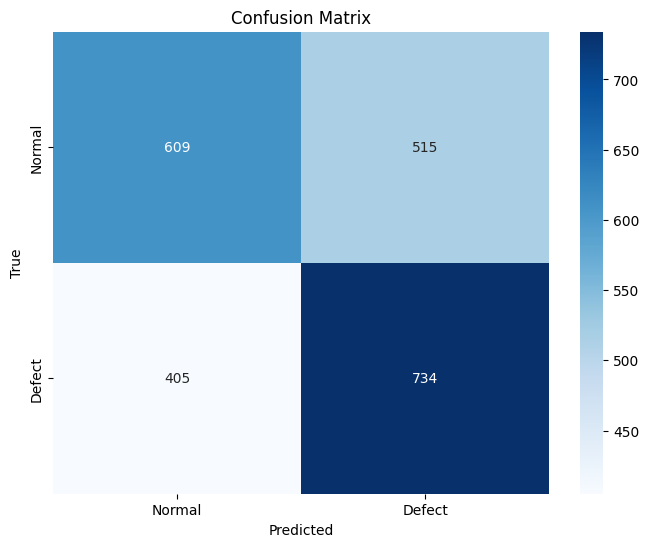

Training Swin Transformer for epoch 22/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [22/100], Loss: 0.6496
Accuracy: 0.6073
Recall: 0.3034
Precision: 0.3052
F1 Score: 0.3023


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


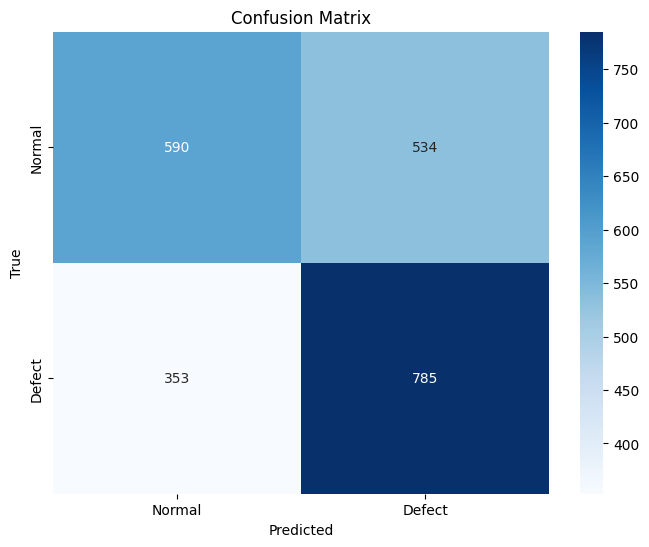

Training Swin Transformer for epoch 23/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [23/100], Loss: 0.6503
Accuracy: 0.6056
Recall: 0.4033
Precision: 0.4066
F1 Score: 0.4008


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


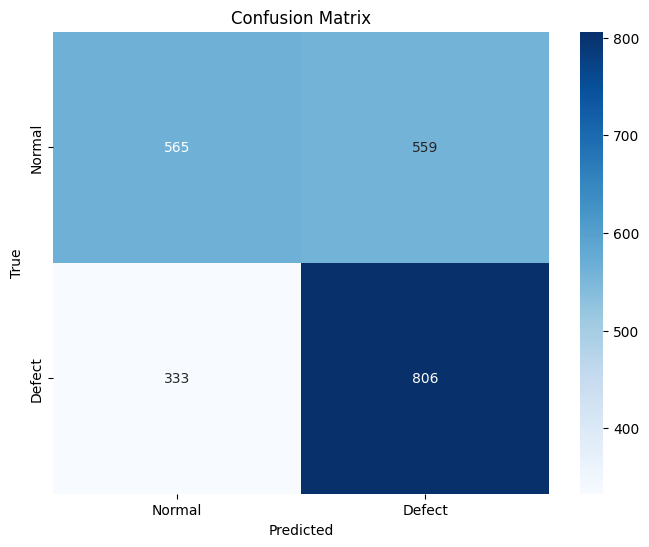

Training Swin Transformer for epoch 24/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [24/100], Loss: 0.6480
Accuracy: 0.5954
Recall: 0.2973
Precision: 0.3015
F1 Score: 0.2942


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


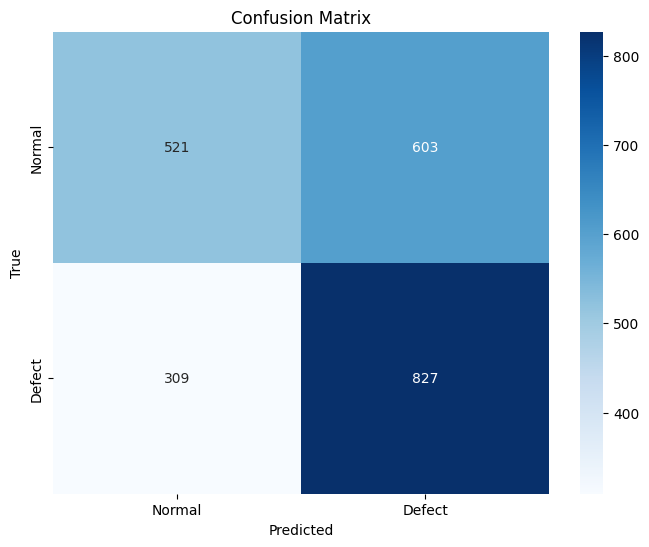

Training Swin Transformer for epoch 25/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [25/100], Loss: 0.6570
Accuracy: 0.5910
Recall: 0.5902
Precision: 0.5971
F1 Score: 0.5832


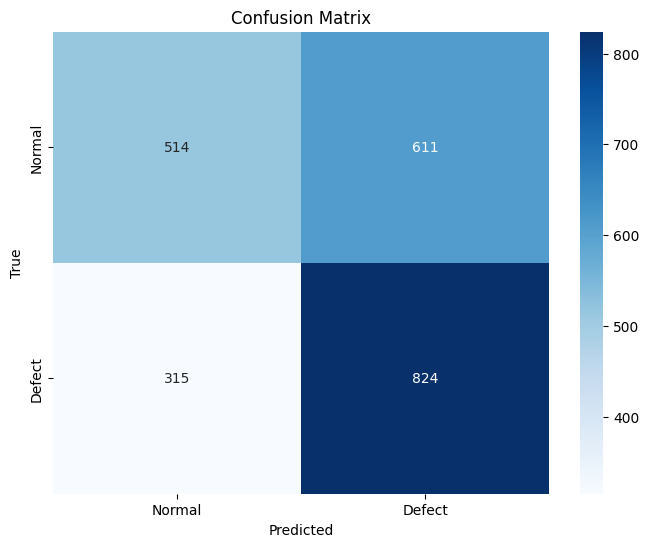

Training Swin Transformer for epoch 26/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [26/100], Loss: 0.6514
Accuracy: 0.6056
Recall: 0.4034
Precision: 0.4055
F1 Score: 0.4018


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


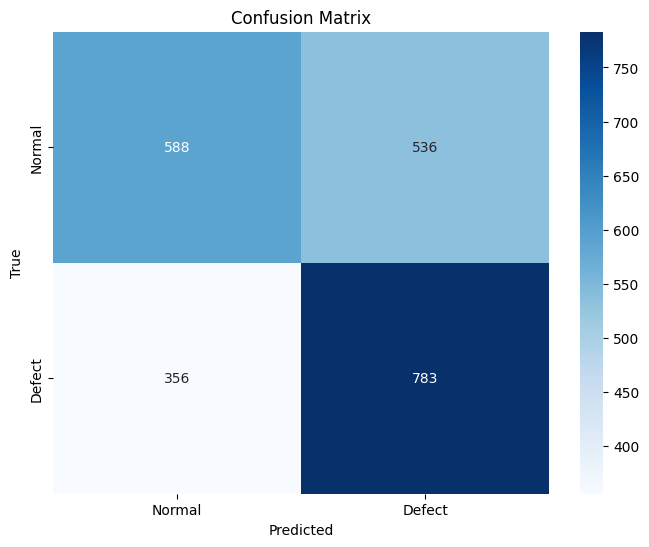

Training Swin Transformer for epoch 27/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [27/100], Loss: 0.6409
Accuracy: 0.6170
Recall: 0.6164
Precision: 0.6218
F1 Score: 0.6125


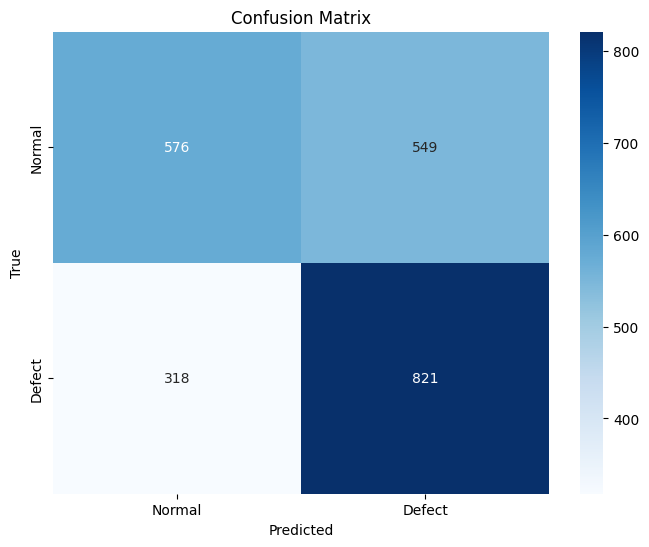

Training Swin Transformer for epoch 28/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [28/100], Loss: 0.6544
Accuracy: 0.5985
Recall: 0.2990
Precision: 0.3006
F1 Score: 0.2982


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


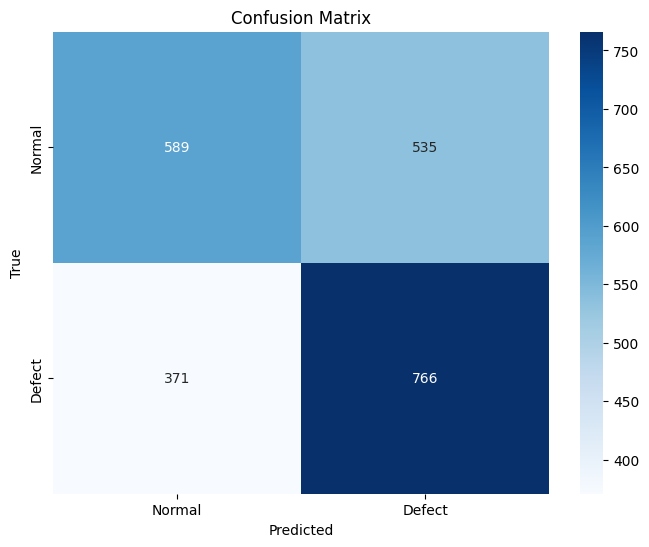

Training Swin Transformer for epoch 29/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [29/100], Loss: 0.6469
Accuracy: 0.6109
Recall: 0.3052
Precision: 0.3075
F1 Score: 0.3040


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


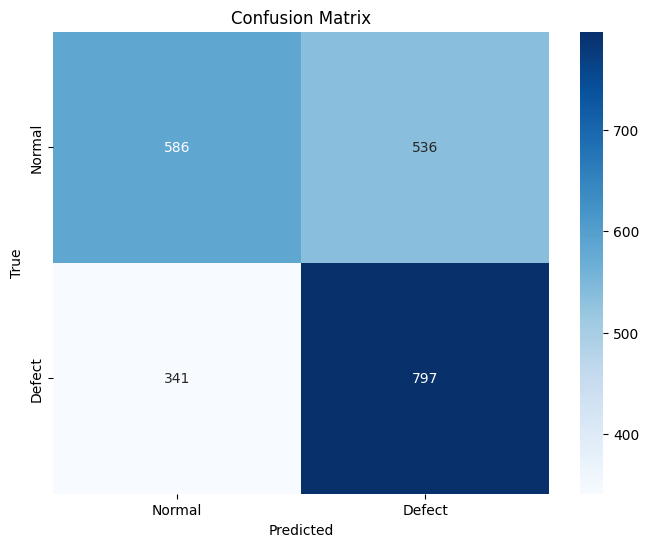

Training Swin Transformer for epoch 30/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [30/100], Loss: 0.6447
Accuracy: 0.6117
Recall: 0.3057
Precision: 0.3067
F1 Score: 0.3052


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


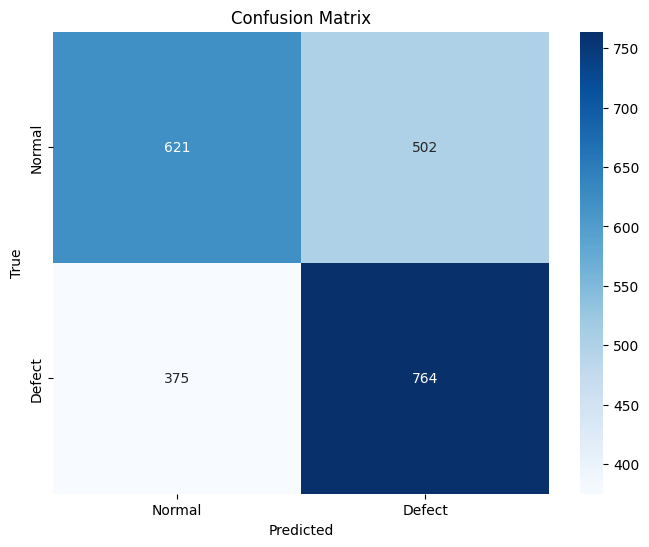

Training Swin Transformer for epoch 31/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [31/100], Loss: 0.6514
Accuracy: 0.5998
Recall: 0.3996
Precision: 0.4009
F1 Score: 0.3990


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


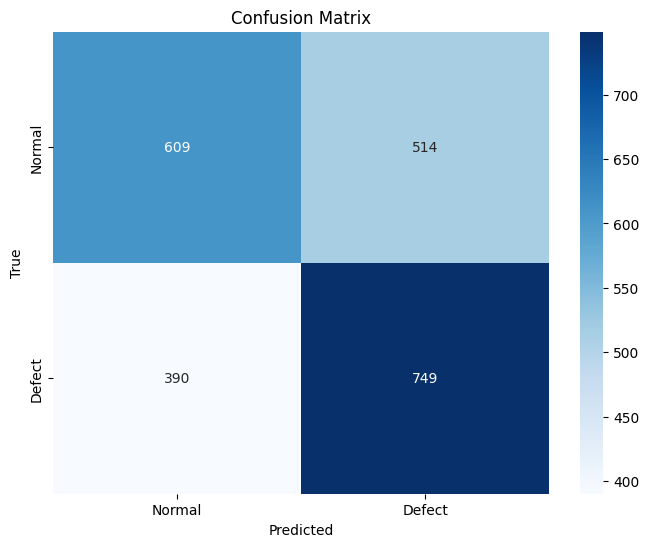

Training Swin Transformer for epoch 32/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [32/100], Loss: 0.6499
Accuracy: 0.6051
Recall: 0.4032
Precision: 0.4041
F1 Score: 0.4028


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


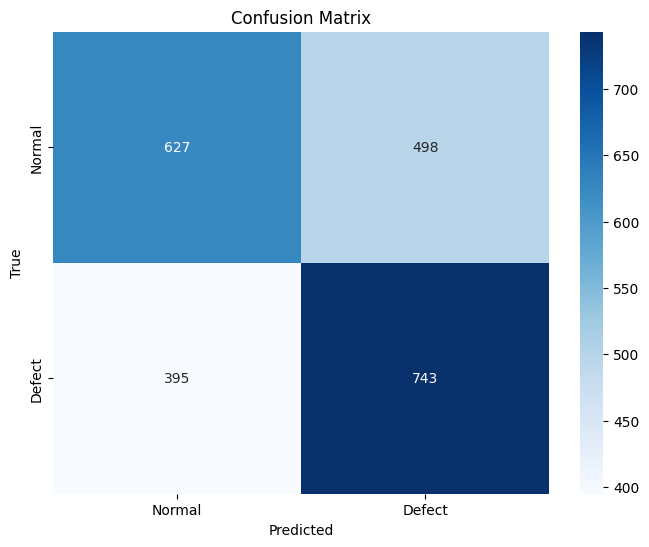

Training Swin Transformer for epoch 33/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [33/100], Loss: 0.6448
Accuracy: 0.6117
Recall: 0.2445
Precision: 0.2459
F1 Score: 0.2443


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


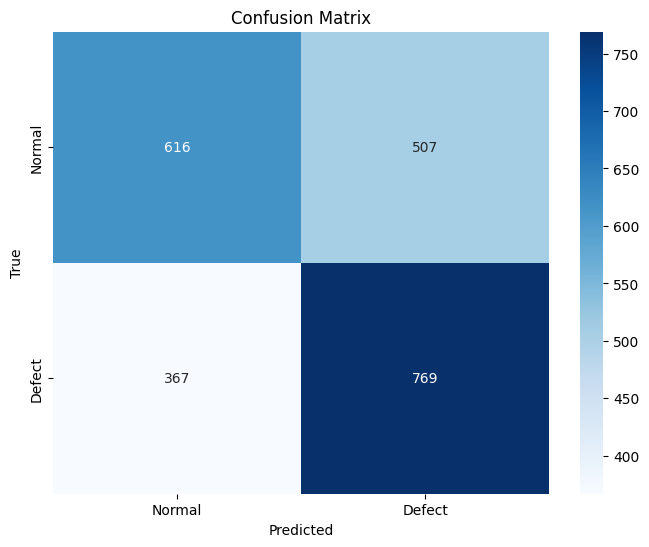

Training Swin Transformer for epoch 34/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [34/100], Loss: 0.6539
Accuracy: 0.5998
Recall: 0.5995
Precision: 0.6009
F1 Score: 0.5983


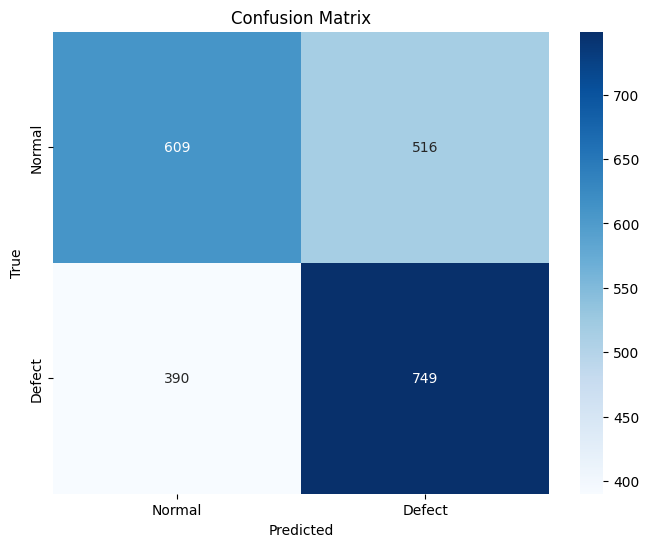

Training Swin Transformer for epoch 35/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [35/100], Loss: 0.6494
Accuracy: 0.5950
Recall: 0.2378
Precision: 0.2389
F1 Score: 0.2376


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


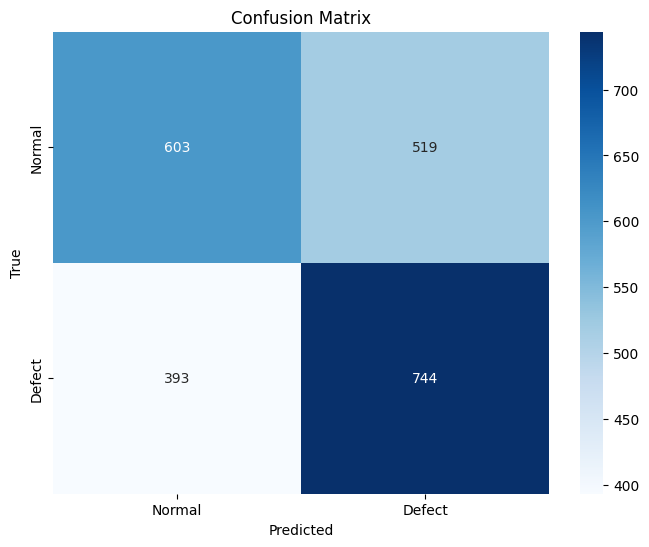

Training Swin Transformer for epoch 36/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [36/100], Loss: 0.6417
Accuracy: 0.6166
Recall: 0.6164
Precision: 0.6170
F1 Score: 0.6160


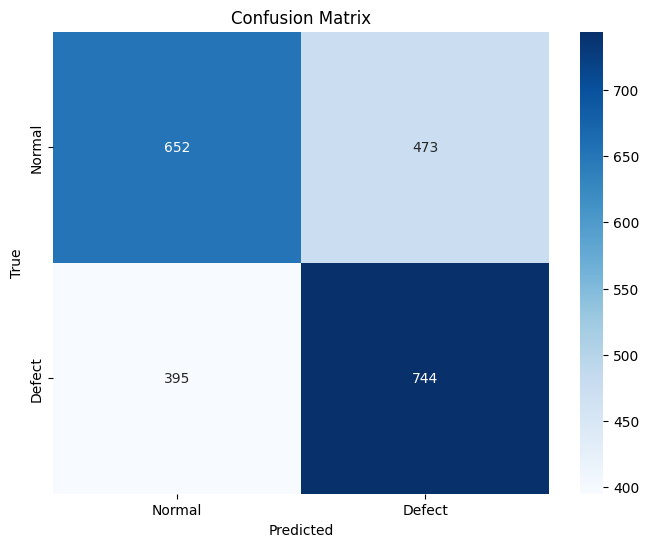

Training Swin Transformer for epoch 37/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [37/100], Loss: 0.6534
Accuracy: 0.6140
Recall: 0.3068
Precision: 0.3078
F1 Score: 0.3067


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


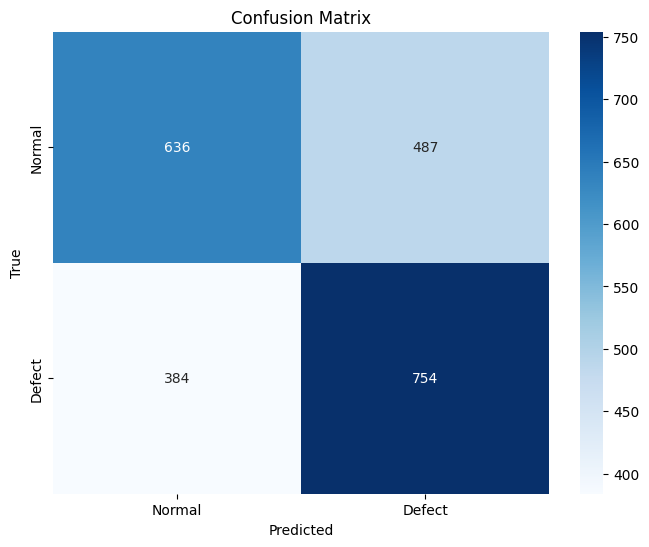

Training Swin Transformer for epoch 38/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [38/100], Loss: 0.6502
Accuracy: 0.5941
Recall: 0.5936
Precision: 0.5956
F1 Score: 0.5918


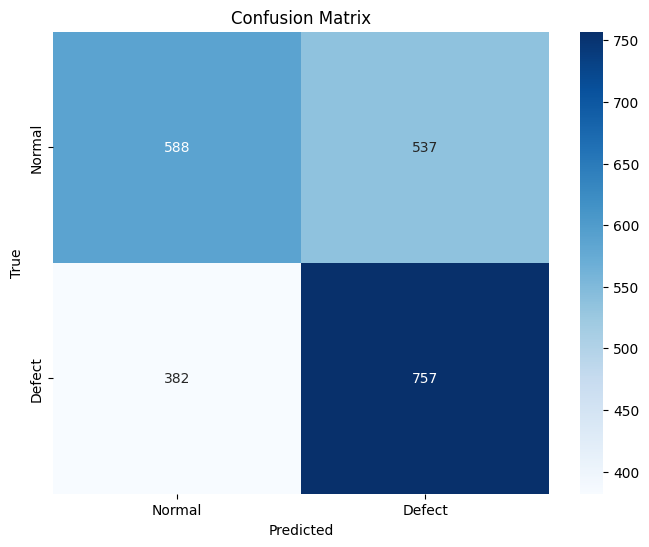

Training Swin Transformer for epoch 39/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [39/100], Loss: 0.6460
Accuracy: 0.6087
Recall: 0.6082
Precision: 0.6106
F1 Score: 0.6064


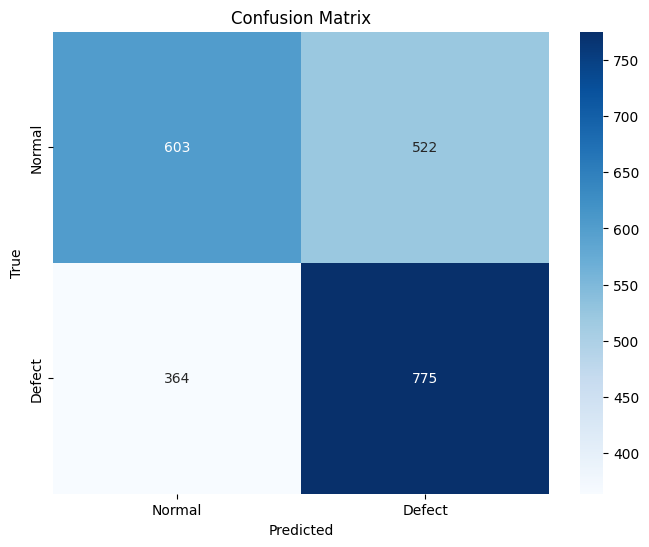

Training Swin Transformer for epoch 40/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [40/100], Loss: 0.6413
Accuracy: 0.6038
Recall: 0.6034
Precision: 0.6053
F1 Score: 0.6018


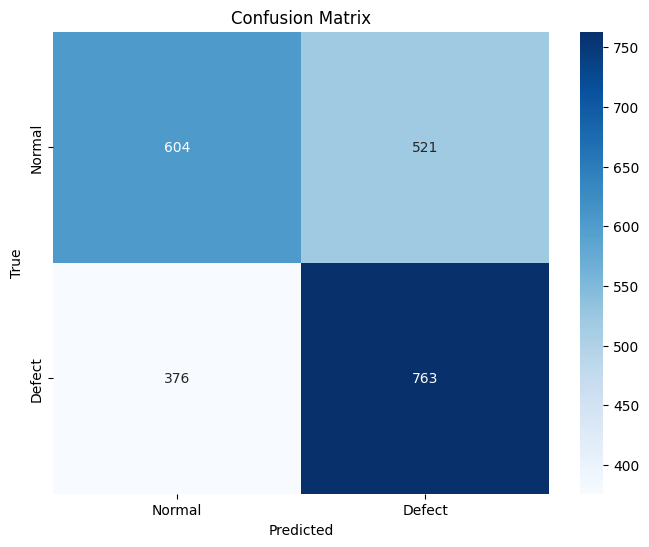

Training Swin Transformer for epoch 41/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [41/100], Loss: 0.6410
Accuracy: 0.6162
Recall: 0.6156
Precision: 0.6194
F1 Score: 0.6129


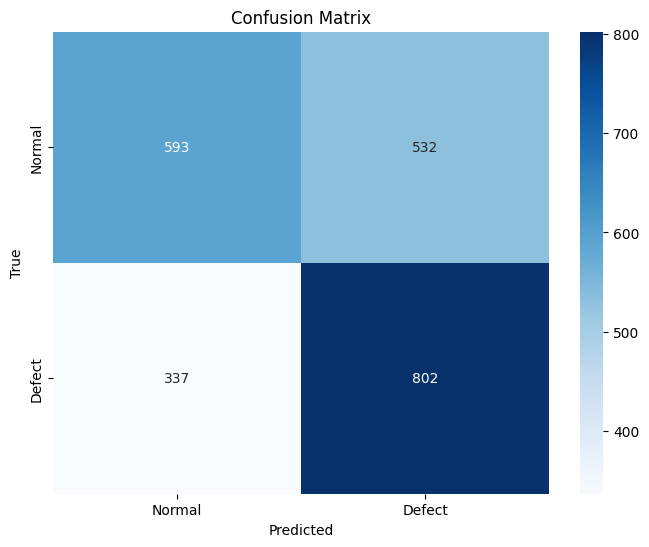

Training Swin Transformer for epoch 42/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [42/100], Loss: 0.6512
Accuracy: 0.5866
Recall: 0.3908
Precision: 0.3920
F1 Score: 0.3901


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


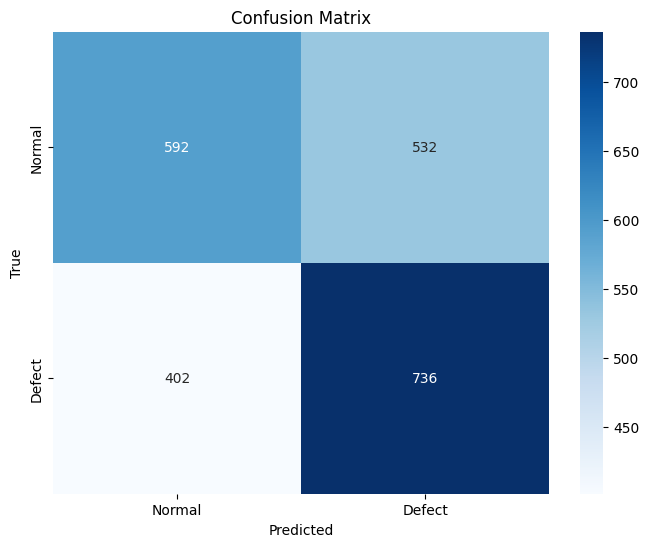

Training Swin Transformer for epoch 43/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [43/100], Loss: 0.6457
Accuracy: 0.6188
Recall: 0.4123
Precision: 0.4135
F1 Score: 0.4117


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


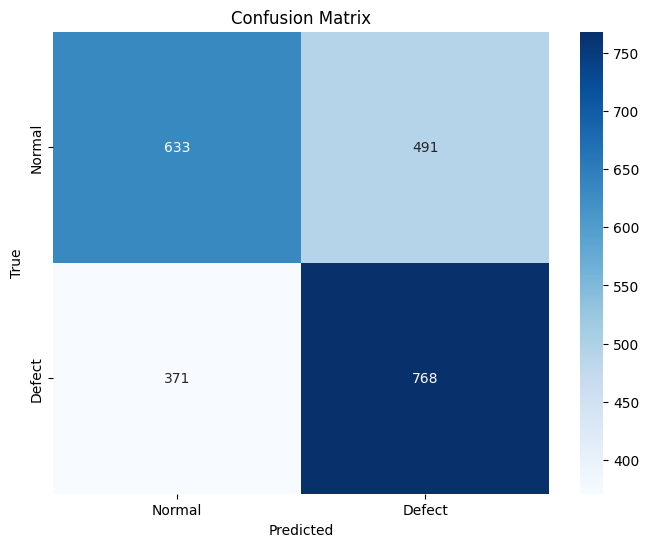

Training Swin Transformer for epoch 44/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [44/100], Loss: 0.6440
Accuracy: 0.6117
Recall: 0.4075
Precision: 0.4105
F1 Score: 0.4057


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


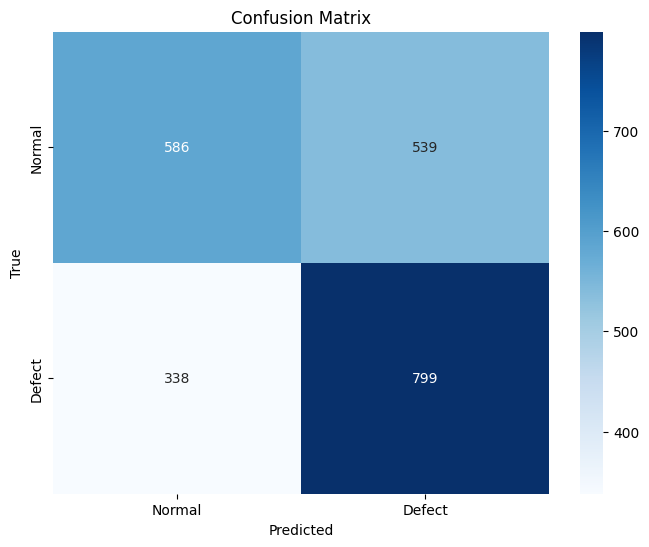

Training Swin Transformer for epoch 45/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [45/100], Loss: 0.6431
Accuracy: 0.6153
Recall: 0.3074
Precision: 0.3089
F1 Score: 0.3067


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


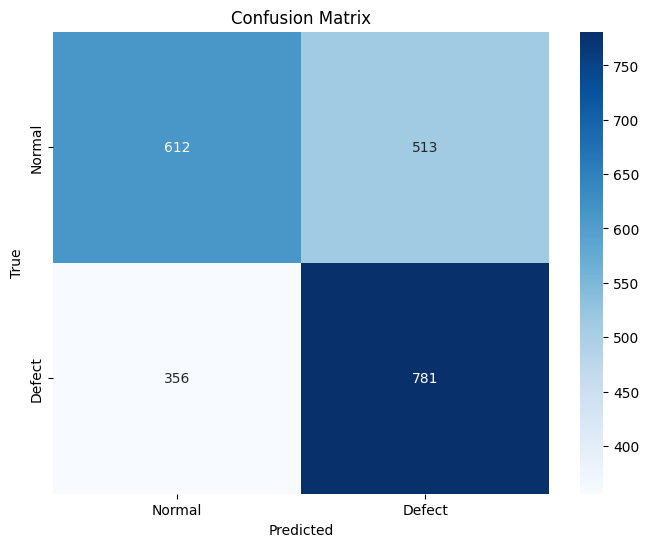

Training Swin Transformer for epoch 46/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [46/100], Loss: 0.6530
Accuracy: 0.5852
Recall: 0.3899
Precision: 0.3912
F1 Score: 0.3887


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


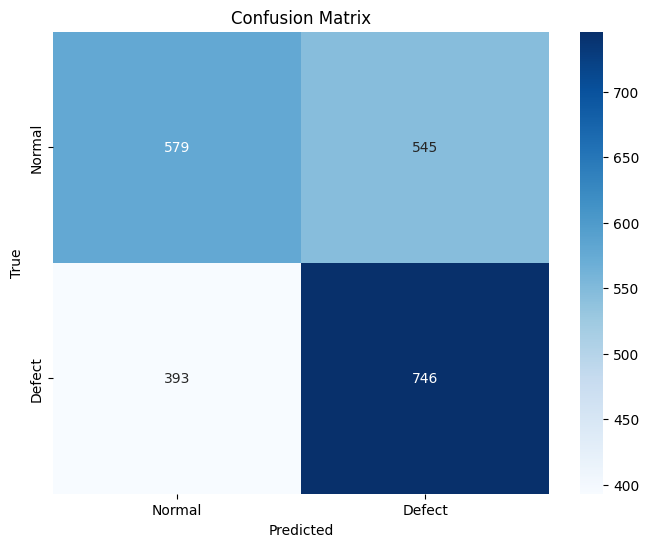

Training Swin Transformer for epoch 47/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [47/100], Loss: 0.6497
Accuracy: 0.6060
Recall: 0.6056
Precision: 0.6072
F1 Score: 0.6044


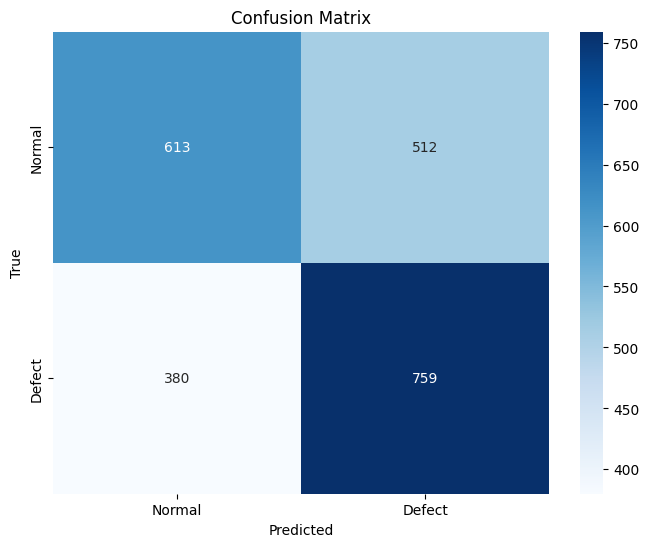

Training Swin Transformer for epoch 48/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [48/100], Loss: 0.6536
Accuracy: 0.5936
Recall: 0.2966
Precision: 0.2981
F1 Score: 0.2960


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


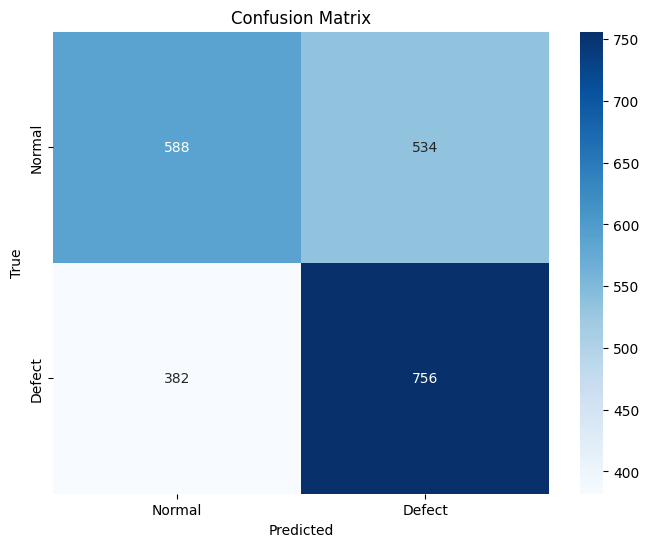

Training Swin Transformer for epoch 49/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [49/100], Loss: 0.6502
Accuracy: 0.6038
Recall: 0.3017
Precision: 0.3032
F1 Score: 0.3007


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


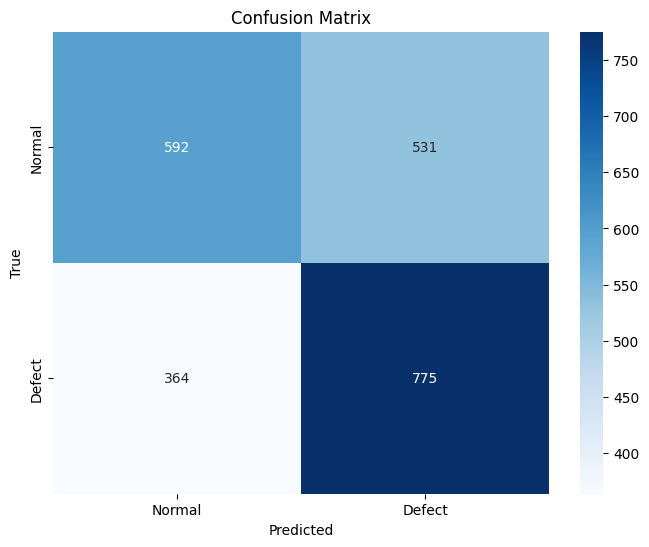

Training Swin Transformer for epoch 50/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [50/100], Loss: 0.6450
Accuracy: 0.6047
Recall: 0.6042
Precision: 0.6065
F1 Score: 0.6024


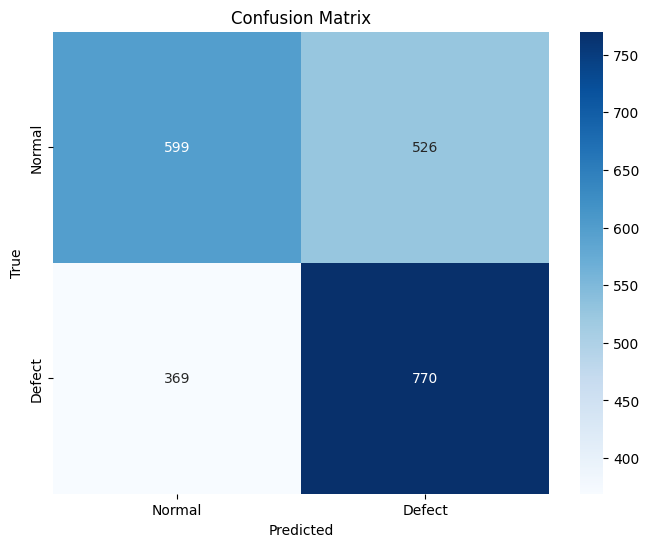

Training Swin Transformer for epoch 51/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [51/100], Loss: 0.6448
Accuracy: 0.6148
Recall: 0.4096
Precision: 0.4116
F1 Score: 0.4089


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


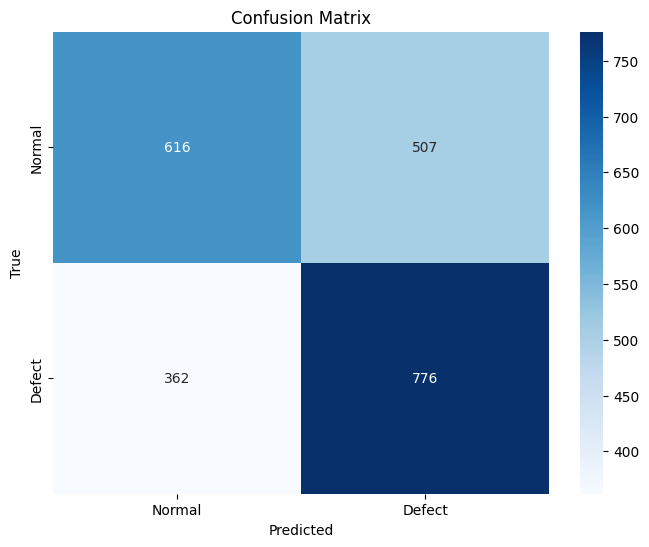

Training Swin Transformer for epoch 52/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [52/100], Loss: 0.6438
Accuracy: 0.6078
Recall: 0.6074
Precision: 0.6093
F1 Score: 0.6059


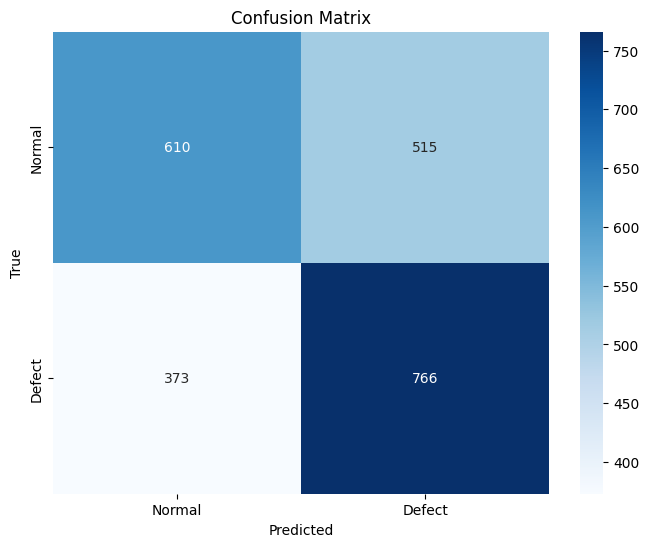

Training Swin Transformer for epoch 53/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [53/100], Loss: 0.6476
Accuracy: 0.6042
Recall: 0.4026
Precision: 0.4038
F1 Score: 0.4019


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


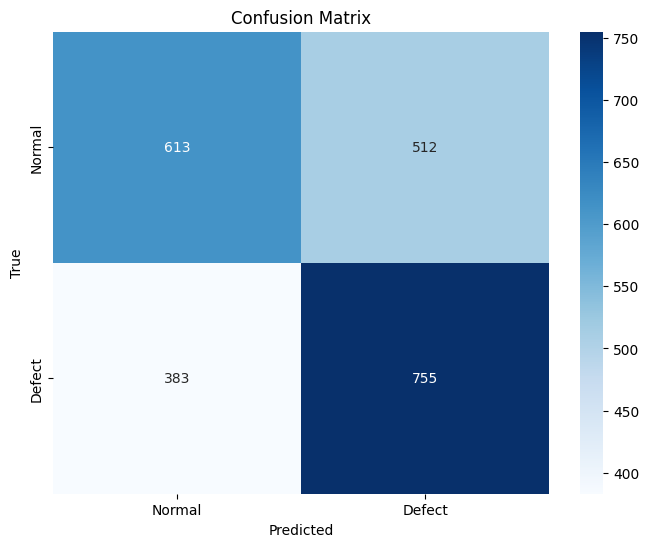

Training Swin Transformer for epoch 54/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [54/100], Loss: 0.6492
Accuracy: 0.6162
Recall: 0.3079
Precision: 0.3093
F1 Score: 0.3071


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


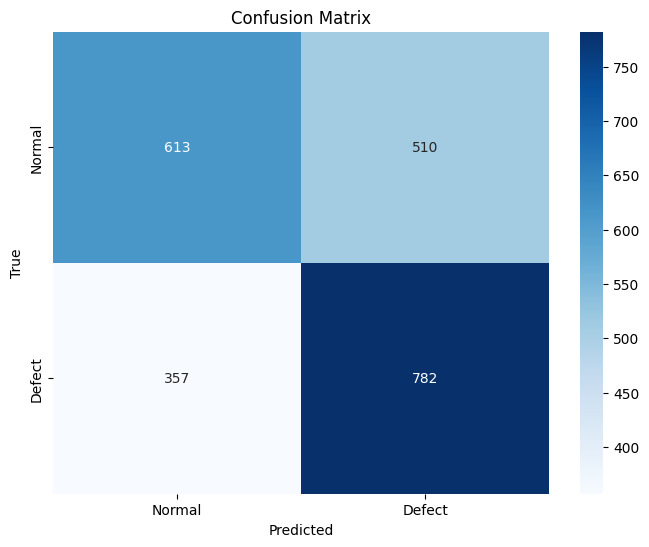

Training Swin Transformer for epoch 55/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [55/100], Loss: 0.6497
Accuracy: 0.6003
Recall: 0.2999
Precision: 0.3014
F1 Score: 0.2991


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


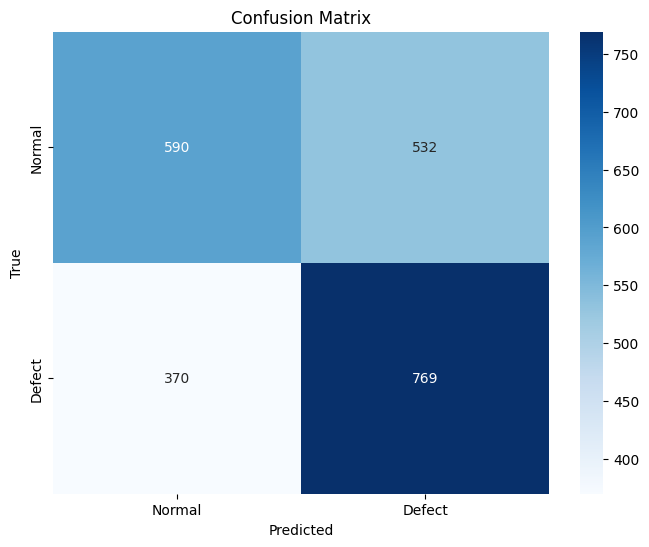

Training Swin Transformer for epoch 56/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [56/100], Loss: 0.6346
Accuracy: 0.6369
Recall: 0.4243
Precision: 0.4263
F1 Score: 0.4236


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


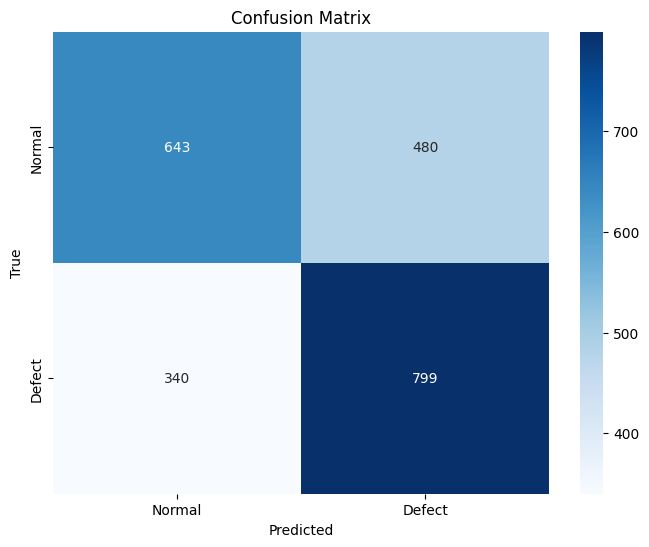

Training Swin Transformer for epoch 57/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [57/100], Loss: 0.6453
Accuracy: 0.6175
Recall: 0.4113
Precision: 0.4138
F1 Score: 0.4101


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


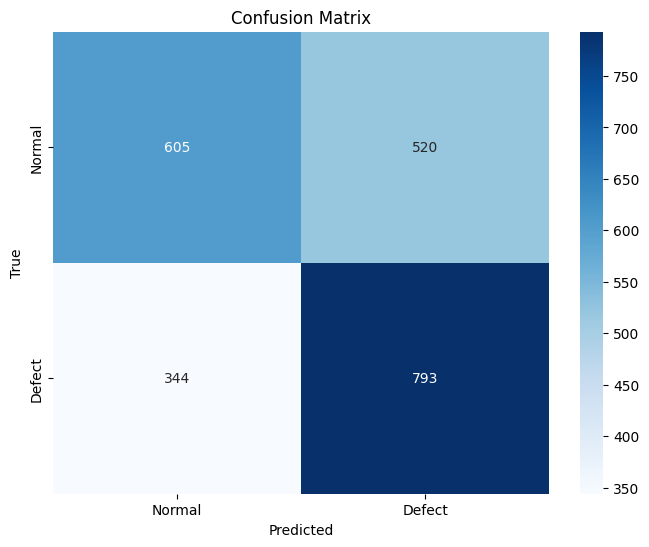

Training Swin Transformer for epoch 58/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [58/100], Loss: 0.6460
Accuracy: 0.5950
Recall: 0.2973
Precision: 0.2985
F1 Score: 0.2965


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


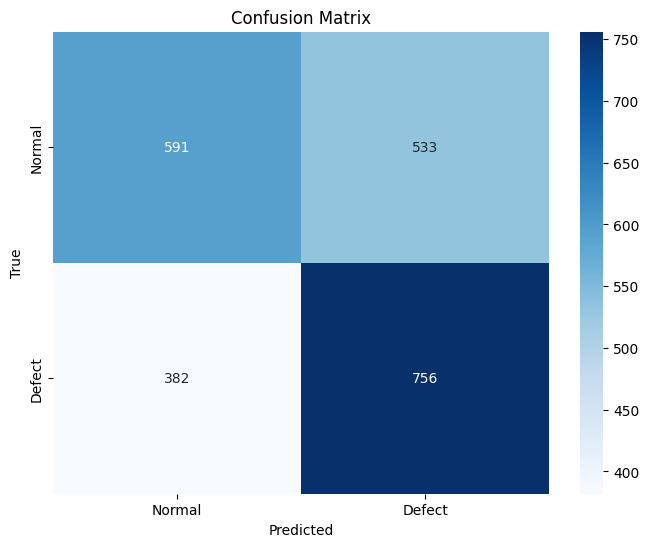

Training Swin Transformer for epoch 59/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [59/100], Loss: 0.6444
Accuracy: 0.6100
Recall: 0.4064
Precision: 0.4082
F1 Score: 0.4054


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


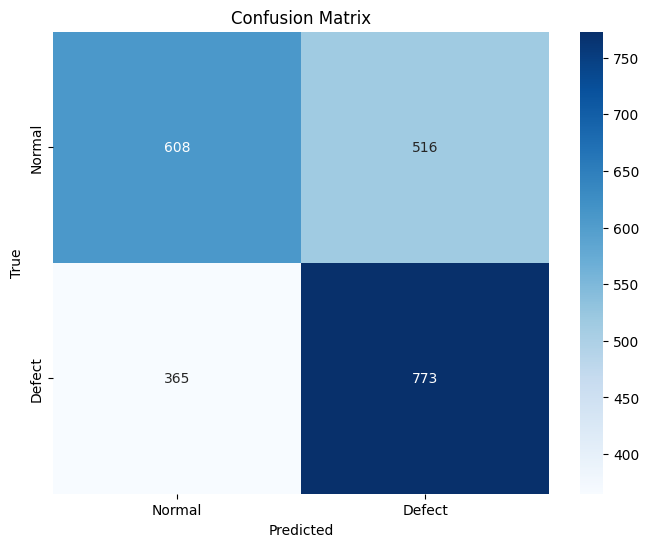

Training Swin Transformer for epoch 60/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [60/100], Loss: 0.6487
Accuracy: 0.6034
Recall: 0.4020
Precision: 0.4030
F1 Score: 0.4014


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


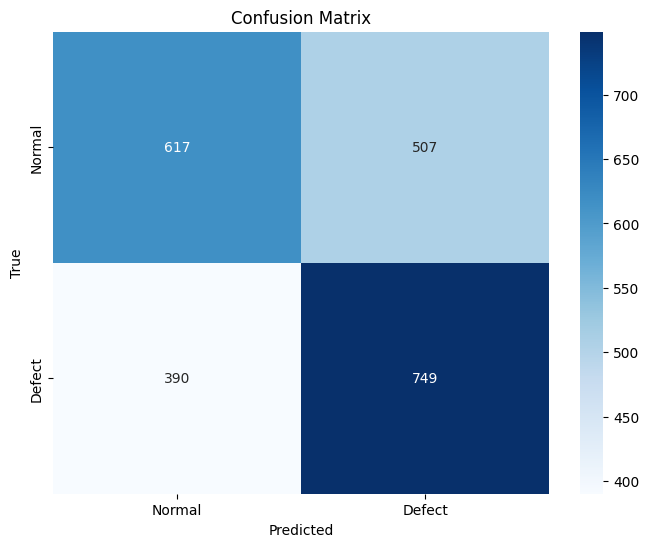

Training Swin Transformer for epoch 61/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [61/100], Loss: 0.6456
Accuracy: 0.6100
Recall: 0.4064
Precision: 0.4081
F1 Score: 0.4053


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


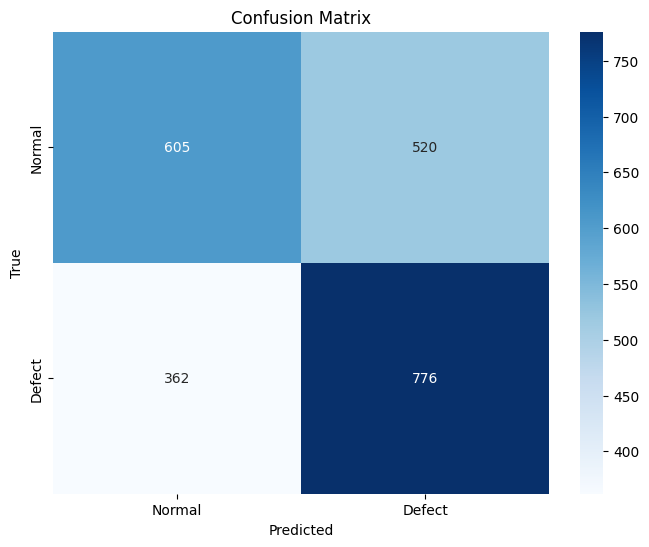

Training Swin Transformer for epoch 62/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [62/100], Loss: 0.6464
Accuracy: 0.6056
Recall: 0.3026
Precision: 0.3037
F1 Score: 0.3023


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


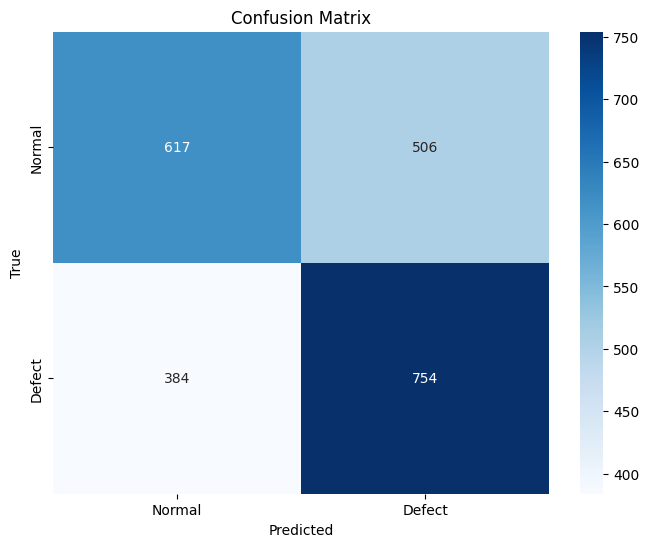

Training Swin Transformer for epoch 63/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [63/100], Loss: 0.6434
Accuracy: 0.6175
Recall: 0.4113
Precision: 0.4135
F1 Score: 0.4101


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


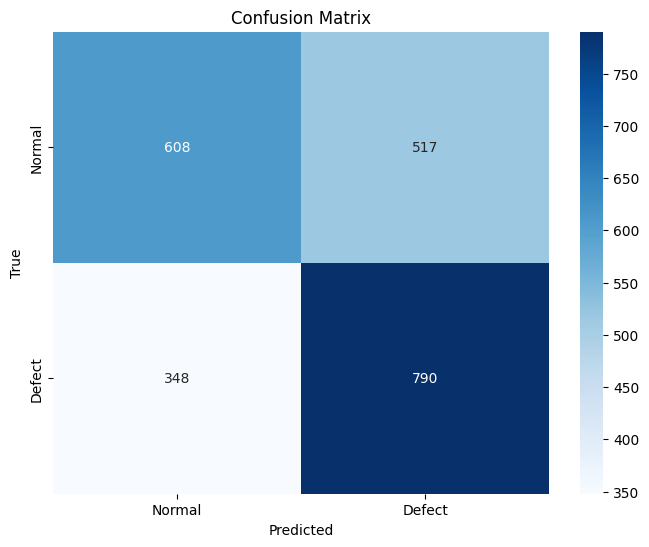

Training Swin Transformer for epoch 64/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [64/100], Loss: 0.6453
Accuracy: 0.6153
Recall: 0.6149
Precision: 0.6171
F1 Score: 0.6133


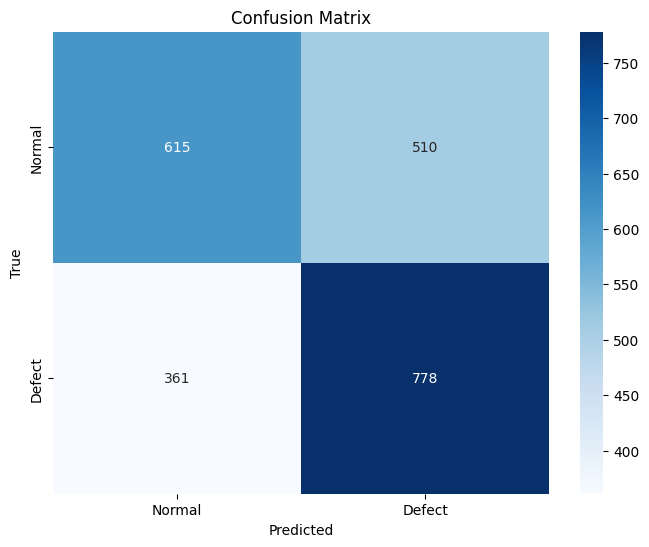

Training Swin Transformer for epoch 65/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [65/100], Loss: 0.6438
Accuracy: 0.6095
Recall: 0.3045
Precision: 0.3060
F1 Score: 0.3038


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


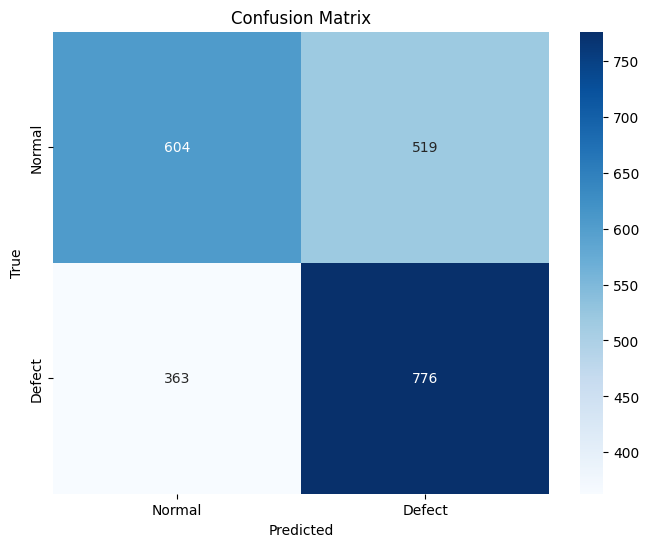

Training Swin Transformer for epoch 66/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [66/100], Loss: 0.6370
Accuracy: 0.6140
Recall: 0.6136
Precision: 0.6152
F1 Score: 0.6124


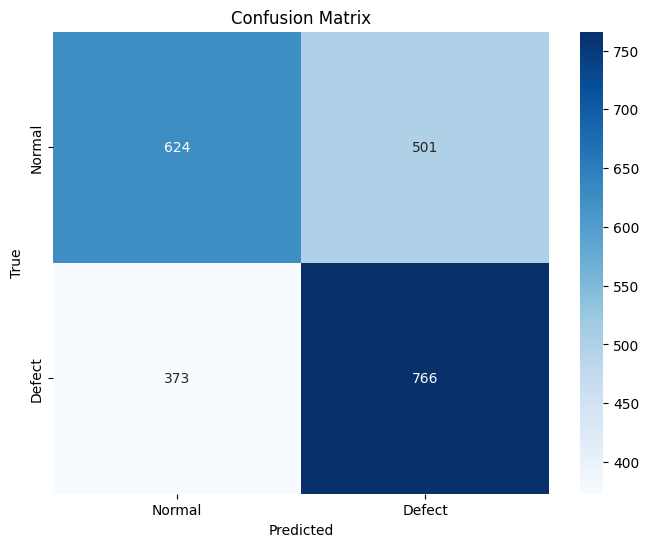

Training Swin Transformer for epoch 67/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [67/100], Loss: 0.6516
Accuracy: 0.5928
Recall: 0.3949
Precision: 0.3962
F1 Score: 0.3940


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


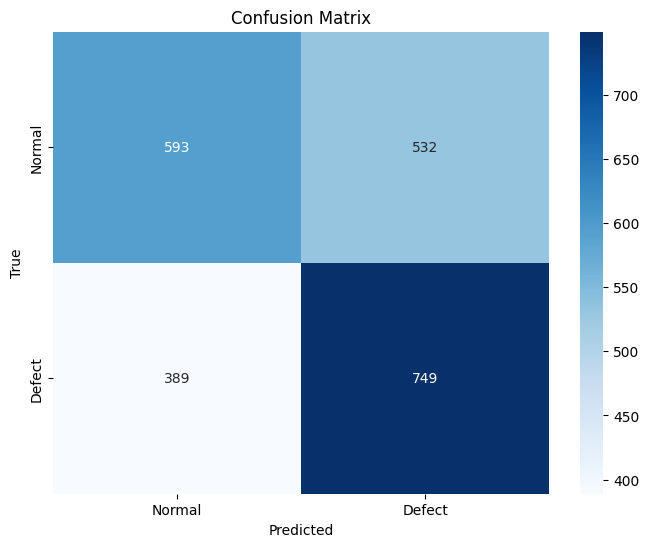

Training Swin Transformer for epoch 68/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [68/100], Loss: 0.6492
Accuracy: 0.6104
Recall: 0.3050
Precision: 0.3064
F1 Score: 0.3043


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


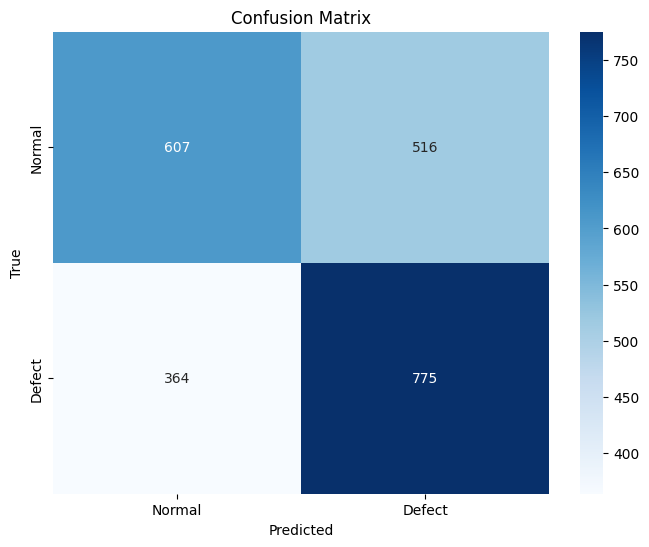

Training Swin Transformer for epoch 69/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [69/100], Loss: 0.6451
Accuracy: 0.6064
Recall: 0.4040
Precision: 0.4056
F1 Score: 0.4032


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


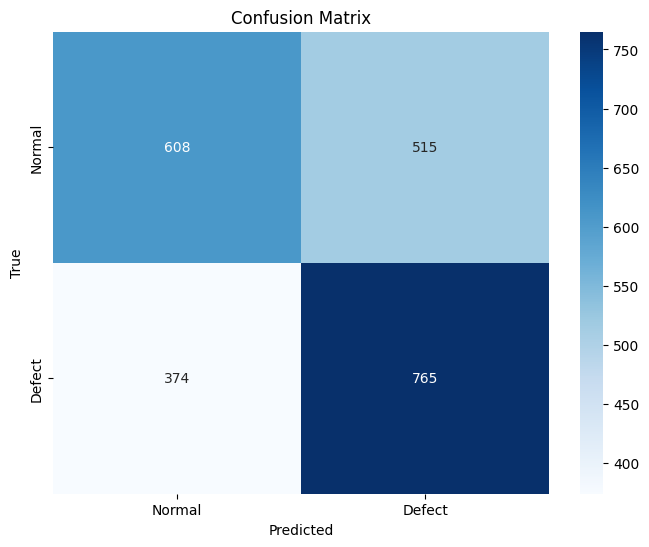

Training Swin Transformer for epoch 70/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [70/100], Loss: 0.6457
Accuracy: 0.6148
Recall: 0.6144
Precision: 0.6172
F1 Score: 0.6123


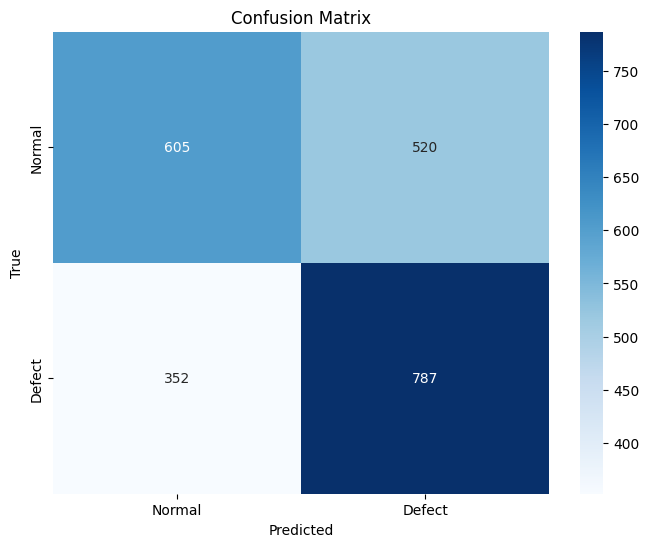

Training Swin Transformer for epoch 71/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [71/100], Loss: 0.6537
Accuracy: 0.5972
Recall: 0.2984
Precision: 0.2996
F1 Score: 0.2976


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


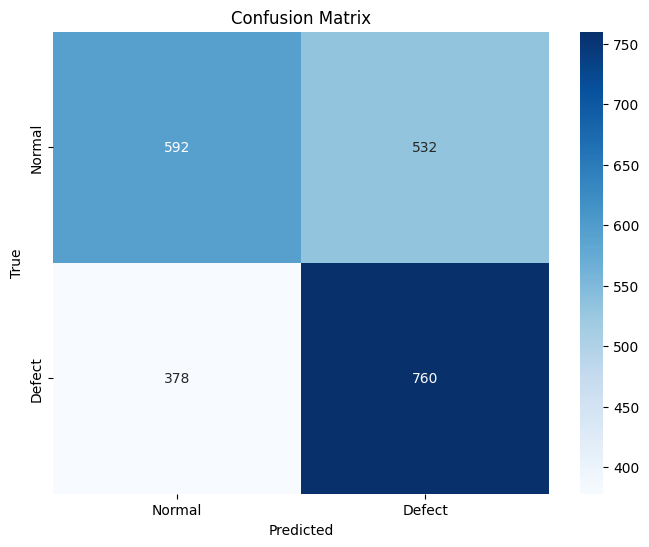

Training Swin Transformer for epoch 72/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [72/100], Loss: 0.6427
Accuracy: 0.6223
Recall: 0.2488
Precision: 0.2499
F1 Score: 0.2485


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


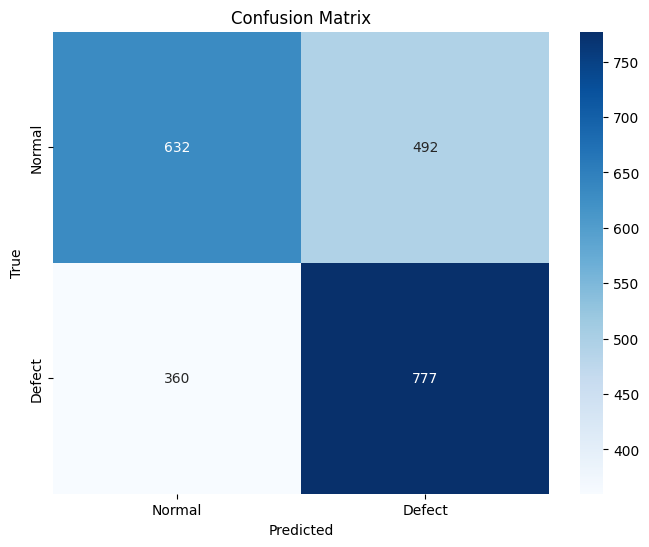

Training Swin Transformer for epoch 73/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [73/100], Loss: 0.6394
Accuracy: 0.6131
Recall: 0.4084
Precision: 0.4107
F1 Score: 0.4069


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


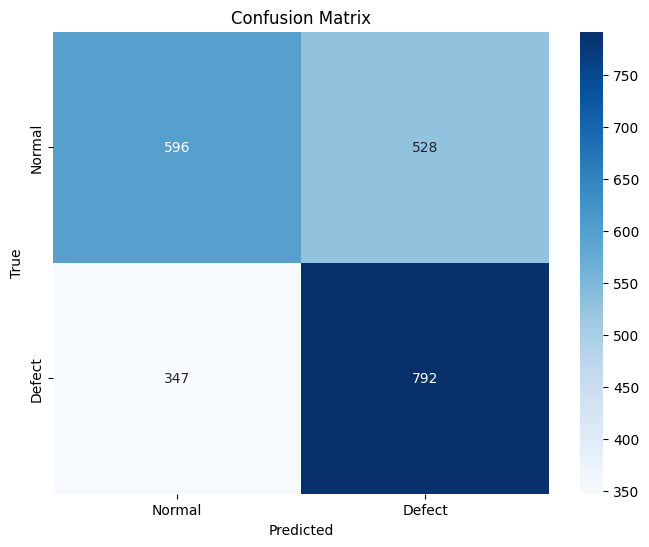

Training Swin Transformer for epoch 74/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [74/100], Loss: 0.6451
Accuracy: 0.6082
Recall: 0.3039
Precision: 0.3054
F1 Score: 0.3033


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


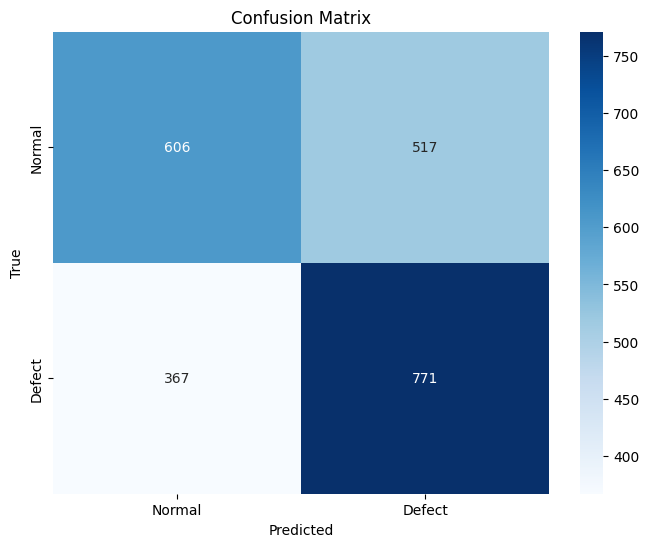

Training Swin Transformer for epoch 75/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [75/100], Loss: 0.6489
Accuracy: 0.5994
Recall: 0.2396
Precision: 0.2407
F1 Score: 0.2392


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


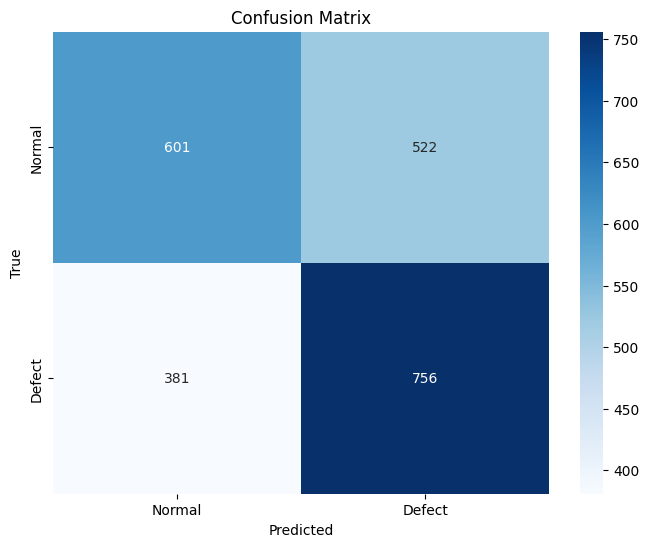

Training Swin Transformer for epoch 76/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [76/100], Loss: 0.6465
Accuracy: 0.6038
Recall: 0.4023
Precision: 0.4034
F1 Score: 0.4016


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


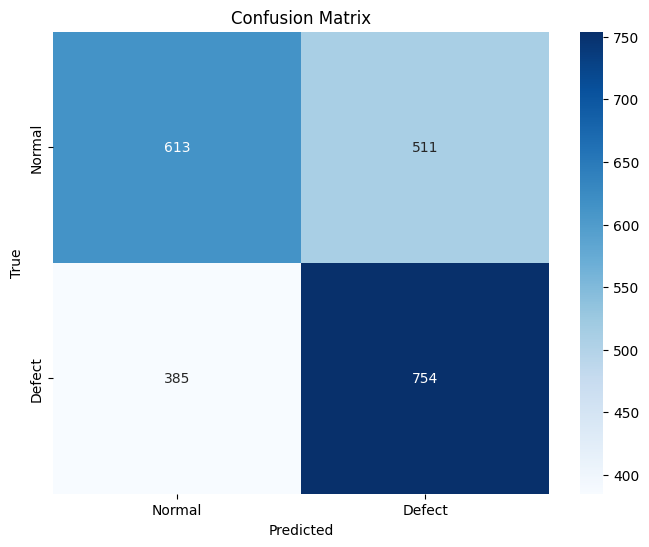

Training Swin Transformer for epoch 77/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [77/100], Loss: 0.6437
Accuracy: 0.6131
Recall: 0.4085
Precision: 0.4099
F1 Score: 0.4076


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


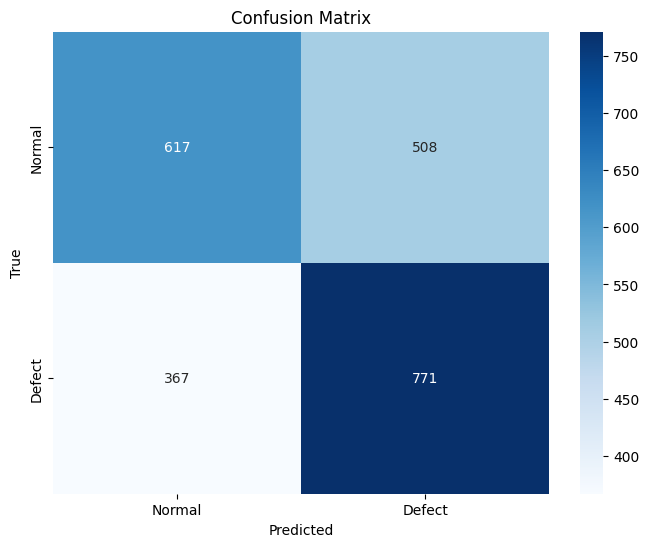

Training Swin Transformer for epoch 78/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [78/100], Loss: 0.6488
Accuracy: 0.6016
Recall: 0.3006
Precision: 0.3018
F1 Score: 0.2999


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


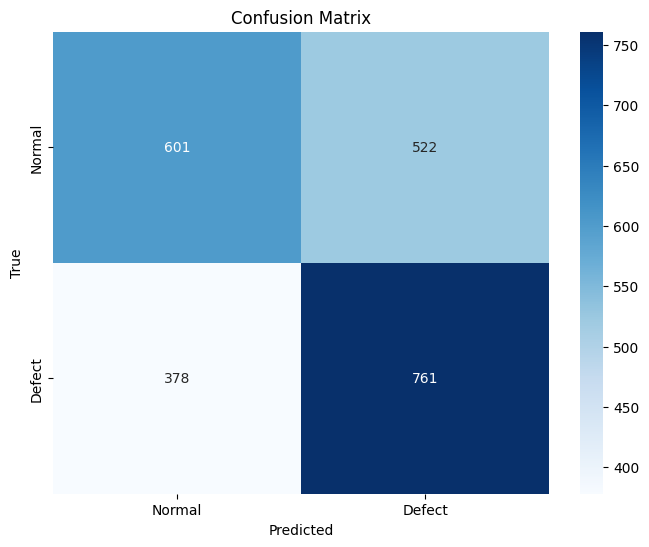

Training Swin Transformer for epoch 79/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [79/100], Loss: 0.6466
Accuracy: 0.5998
Recall: 0.3996
Precision: 0.4007
F1 Score: 0.3990


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


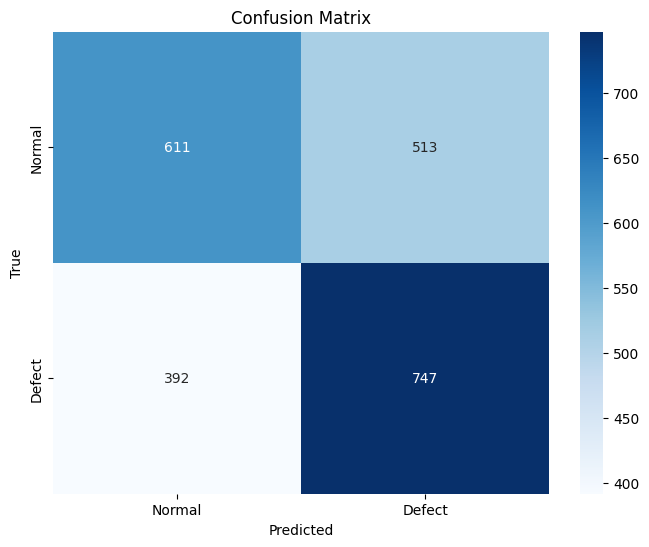

Training Swin Transformer for epoch 80/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [80/100], Loss: 0.6460
Accuracy: 0.6082
Recall: 0.6078
Precision: 0.6096
F1 Score: 0.6064


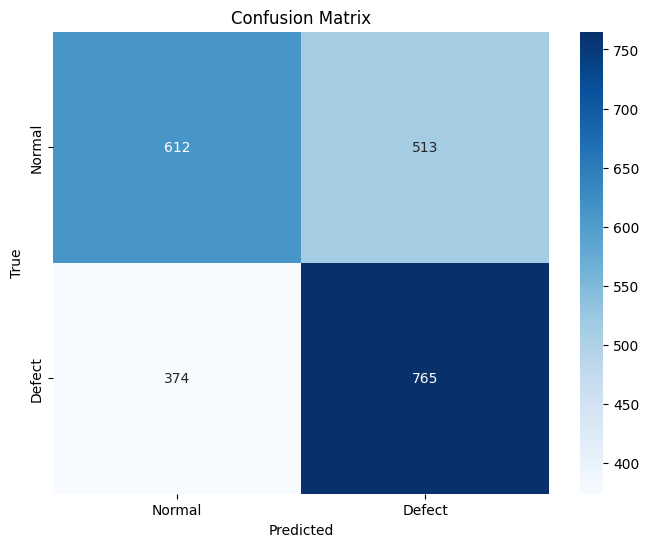

Training Swin Transformer for epoch 81/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [81/100], Loss: 0.6438
Accuracy: 0.6064
Recall: 0.4040
Precision: 0.4062
F1 Score: 0.4027


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


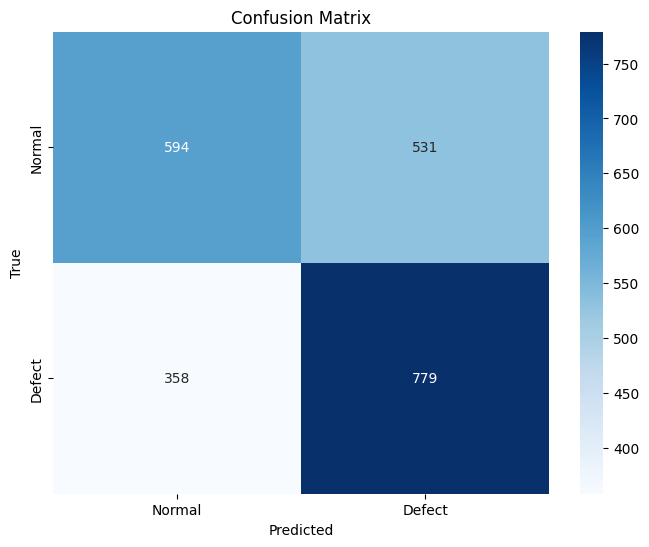

Training Swin Transformer for epoch 82/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [82/100], Loss: 0.6464
Accuracy: 0.6016
Recall: 0.3005
Precision: 0.3023
F1 Score: 0.2995


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


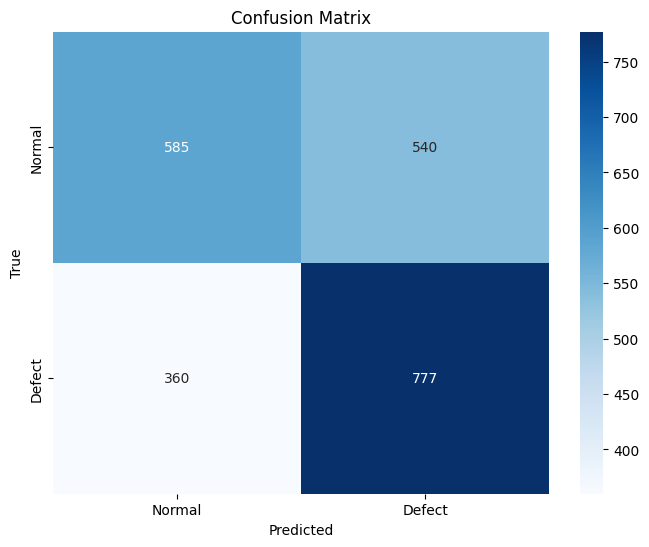

Training Swin Transformer for epoch 83/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [83/100], Loss: 0.6489
Accuracy: 0.6100
Recall: 0.6096
Precision: 0.6115
F1 Score: 0.6081


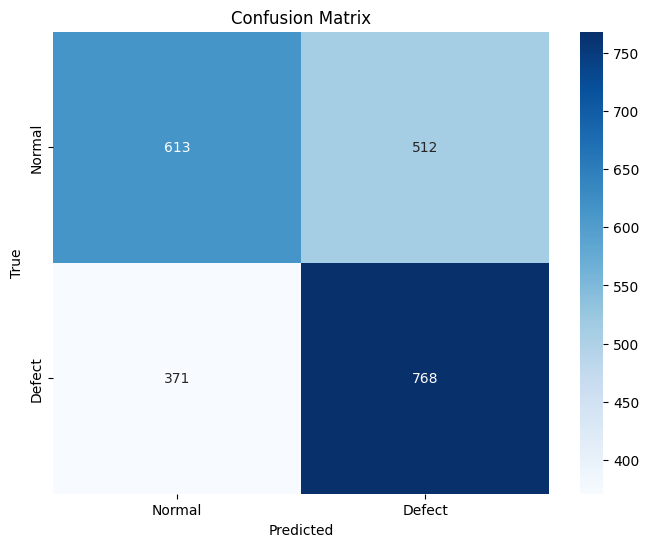

Training Swin Transformer for epoch 84/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [84/100], Loss: 0.6413
Accuracy: 0.6210
Recall: 0.4137
Precision: 0.4158
F1 Score: 0.4128


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


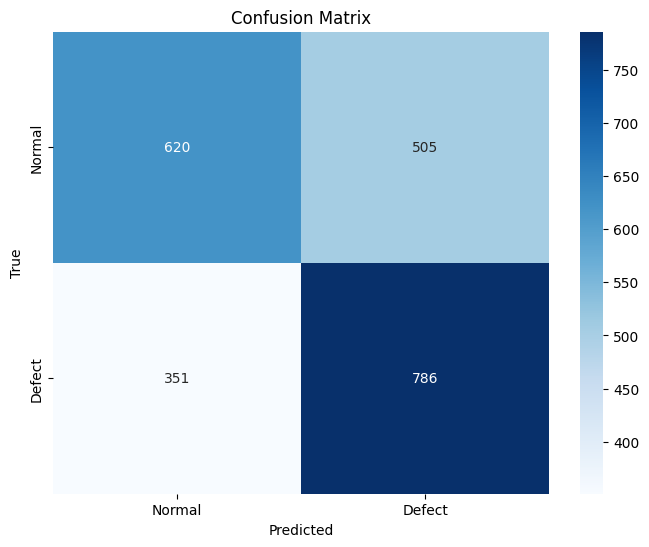

Training Swin Transformer for epoch 85/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [85/100], Loss: 0.6429
Accuracy: 0.6078
Recall: 0.6073
Precision: 0.6095
F1 Score: 0.6057


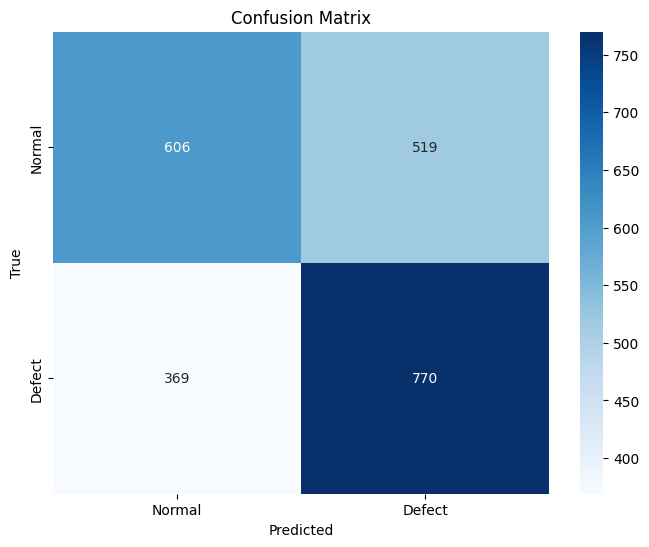

Training Swin Transformer for epoch 86/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [86/100], Loss: 0.6418
Accuracy: 0.6109
Recall: 0.4069
Precision: 0.4093
F1 Score: 0.4058


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


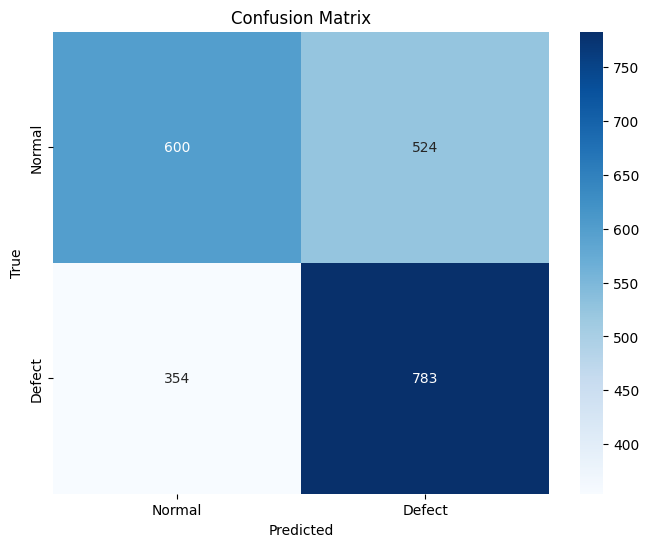

Training Swin Transformer for epoch 87/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [87/100], Loss: 0.6434
Accuracy: 0.6038
Recall: 0.6034
Precision: 0.6054
F1 Score: 0.6017


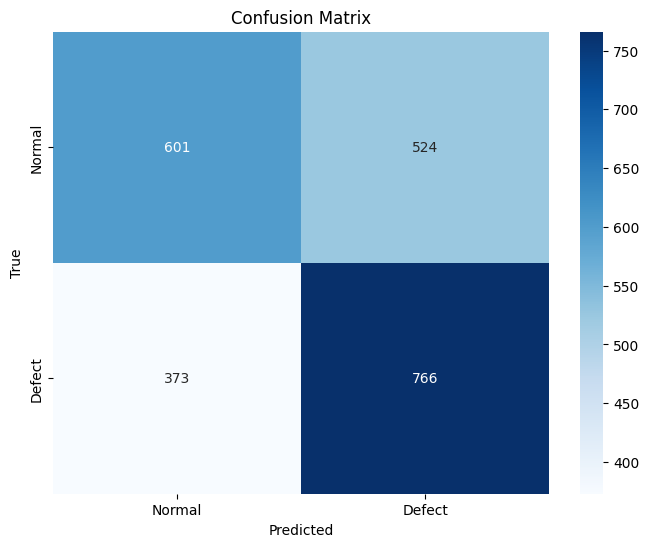

Training Swin Transformer for epoch 88/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [88/100], Loss: 0.6444
Accuracy: 0.6109
Recall: 0.3052
Precision: 0.3068
F1 Score: 0.3046


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


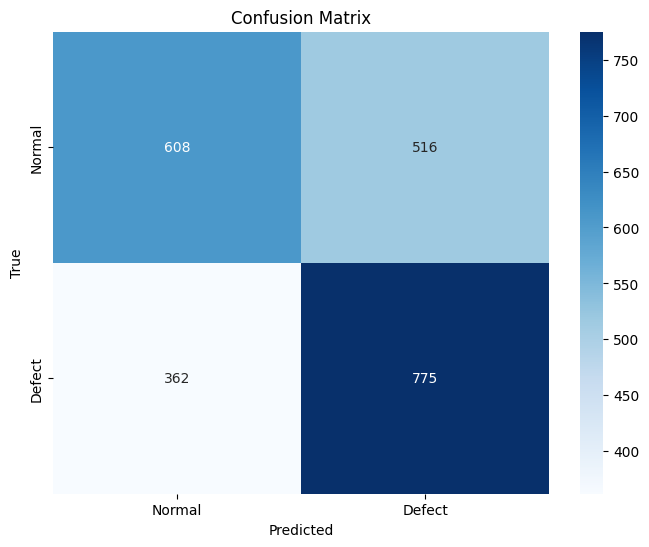

Training Swin Transformer for epoch 89/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [89/100], Loss: 0.6411
Accuracy: 0.6153
Recall: 0.3075
Precision: 0.3088
F1 Score: 0.3072


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


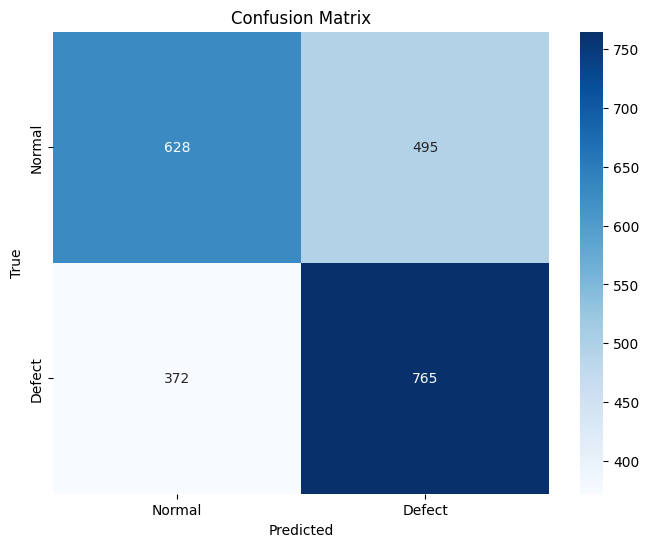

Training Swin Transformer for epoch 90/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [90/100], Loss: 0.6465
Accuracy: 0.6016
Recall: 0.4007
Precision: 0.4029
F1 Score: 0.3994


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


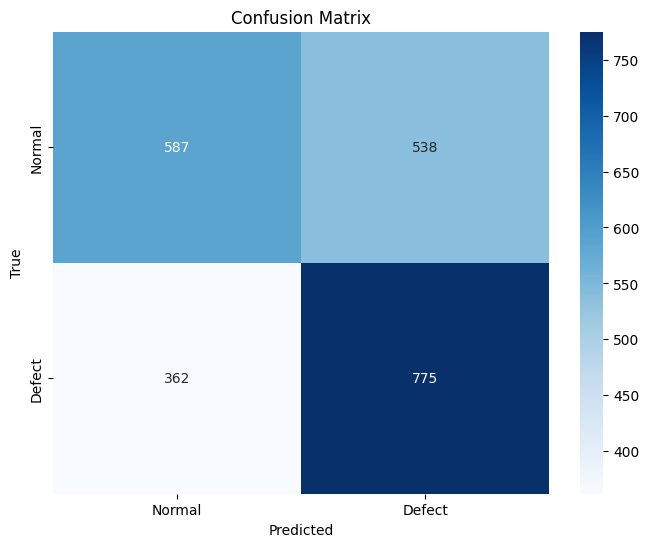

Training Swin Transformer for epoch 91/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [91/100], Loss: 0.6423
Accuracy: 0.6170
Recall: 0.4111
Precision: 0.4126
F1 Score: 0.4103


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


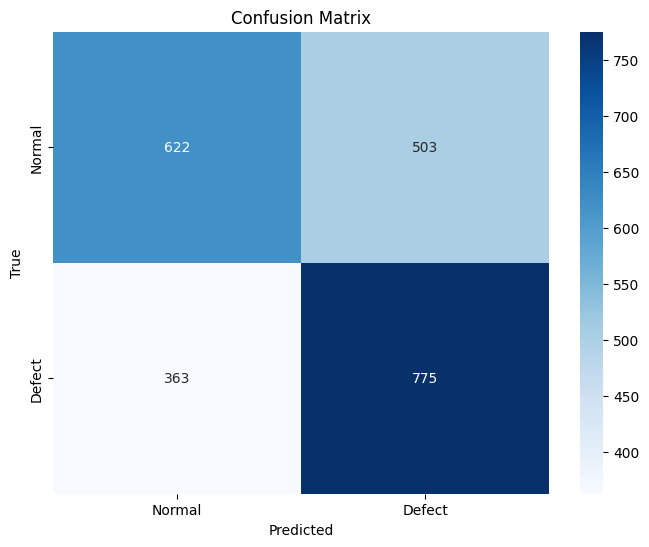

Training Swin Transformer for epoch 92/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [92/100], Loss: 0.6437
Accuracy: 0.6144
Recall: 0.2456
Precision: 0.2467
F1 Score: 0.2453


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


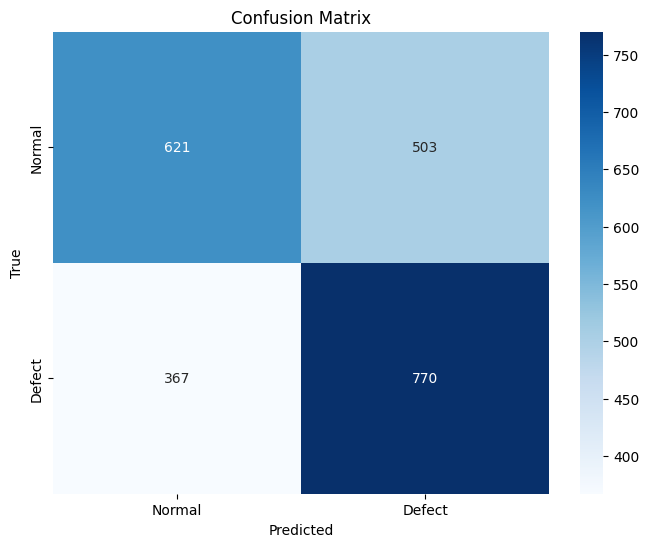

Training Swin Transformer for epoch 93/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [93/100], Loss: 0.6465
Accuracy: 0.6038
Recall: 0.6034
Precision: 0.6051
F1 Score: 0.6020


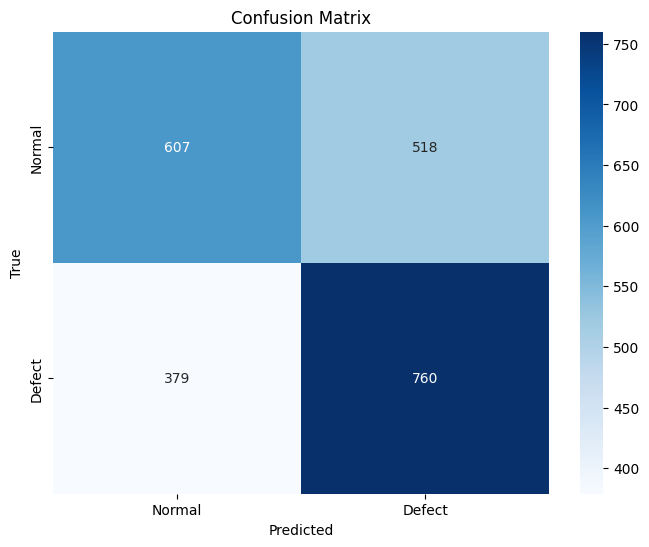

Training Swin Transformer for epoch 94/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [94/100], Loss: 0.6523
Accuracy: 0.6056
Recall: 0.2420
Precision: 0.2437
F1 Score: 0.2415


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


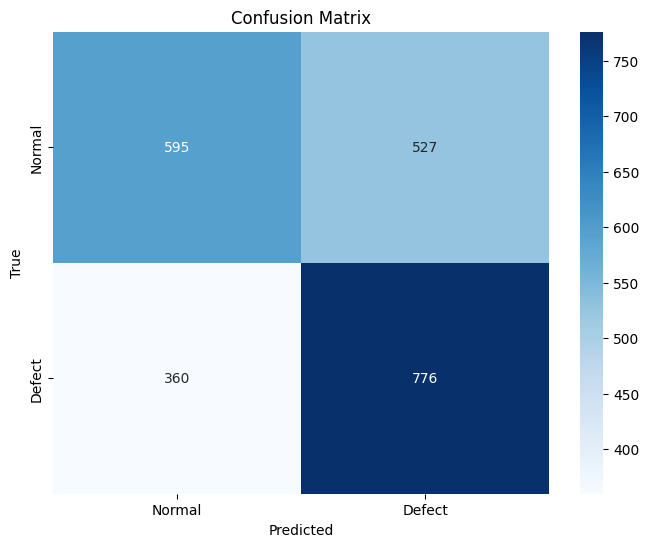

Training Swin Transformer for epoch 95/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [95/100], Loss: 0.6453
Accuracy: 0.5967
Recall: 0.3975
Precision: 0.3991
F1 Score: 0.3963


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


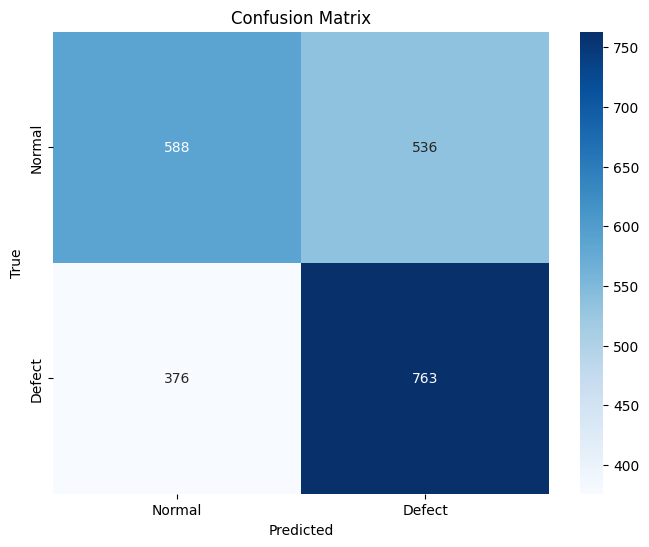

Training Swin Transformer for epoch 96/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [96/100], Loss: 0.6481
Accuracy: 0.6020
Recall: 0.4011
Precision: 0.4024
F1 Score: 0.4003


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


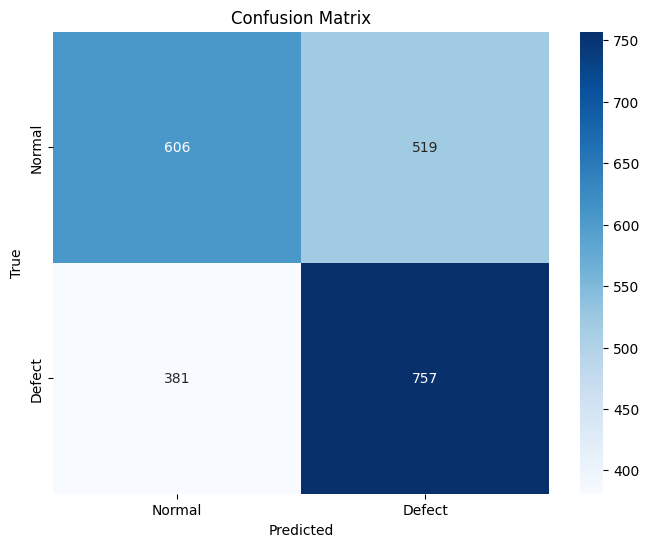

Training Swin Transformer for epoch 97/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [97/100], Loss: 0.6384
Accuracy: 0.6095
Recall: 0.4060
Precision: 0.4086
F1 Score: 0.4045


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


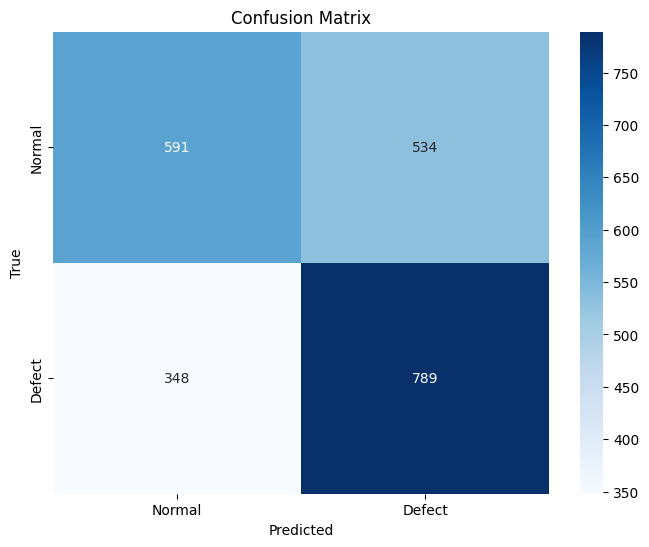

Training Swin Transformer for epoch 98/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [98/100], Loss: 0.6498
Accuracy: 0.6042
Recall: 0.6038
Precision: 0.6064
F1 Score: 0.6016


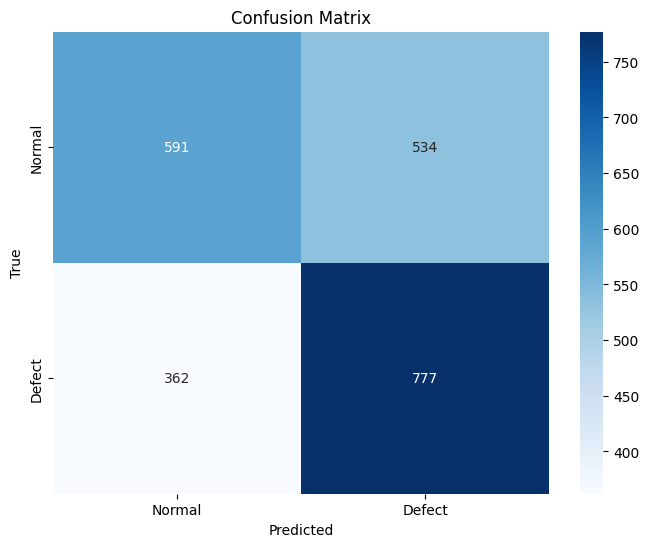

Training Swin Transformer for epoch 99/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [99/100], Loss: 0.6414
Accuracy: 0.6201
Recall: 0.4131
Precision: 0.4151
F1 Score: 0.4122


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


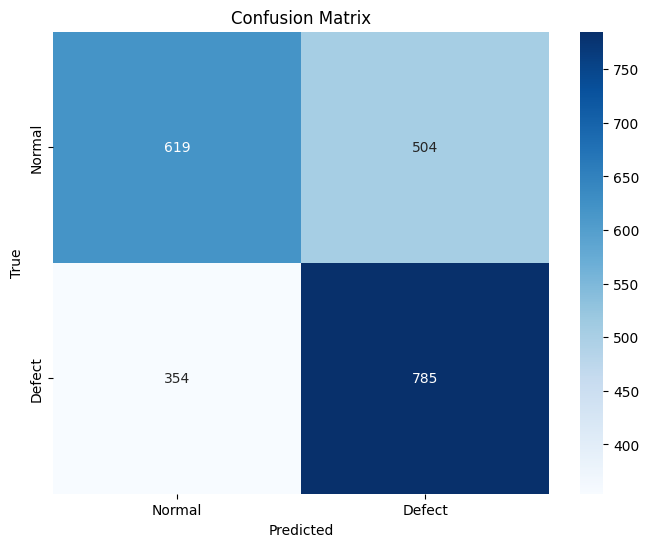

Training Swin Transformer for epoch 100/100


<ipython-input-3-0c292597cd49>:146: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [100/100], Loss: 0.6484
Accuracy: 0.6025
Recall: 0.4013
Precision: 0.4033
F1 Score: 0.3999


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


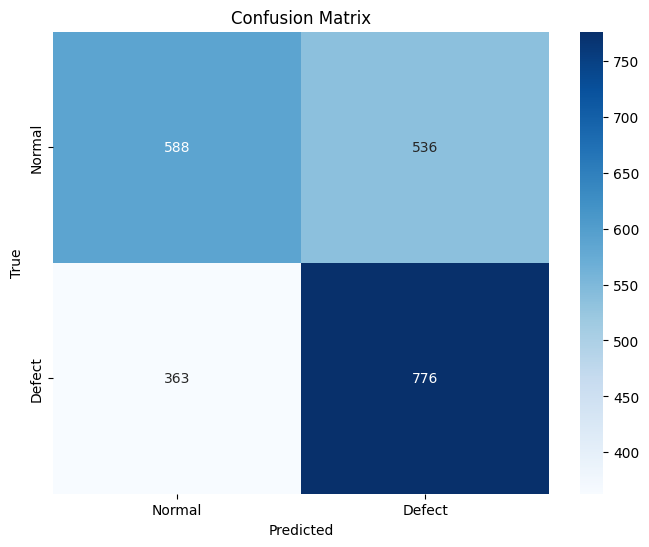

Model saved successfully.


In [ ]:
!pip install timm
import torch
import torch.nn.functional as F
import torch.optim as optim
import timm
import os
import json
from PIL import Image, ImageDraw
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torch.cuda.amp import GradScaler, autocast
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define dataset paths
base_dir = '/content/drive/MyDrive/guangdong1_round1_train2_20190828'
defect_images_dir = os.path.join(base_dir, 'defect_Images')
normal_images_dir = os.path.join(base_dir, 'normal_Images')
anno_file_path = os.path.join(base_dir, 'Annotations', 'anno_train.json')

# Load the annotations from the JSON file
def load_annotations():
    if not os.path.exists(anno_file_path):
        raise FileNotFoundError(f"Annotation file not found: {anno_file_path}")
    with open(anno_file_path, 'r') as f:
        annotations = json.load(f)
    return annotations

def load_image(image_path, bbox=None):
    image = Image.open(image_path).convert('L')  # Load the image in grayscale mode ('L')

    if bbox is not None and isinstance(bbox, list) and len(bbox) > 0:
        draw = ImageDraw.Draw(image)
        if isinstance(bbox[0], list):
            for box in bbox:
                box = [(int(box[0]), int(box[1])), (int(box[0] + box[2]), int(box[1] + box[3]))]
                draw.rectangle(box, outline="red", width=2)
        else:
            box = [(int(bbox[0]), int(bbox[1])), (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))]
            draw.rectangle(box, outline="red", width=2)

    return image

class FabricDataset(Dataset):
    def __init__(self, img_paths, labels, bboxes=None, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.bboxes = bboxes
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]
        bbox = self.bboxes.get(os.path.basename(img_path), None) if self.bboxes else None
        image = load_image(img_path, bbox)
        if self.transform:
            image = self.transform(image)
        return image, label

# Load data with bounding boxes
def load_data(annotations):
    img_paths = []
    img_labels = []
    img_bboxes = {}

    # Load defect images
    for img_name in os.listdir(defect_images_dir):
        img_path = os.path.join(defect_images_dir, img_name)
        img_paths.append(img_path)
        img_annotations = [a for a in annotations if a['name'] == img_name]
        img_labels.append(1)  # Defect label
        if img_annotations:
            img_bboxes[img_name] = [anno['bbox'] for anno in img_annotations]

    # Load normal images
    for img_name in os.listdir(normal_images_dir):
        img_path = os.path.join(normal_images_dir, img_name)
        img_paths.append(img_path)
        img_labels.append(0)  # Normal label

    return img_paths, img_labels, img_bboxes

def compute_metrics(predictions, true_labels):
    acc = accuracy_score(true_labels, predictions)
    rec = recall_score(true_labels, predictions, average='macro')
    prec = precision_score(true_labels, predictions, average='macro')
    f1 = f1_score(true_labels, predictions, average='macro')
    conf_matrix = confusion_matrix(true_labels, predictions, labels=[0, 1])

    print(f'Accuracy: {acc:.4f}')
    print(f'Recall: {rec:.4f}')
    print(f'Precision: {prec:.4f}')
    print(f'F1 Score: {f1:.4f}')
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Defect'], yticklabels=['Normal', 'Defect'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def train_and_evaluate_swin(model, optimizer, num_epochs=100, batch_size=8, use_mixed_precision=False):
    annotations = load_annotations()
    img_paths, img_labels, img_bboxes = load_data(annotations)

    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ])

    dataset = FabricDataset(img_paths, img_labels, img_bboxes, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)  # Reduced num_workers
    global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))
    scaler = GradScaler() if use_mixed_precision else None

    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)
    reduce_lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6)

    for epoch in range(num_epochs):
        print(f"Training Swin Transformer for epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        predictions = []
        true_labels = []

        for batch_imgs, batch_labels in dataloader:
            batch_imgs = batch_imgs.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()

            if use_mixed_precision:
                with autocast():
                    outputs = model(batch_imgs)
                    outputs = global_avg_pool(outputs).view(outputs.size(0), -1)
                    loss = F.cross_entropy(outputs, batch_labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(batch_imgs)
                outputs = global_avg_pool(outputs).view(outputs.size(0), -1)
                loss = F.cross_entropy(outputs, batch_labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * batch_imgs.size(0)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.tolist())
            true_labels.extend(batch_labels.tolist())

        epoch_loss = running_loss / len(dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        compute_metrics(predictions, true_labels)

        # Step the scheduler
        scheduler.step()
        reduce_lr_scheduler.step(epoch_loss)

def initialize_swin_model():
    swin_model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)

    # Modify the first convolution layer to accept grayscale (1-channel) input
    swin_model.patch_embed.proj = torch.nn.Conv2d(1, swin_model.patch_embed.proj.out_channels,
                                                  kernel_size=swin_model.patch_embed.proj.kernel_size,
                                                  stride=swin_model.patch_embed.proj.stride,
                                                  padding=swin_model.patch_embed.proj.padding)

    # Unfreeze all layers for fine-tuning
    for param in swin_model.parameters():
        param.requires_grad = True

    # Update the classifier head to output 2 classes (defect vs. normal)
    swin_model.head = torch.nn.Linear(swin_model.head.in_features, 2)
    return swin_model

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = initialize_swin_model().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

    # Train and evaluate the Swin Transformer model for 100 epochs with mixed precision if CUDA is available
    train_and_evaluate_swin(model, optimizer, num_epochs=100, use_mixed_precision=(device.type == 'cuda'))

    # Save the trained model
    torch.save(model.state_dict(), '/content/drive/MyDrive/swin100.pth')
    print("Model saved successfully.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training Swin Transformer for epoch 1/100


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-7-c61859dd4f2d>:137: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler() if use_mixed_precision else None
<ipython-input-7-c61859dd4f2d>:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [1/100], Loss: 0.9086
Accuracy: 0.5075
Recall: 0.1451
Precision: 0.1481
F1 Score: 0.1440


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


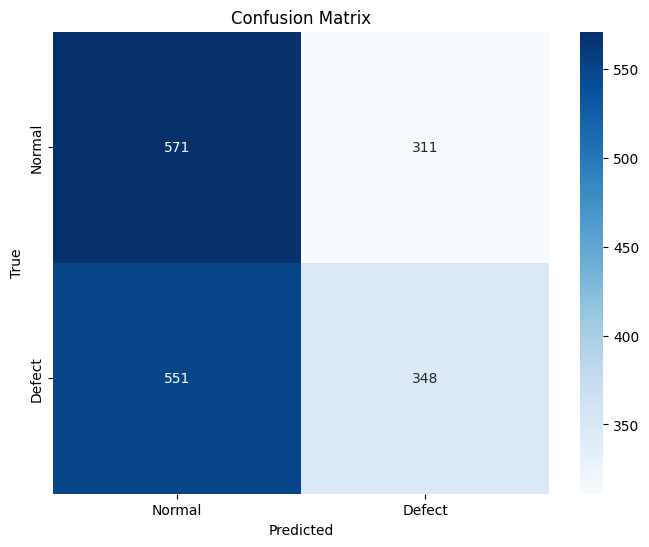

Training Swin Transformer for epoch 2/100


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-7-c61859dd4f2d>:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [2/100], Loss: 0.7119
Accuracy: 0.5533
Recall: 0.5530
Precision: 0.5547
F1 Score: 0.5497


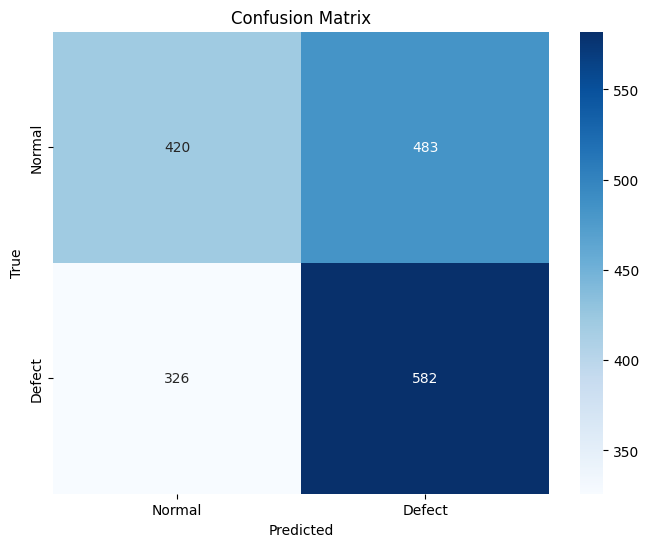

Training Swin Transformer for epoch 3/100


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-7-c61859dd4f2d>:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [3/100], Loss: 0.6999
Accuracy: 0.5472
Recall: 0.3646
Precision: 0.3670
F1 Score: 0.3598


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


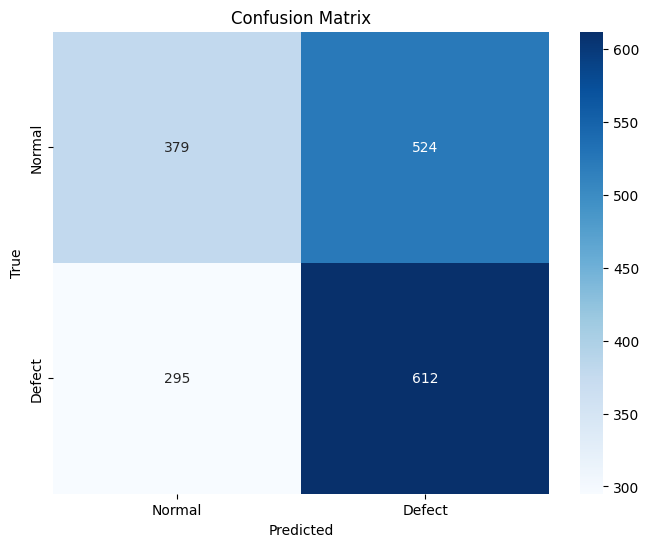

Training Swin Transformer for epoch 4/100


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-7-c61859dd4f2d>:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [4/100], Loss: 0.6870
Accuracy: 0.5555
Recall: 0.5553
Precision: 0.5567
F1 Score: 0.5525


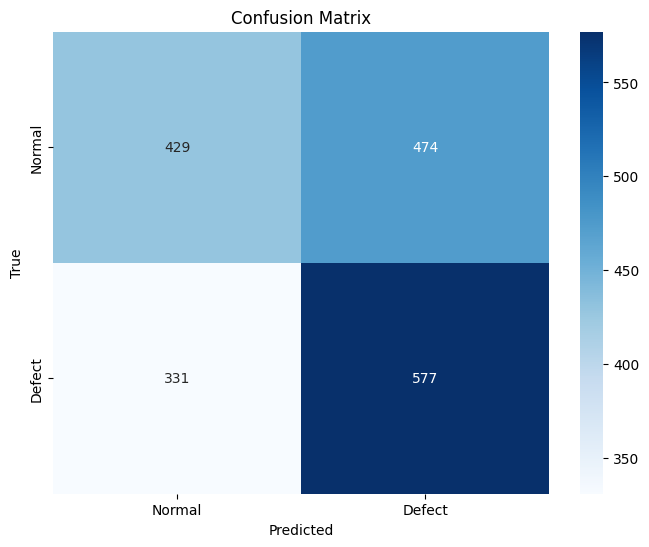

Training Swin Transformer for epoch 5/100


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-7-c61859dd4f2d>:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [5/100], Loss: 0.6848
Accuracy: 0.5676
Recall: 0.3783
Precision: 0.3804
F1 Score: 0.3758


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


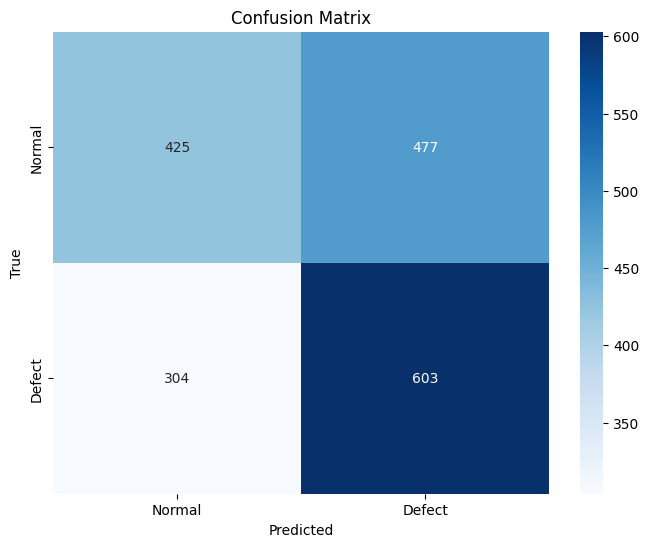

Training Swin Transformer for epoch 6/100


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-7-c61859dd4f2d>:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [6/100], Loss: 0.6768
Accuracy: 0.5665
Recall: 0.2830
Precision: 0.2903
F1 Score: 0.2734


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


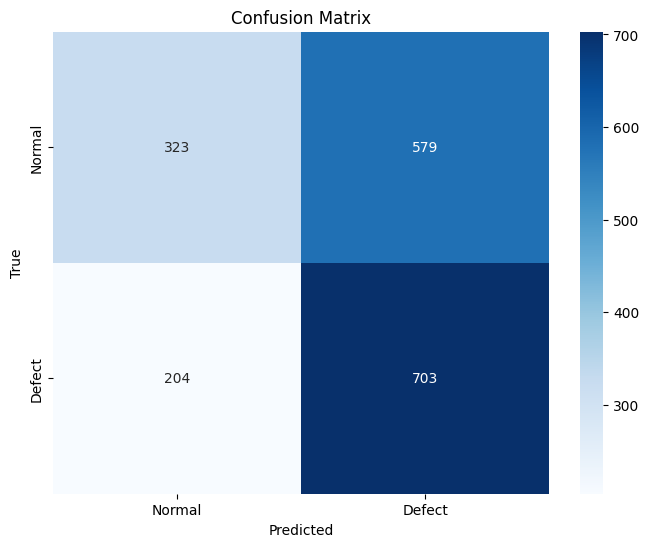

Training Swin Transformer for epoch 7/100


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-7-c61859dd4f2d>:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [7/100], Loss: 0.6754
Accuracy: 0.5820
Recall: 0.5818
Precision: 0.5841
F1 Score: 0.5790


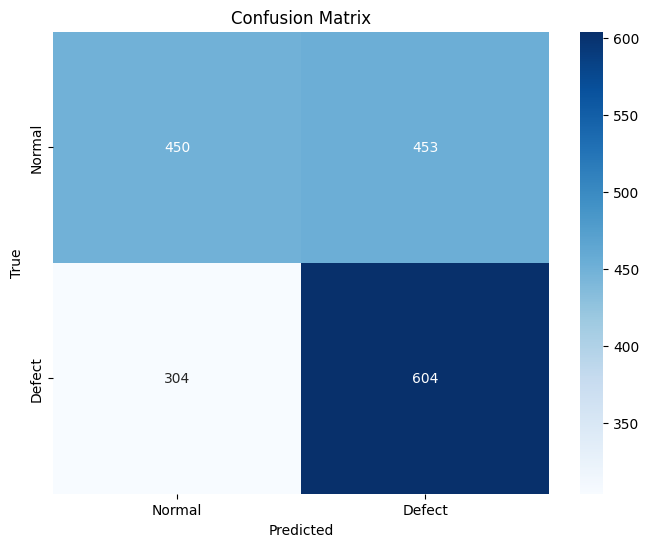

Training Swin Transformer for epoch 8/100


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-7-c61859dd4f2d>:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch [8/100], Loss: 0.6851
Accuracy: 0.5809
Recall: 0.3871
Precision: 0.3890
F1 Score: 0.3851


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


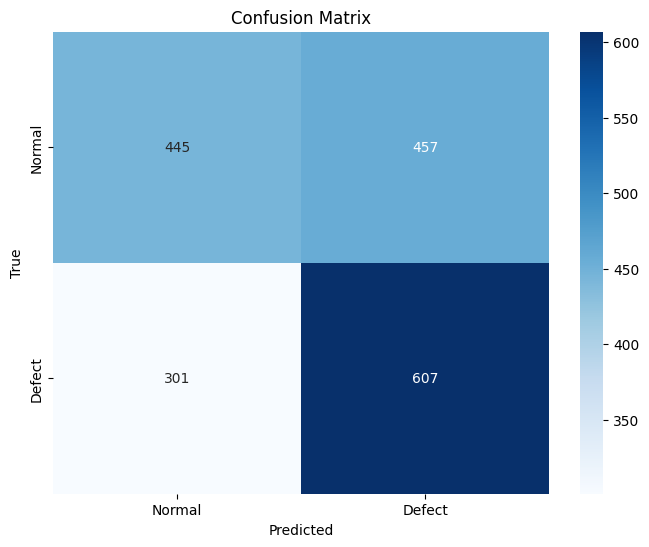

Training Swin Transformer for epoch 9/100


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
<ipython-input-7-c61859dd4f2d>:156: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


In [ ]:
!pip install timm
import torch
import torch.nn.functional as F
import torch.optim as optim
import timm
import os
import json
from PIL import Image, ImageDraw
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, OneCycleLR
from sklearn.model_selection import train_test_split
from torch.cuda.amp import GradScaler, autocast
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define dataset paths
base_dir = '/content/drive/MyDrive/guangdong1_round1_train2_20190828'
defect_images_dir = os.path.join(base_dir, 'defect_Images')
normal_images_dir = os.path.join(base_dir, 'normal_Images')
anno_file_path = os.path.join(base_dir, 'Annotations', 'anno_train.json')

# Load the annotations from the JSON file
def load_annotations():
    if not os.path.exists(anno_file_path):
        raise FileNotFoundError(f"Annotation file not found: {anno_file_path}")
    with open(anno_file_path, 'r') as f:
        annotations = json.load(f)
    return annotations

def load_image(image_path, bbox=None):
    image = Image.open(image_path).convert('L')  # Load the image in grayscale mode ('L')

    if bbox is not None and isinstance(bbox, list) and len(bbox) > 0:
        draw = ImageDraw.Draw(image)
        if isinstance(bbox[0], list):
            for box in bbox:
                box = [(int(box[0]), int(box[1])), (int(box[0] + box[2]), int(box[1] + box[3]))]
                draw.rectangle(box, outline="red", width=2)
        else:
            box = [(int(bbox[0]), int(bbox[1])), (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))]
            draw.rectangle(box, outline="red", width=2)

    return image

class FabricDataset(Dataset):
    def __init__(self, img_paths, labels, bboxes=None, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.bboxes = bboxes
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]
        bbox = self.bboxes.get(os.path.basename(img_path), None) if self.bboxes else None
        image = load_image(img_path, bbox)
        if self.transform:
            image = self.transform(image)
        return image, label

# Load data with bounding boxes
def load_data(annotations):
    img_paths = []
    img_labels = []
    img_bboxes = {}

    # Load defect images
    for img_name in os.listdir(defect_images_dir):
        img_path = os.path.join(defect_images_dir, img_name)
        img_paths.append(img_path)
        img_annotations = [a for a in annotations if a['name'] == img_name]
        img_labels.append(1)  # Defect label
        if img_annotations:
            img_bboxes[img_name] = [anno['bbox'] for anno in img_annotations]

    # Load normal images
    for img_name in os.listdir(normal_images_dir):
        img_path = os.path.join(normal_images_dir, img_name)
        img_paths.append(img_path)
        img_labels.append(0)  # Normal label

    return img_paths, img_labels, img_bboxes

def compute_metrics(predictions, true_labels):
    acc = accuracy_score(true_labels, predictions)
    rec = recall_score(true_labels, predictions, average='macro')
    prec = precision_score(true_labels, predictions, average='macro')
    f1 = f1_score(true_labels, predictions, average='macro')
    conf_matrix = confusion_matrix(true_labels, predictions, labels=[0, 1])

    print(f'Accuracy: {acc:.4f}')
    print(f'Recall: {rec:.4f}')
    print(f'Precision: {prec:.4f}')
    print(f'F1 Score: {f1:.4f}')
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Defect'], yticklabels=['Normal', 'Defect'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def train_and_evaluate_swin(model, optimizer, scheduler, num_epochs=100, batch_size=8, use_mixed_precision=False):
    annotations = load_annotations()
    img_paths, img_labels, img_bboxes = load_data(annotations)

    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229])
    ])

    # Split the dataset into training and validation sets
    train_paths, val_paths, train_labels, val_labels = train_test_split(img_paths, img_labels, test_size=0.2, random_state=42)

    # Create dataset objects for training and validation
    train_dataset = FabricDataset(img_paths=train_paths, labels=train_labels, bboxes=img_bboxes, transform=preprocess)
    val_dataset = FabricDataset(img_paths=val_paths, labels=val_labels, transform=preprocess)

    # Create DataLoader for both training and validation
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

    global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))
    scaler = GradScaler() if use_mixed_precision else None

    # Initialize the learning rate scheduler inside the training loop
    scheduler = OneCycleLR(optimizer, max_lr=1e-3, epochs=num_epochs, steps_per_epoch=len(train_loader))

    for epoch in range(num_epochs):
        print(f"Training Swin Transformer for epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        predictions = []
        true_labels = []

        for batch_imgs, batch_labels in train_loader:
            batch_imgs = batch_imgs.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()

            if use_mixed_precision:
                with autocast():
                    outputs = model(batch_imgs)
                    outputs = global_avg_pool(outputs).view(outputs.size(0), -1)
                    loss = F.cross_entropy(outputs, batch_labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(batch_imgs)
                outputs = global_avg_pool(outputs).view(outputs.size(0), -1)
                loss = F.cross_entropy(outputs, batch_labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * batch_imgs.size(0)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.tolist())
            true_labels.extend(batch_labels.tolist())

        epoch_loss = running_loss / len(train_dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        compute_metrics(predictions, true_labels)

        # Step the scheduler
        scheduler.step()

def initialize_swin_model():
    swin_model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)

    # Modify the first convolution layer to accept grayscale (1-channel) input
    swin_model.patch_embed.proj = torch.nn.Conv2d(1, swin_model.patch_embed.proj.out_channels,
                                                  kernel_size=swin_model.patch_embed.proj.kernel_size,
                                                  stride=swin_model.patch_embed.proj.stride,
                                                  padding=swin_model.patch_embed.proj.padding)

    # Unfreeze all layers for fine-tuning
    for param in swin_model.parameters():
        param.requires_grad = True

    # Update the classifier head to output 2 classes (defect vs. normal)
    swin_model.head = torch.nn.Linear(swin_model.head.in_features, 2)
    return swin_model

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = initialize_swin_model().to(device)
    optimizer = optim.AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

    # Train and evaluate the Swin Transformer model for 100 epochs with mixed precision if CUDA is available
    train_and_evaluate_swin(model, optimizer, scheduler=None, num_epochs=100, use_mixed_precision=(device.type == 'cuda'))

    # Save the trained model
    torch.save(model.state_dict(), '/content/drive/MyDrive/swinNew100.pth')
    print("Model saved successfully.")


In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import timm
import os
import json
from PIL import Image, ImageDraw
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define dataset paths
base_dir = '/content/drive/MyDrive/guangdong1_round1_train2_20190828'
defect_images_dir = os.path.join(base_dir, 'defect_Images')
normal_images_dir = os.path.join(base_dir, 'normal_Images')
anno_file_path = os.path.join(base_dir, 'Annotations', 'anno_train.json')

# Load the annotations from the JSON file
def load_annotations():
    if not os.path.exists(anno_file_path):
        raise FileNotFoundError(f"Annotation file not found: {anno_file_path}")
    with open(anno_file_path, 'r') as f:
        annotations = json.load(f)
    return annotations

def load_image(image_path, bbox=None):
    image = Image.open(image_path).convert('L')  # Directly load the image in grayscale mode ('L')

    if bbox is not None and isinstance(bbox, list) and len(bbox) > 0:
        draw = ImageDraw.Draw(image)
        if isinstance(bbox[0], list):
            for box in bbox:
                box = [(int(box[0]), int(box[1])), (int(box[0] + box[2]), int(box[1] + box[3]))]
                draw.rectangle(box, outline="red", width=2)
        else:
            bbox = [(int(bbox[0]), int(bbox[1])), (int(bbox[0] + box[2]), int(bbox[1] + bbox[3]))]
            draw.rectangle(bbox, outline="red", width=2)

    return image

class FabricDataset(Dataset):
    def __init__(self, img_paths, labels, bboxes=None, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.bboxes = bboxes
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]
        bbox = self.bboxes.get(os.path.basename(img_path), None) if self.bboxes else None
        image = load_image(img_path, bbox)
        if self.transform:
            image = self.transform(image)
        return image, label

# Load data with bounding boxes
def load_data(annotations):
    img_paths = []
    img_labels = []
    img_bboxes = {}

    for img_name in os.listdir(defect_images_dir):
        img_path = os.path.join(defect_images_dir, img_name)
        img_paths.append(img_path)
        img_annotations = [a for a in annotations if a['name'] == img_name]
        if img_annotations:
            img_labels.append(1)  # Defect label
            img_bboxes[img_name] = [anno['bbox'] for anno in img_annotations]
        else:
            img_labels.append(0)  # Normal label

    for img_name in os.listdir(normal_images_dir):
        img_path = os.path.join(normal_images_dir, img_name)
        img_paths.append(img_path)
        img_labels.append(0)  # Normal label

    return img_paths, img_labels, img_bboxes

def compute_metrics(predictions, true_labels):
    acc = accuracy_score(true_labels, predictions)
    rec = recall_score(true_labels, predictions, average='macro')
    prec = precision_score(true_labels, predictions, average='macro')
    f1 = f1_score(true_labels, predictions, average='macro')
    conf_matrix = confusion_matrix(true_labels, predictions, labels=[0, 1])

    print(f'Accuracy: {acc:.4f}')
    print(f'Recall: {rec:.4f}')
    print(f'Precision: {prec:.4f}')
    print(f'F1 Score: {f1:.4f}')

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Defect'], yticklabels=['Normal', 'Defect'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def train_and_evaluate_swin(model, optimizer, num_epochs=60, batch_size=8, use_mixed_precision=False):
    annotations = load_annotations()
    img_paths, img_labels, img_bboxes = load_data(annotations)

    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(),
        transforms.ToTensor()
    ])

    dataset = FabricDataset(img_paths, img_labels, img_bboxes, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))
    scaler = torch.cuda.amp.GradScaler() if use_mixed_precision else None

    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

    for epoch in range(num_epochs):
        print(f"Training Swin Transformer for epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        predictions = []
        true_labels = []

        for batch_imgs, batch_labels in dataloader:
            batch_imgs = batch_imgs.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()

            if use_mixed_precision:
                with torch.cuda.amp.autocast():
                    outputs = model(batch_imgs)
                    outputs = global_avg_pool(outputs).view(outputs.size(0), -1)
                    loss = F.cross_entropy(outputs, batch_labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(batch_imgs)
                outputs = global_avg_pool(outputs).view(outputs.size(0), -1)
                loss = F.cross_entropy(outputs, batch_labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * batch_imgs.size(0)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.tolist())
            true_labels.extend(batch_labels.tolist())

        epoch_loss = running_loss / len(dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        compute_metrics(predictions, true_labels)

        # Step the scheduler
        scheduler.step()

def initialize_swin_model():
    swin_model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)

    # Modify the first convolution layer to accept grayscale (1-channel) input
    swin_model.patch_embed.proj = torch.nn.Conv2d(1, swin_model.patch_embed.proj.out_channels,
                                                  kernel_size=swin_model.patch_embed.proj.kernel_size,
                                                  stride=swin_model.patch_embed.proj.stride,
                                                  padding=swin_model.patch_embed.proj.padding)

    # Unfreeze all layers for fine-tuning
    for param in swin_model.parameters():
        param.requires_grad = True

    # Update the classifier head to output 2 classes (defect vs. normal)
    swin_model.head = torch.nn.Linear(swin_model.head.in_features, 2)
    return swin_model

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = initialize_swin_model().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Train and evaluate the Swin Transformer model for 20 epochs with mixed precision if CUDA is available
    train_and_evaluate_swin(model, optimizer, num_epochs=60, use_mixed_precision=(device.type == 'cuda'))

    # Save the trained model
    torch.save(model.state_dict(), '/content/drive/MyDrive/swin_model.pth')
    print("Model saved successfully.")


Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Training Swin Transformer for epoch 1/60


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
<ipython-input-2-49836a3144fb>:123: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if use_mixed_precision else None


OSError: Caught OSError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/worker.py", line 351, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/_utils/fetch.py", line 52, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-2-49836a3144fb>", line 62, in __getitem__
    image = load_image(img_path, bbox)
  File "<ipython-input-2-49836a3144fb>", line 34, in load_image
    image = Image.open(image_path).convert('L')  # Directly load the image in grayscale mode ('L')
  File "/usr/local/lib/python3.10/dist-packages/PIL/Image.py", line 3442, in open
    prefix = fp.read(16)
OSError: [Errno 107] Transport endpoint is not connected


Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/114M [00:00<?, ?B/s]

Training Swin Transformer for epoch 1/30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/30], Loss: 0.9443
Accuracy: 0.5093
Recall: 0.1459
Precision: 0.1503
F1 Score: 0.1416


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


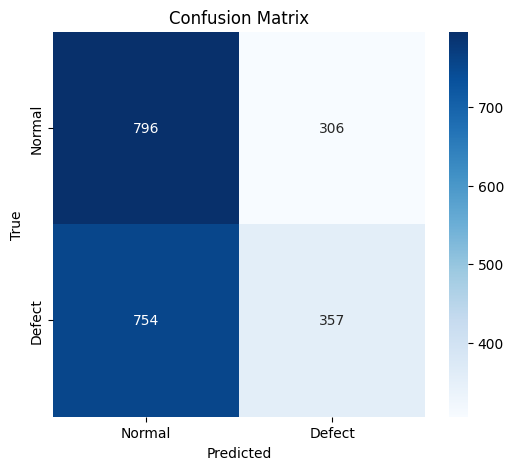

Training Swin Transformer for epoch 2/30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import timm
import os
import json
from PIL import Image, ImageDraw
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define dataset paths
base_dir = '/content/drive/MyDrive/guangdong1_round1_train2_20190828'
defect_images_dir = os.path.join(base_dir, 'defect_Images')
normal_images_dir = os.path.join(base_dir, 'normal_Images')
anno_file_path = os.path.join(base_dir, 'Annotations', 'anno_train.json')

# Load the annotations from the JSON file
def load_annotations():
    if not os.path.exists(anno_file_path):
        raise FileNotFoundError(f"Annotation file not found: {anno_file_path}")
    with open(anno_file_path, 'r') as f:
        annotations = json.load(f)
    return annotations

def load_image(image_path, bbox=None):
    image = Image.open(image_path).convert('L')  # Directly load the image in grayscale mode ('L')

    if bbox is not None and isinstance(bbox, list) and len(bbox) > 0:
        draw = ImageDraw.Draw(image)
        if isinstance(bbox[0], list):
            for box in bbox:
                box = [(int(box[0]), int(box[1])), (int(box[0] + box[2]), int(box[1] + box[3]))]
                draw.rectangle(box, outline="red", width=2)
        else:
            bbox = [(int(bbox[0]), int(bbox[1])), (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))]
            draw.rectangle(bbox, outline="red", width=2)

    return image

class FabricDataset(Dataset):
    def __init__(self, img_paths, labels, bboxes=None, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.bboxes = bboxes
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]
        bbox = self.bboxes.get(os.path.basename(img_path), None) if self.bboxes else None
        image = load_image(img_path, bbox)
        if self.transform:
            image = self.transform(image)
        return image, label

# Load data with bounding boxes
def load_data(annotations):
    img_paths = []
    img_labels = []
    img_bboxes = {}

    for img_name in os.listdir(defect_images_dir):
        img_path = os.path.join(defect_images_dir, img_name)
        img_paths.append(img_path)
        img_annotations = [a for a in annotations if a['name'] == img_name]
        if img_annotations:
            img_labels.append(1)  # Defect label
            img_bboxes[img_name] = [anno['bbox'] for anno in img_annotations]
        else:
            img_labels.append(0)  # Normal label

    for img_name in os.listdir(normal_images_dir):
        img_path = os.path.join(normal_images_dir, img_name)
        img_paths.append(img_path)
        img_labels.append(0)  # Normal label

    return img_paths, img_labels, img_bboxes

def compute_metrics(predictions, true_labels):
    acc = accuracy_score(true_labels, predictions)
    rec = recall_score(true_labels, predictions, average='macro')
    prec = precision_score(true_labels, predictions, average='macro')
    f1 = f1_score(true_labels, predictions, average='macro')
    conf_matrix = confusion_matrix(true_labels, predictions, labels=[0, 1])

    print(f'Accuracy: {acc:.4f}')
    print(f'Recall: {rec:.4f}')
    print(f'Precision: {prec:.4f}')
    print(f'F1 Score: {f1:.4f}')

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Defect'], yticklabels=['Normal', 'Defect'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def train_and_evaluate_swin(model, optimizer, num_epochs=30, batch_size=8, use_mixed_precision=False):
    annotations = load_annotations()
    img_paths, img_labels, img_bboxes = load_data(annotations)

    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(),
        transforms.ToTensor()
    ])

    dataset = FabricDataset(img_paths, img_labels, img_bboxes, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))
    scaler = torch.cuda.amp.GradScaler() if use_mixed_precision else None

    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

    for epoch in range(num_epochs):
        print(f"Training Swin Transformer for epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        predictions = []
        true_labels = []

        for batch_imgs, batch_labels in dataloader:
            batch_imgs = batch_imgs.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()

            if use_mixed_precision:
                with torch.cuda.amp.autocast():
                    outputs = model(batch_imgs)
                    outputs = global_avg_pool(outputs).view(outputs.size(0), -1)
                    loss = F.cross_entropy(outputs, batch_labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(batch_imgs)
                outputs = global_avg_pool(outputs).view(outputs.size(0), -1)
                loss = F.cross_entropy(outputs, batch_labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * batch_imgs.size(0)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.tolist())
            true_labels.extend(batch_labels.tolist())

        epoch_loss = running_loss / len(dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        compute_metrics(predictions, true_labels)

        # Step the scheduler
        scheduler.step()

def initialize_swin_model():
    swin_model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)

    # Modify the first convolution layer to accept grayscale (1-channel) input
    swin_model.patch_embed.proj = torch.nn.Conv2d(1, swin_model.patch_embed.proj.out_channels,
                                                  kernel_size=swin_model.patch_embed.proj.kernel_size,
                                                  stride=swin_model.patch_embed.proj.stride,
                                                  padding=swin_model.patch_embed.proj.padding)

    # Unfreeze all layers for fine-tuning
    for param in swin_model.parameters():
        param.requires_grad = True

    # Update the classifier head to output 2 classes (defect vs. normal)
    swin_model.head = torch.nn.Linear(swin_model.head.in_features, 2)
    return swin_model

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = initialize_swin_model().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Train and evaluate the Swin Transformer model for 20 epochs with mixed precision if CUDA is available
    train_and_evaluate_swin(model, optimizer, num_epochs=30, use_mixed_precision=(device.type == 'cuda'))


In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
import timm
import os
import json
from PIL import Image, ImageDraw
from torchvision import transforms
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, classification_report
import seaborn as sns
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import StepLR

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define dataset paths
base_dir = '/content/drive/MyDrive/guangdong1_round1_train2_20190828'
defect_images_dir = os.path.join(base_dir, 'defect_Images')
normal_images_dir = os.path.join(base_dir, 'normal_Images')
anno_file_path = os.path.join(base_dir, 'Annotations', 'anno_train.json')

# Load the annotations from the JSON file
def load_annotations():
    if not os.path.exists(anno_file_path):
        raise FileNotFoundError(f"Annotation file not found: {anno_file_path}")
    with open(anno_file_path, 'r') as f:
        annotations = json.load(f)
    return annotations

def load_image(image_path, bbox=None):
    image = Image.open(image_path).convert('L')  # Directly load the image in grayscale mode ('L')

    if bbox is not None and isinstance(bbox, list) and len(bbox) > 0:
        draw = ImageDraw.Draw(image)
        if isinstance(bbox[0], list):
            for box in bbox:
                box = [(int(box[0]), int(box[1])), (int(box[0] + box[2]), int(box[1] + box[3]))]
                draw.rectangle(box, outline="red", width=2)
        else:
            bbox = [(int(bbox[0]), int(bbox[1])), (int(bbox[0] + bbox[2]), int(bbox[1] + bbox[3]))]
            draw.rectangle(bbox, outline="red", width=2)

    return image

class FabricDataset(Dataset):
    def __init__(self, img_paths, labels, bboxes=None, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.bboxes = bboxes
        self.transform = transform

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        label = self.labels[idx]
        bbox = self.bboxes.get(os.path.basename(img_path), None) if self.bboxes else None
        image = load_image(img_path, bbox)
        if self.transform:
            image = self.transform(image)
        return image, label

# Load data with bounding boxes
def load_data(annotations):
    img_paths = []
    img_labels = []
    img_bboxes = {}

    for img_name in os.listdir(defect_images_dir):
        img_path = os.path.join(defect_images_dir, img_name)
        img_paths.append(img_path)
        img_annotations = [a for a in annotations if a['name'] == img_name]
        if img_annotations:
            img_labels.append(1)  # Defect label
            img_bboxes[img_name] = [anno['bbox'] for anno in img_annotations]
        else:
            img_labels.append(0)  # Normal label

    for img_name in os.listdir(normal_images_dir):
        img_path = os.path.join(normal_images_dir, img_name)
        img_paths.append(img_path)
        img_labels.append(0)  # Normal label

    return img_paths, img_labels, img_bboxes

def compute_metrics(predictions, true_labels):
    acc = accuracy_score(true_labels, predictions)
    rec = recall_score(true_labels, predictions, average='macro')
    prec = precision_score(true_labels, predictions, average='macro')
    f1 = f1_score(true_labels, predictions, average='macro')
    conf_matrix = confusion_matrix(true_labels, predictions, labels=[0, 1])

    # Display classification report similar to the provided image
    print("\nClassification Report:\n", classification_report(true_labels, predictions, target_names=['Normal', 'Defect']))

    print(f'\nAccuracy: {acc:.2%}')  # Formatting accuracy to percentage

    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Normal', 'Defect'], yticklabels=['Normal', 'Defect'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def train_and_evaluate_swin(model, optimizer, num_epochs=30, batch_size=8, use_mixed_precision=False):
    annotations = load_annotations()
    img_paths, img_labels, img_bboxes = load_data(annotations)

    preprocess = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.Grayscale(),
        transforms.ToTensor()
    ])

    dataset = FabricDataset(img_paths, img_labels, img_bboxes, transform=preprocess)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    global_avg_pool = torch.nn.AdaptiveAvgPool2d((1, 1))
    scaler = torch.cuda.amp.GradScaler() if use_mixed_precision else None

    scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

    for epoch in range(num_epochs):
        print(f"Training Swin Transformer for epoch {epoch+1}/{num_epochs}")
        model.train()
        running_loss = 0.0
        predictions = []
        true_labels = []

        for batch_imgs, batch_labels in dataloader:
            batch_imgs = batch_imgs.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()

            if use_mixed_precision:
                with torch.cuda.amp.autocast():
                    outputs = model(batch_imgs)
                    outputs = global_avg_pool(outputs).view(outputs.size(0), -1)
                    loss = F.cross_entropy(outputs, batch_labels)
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(batch_imgs)
                outputs = global_avg_pool(outputs).view(outputs.size(0), -1)
                loss = F.cross_entropy(outputs, batch_labels)
                loss.backward()
                optimizer.step()

            running_loss += loss.item() * batch_imgs.size(0)
            _, preds = torch.max(outputs, 1)
            predictions.extend(preds.tolist())
            true_labels.extend(batch_labels.tolist())

        epoch_loss = running_loss / len(dataset)
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
        compute_metrics(predictions, true_labels)

        # Step the scheduler
        scheduler.step()

def initialize_swin_model():
    swin_model = timm.create_model('swin_tiny_patch4_window7_224', pretrained=True)

    # Modify the first convolution layer to accept grayscale (1-channel) input
    swin_model.patch_embed.proj = torch.nn.Conv2d(1, swin_model.patch_embed.proj.out_channels,
                                                  kernel_size=swin_model.patch_embed.proj.kernel_size,
                                                  stride=swin_model.patch_embed.proj.stride,
                                                  padding=swin_model.patch_embed.proj.padding)

    # Unfreeze all layers for fine-tuning
    for param in swin_model.parameters():
        param.requires_grad = True

    # Update the classifier head to output 2 classes (defect vs. normal)
    swin_model.head = torch.nn.Linear(swin_model.head.in_features, 2)
    return swin_model

if __name__ == "__main__":
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = initialize_swin_model().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    # Train and evaluate the Swin Transformer model for 30 epochs with mixed precision if CUDA is available
    train_and_evaluate_swin(model, optimizer, num_epochs=30, use_mixed_precision=(device.type == 'cuda'))


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Training Swin Transformer for epoch 1/30


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch [1/30], Loss: 0.9743


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ValueError: Number of classes, 7, does not match size of target_names, 2. Try specifying the labels parameter